In [5]:
import os
import time

import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [6]:
epochs = 20
number_of_examples = 8
batch_size = 16
latent_dim = 100
image_size = (32, 32) # h x w

seed = tf.random.normal([number_of_examples, latent_dim])

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = (x_train - 127.5) / 127.5 #Normalizing

dataset = tf.data.Dataset.from_tensor_slices(
    x_train
).batch(batch_size, drop_remainder=True)

2022-04-23 11:39:12.745171: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1228800000 exceeds 10% of free system memory.
2022-04-23 11:39:13.951853: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1228800000 exceeds 10% of free system memory.


In [7]:
def make_generator_model(latent_dim):
    visible = keras.layers.Input(shape=[latent_dim])
    hidden = keras.layers.Reshape((1, 1, 100))(visible)

    hidden = keras.layers.Conv2DTranspose(filters=512, kernel_size=4, strides=(1, 1),
                                          padding='valid', activation="relu")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    out4x4 = hidden
    out4x4 = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(out4x4)
    out4x4 = keras.layers.Activation("tanh")(out4x4)


    hidden = keras.layers.Conv2DTranspose(filters=256, kernel_size=4, strides=(2, 2),
                                          padding='same', activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    out8x8 = hidden
    out8x8 = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(out8x8)
    out8x8 = keras.layers.Activation("tanh")(out8x8)


    hidden = keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=(2, 2),
                                          padding='same', activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    out16x16 = hidden
    out16x16 = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(out16x16)
    out16x16 = keras.layers.Activation("tanh")(out16x16)

    hidden = keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2),
                                          padding='same', activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)
    hidden = keras.layers.Conv2D(filters=3, kernel_size=4, strides=(1, 1), padding='same')(hidden)
    out32x32 = keras.layers.Activation("tanh")(hidden)
    model = keras.models.Model(inputs=visible, outputs=[out32x32, out16x16, out8x8, out4x4])

    return model

2022-04-23 11:39:16.591114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


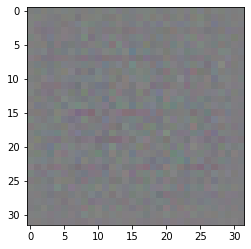

In [8]:
generator = make_generator_model(latent_dim)

noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0][0].numpy()*127.5+127.5).astype("uint32"))

In [9]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 1, 100)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 4, 4, 512)    819712      reshape[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4, 4, 512)    2048        conv2d_transpose[0][0]           
______________________________________________________________________________________________

In [10]:
def make_discriminator_model():
    input1 = keras.layers.Input(shape=(32, 32, 3))
    hidden = keras.layers.Conv2D(filters=128, kernel_size=4, strides=2, padding="same",
                                 activation="relu", kernel_initializer="he_normal")(input1)
    hidden = keras.layers.BatchNormalization()(hidden)

    input2 = keras.layers.Input(shape=(16, 16, 3))
    inputfeature2 = keras.layers.Conv2D(128, 3, 1, padding="same")(input2)
    hidden = keras.layers.Concatenate()([hidden, inputfeature2])
    hidden = keras.layers.Conv2D(filters=256, kernel_size=4, strides=2, padding="same",
                                 activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)

    input3 = keras.layers.Input(shape=(8, 8, 3))
    inputfeature3 = keras.layers.Conv2D(256, 3, 1, padding="same")(input3)
    hidden = keras.layers.Concatenate()([hidden, inputfeature3])
    hidden = keras.layers.Conv2D(filters=512, kernel_size=4, strides=2, padding="same",
                                 activation="relu", kernel_initializer="he_normal")(hidden)
    hidden = keras.layers.BatchNormalization()(hidden)

    input4 = keras.layers.Input(shape=(4, 4, 3))
    inputfeature4 = keras.layers.Conv2D(512, 3, 1, padding="same")(input4)
    hidden = keras.layers.Concatenate()([hidden, inputfeature4])

    hidden = keras.layers.Conv2D(filters=100, kernel_size=4, strides=1, padding="valid", activation="relu")(hidden)
    #hidden = keras.layers.Flatten()(hidden)
    out = keras.layers.Dense(1)(hidden)
    #out = keras.layers.Activation("sigmoid")(hidden)
    

    model = keras.models.Model(inputs=[input1, input2, input3, input4], outputs=[out])
    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image, training=False)
print(decision)

tf.Tensor([[[[0.02592615]]]], shape=(1, 1, 1, 1), dtype=float32)


In [12]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 128)  6272        input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 16, 16, 128)  512         conv2d_4[0][0]                   
____________________________________________________________________________________________

In [13]:
if not os.path.isdir("epochs"):
    os.mkdir("epochs")
def plot_examples(images_at_scales, epoch):
    n_examples = images_at_scales[0].shape[0]
    fig, axes = plt.subplots(figsize=(4, n_examples), nrows=n_examples, ncols=4, dpi=100)
    for i in range(n_examples):
        for j in range(4):
            generated_images = images_at_scales[3-j]
            gen_1 = generated_images[i].numpy()*127.5+127.5
            axes[i, j].axis('off')
            axes[i, j].imshow((gen_1).astype("uint32"), interpolation='none')
    plt.savefig('epochs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [14]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

# The generator is performing well, if the discriminator classifies fakes as real(1)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss,
        generator.trainable_variables
    )

    gradients_of_discriminator = disc_tape.gradient(
        disc_loss,
        discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator,
            generator.trainable_variables)
        )
    discriminator_optimizer.apply_gradients(
        zip(reversed(gradients_of_discriminator),
            reversed(discriminator.trainable_variables))
        )

    return (gen_loss, disc_loss)

In [18]:
def scale_input_images(image_batch):
    result = []
    result.append(image_batch)
    result.append(tf.image.resize(image_batch, [16, 16]))
    result.append(tf.image.resize(image_batch, [8, 8]))
    result.append(tf.image.resize(image_batch, [4, 4]))
    
    return result

In [19]:
def train(dataset, epochs):
    generator_losses = np.empty((0, 0), dtype=float)
    discriminator_losses = np.empty((0, 0), dtype=float)
    for epoch in range(epochs):
        start = time.time()
        
        batch_generator_losses = np.empty((0, 0), dtype=float)
        batch_discriminator_losses = np.empty((0, 0), dtype=float)
        for (batch, image_batch) in enumerate(dataset):
            scaled_batch = scale_input_images(image_batch)
            gen_loss, disc_loss = train_step(scaled_batch)
            
            if batch % 100 == 0:
                average_batch_loss =\
                   gen_loss.numpy()/int(image_batch.shape[1])
                print(f"""Epoch {epoch+1}
                        Batch {batch} Loss {average_batch_loss:.4f}""")

            batch_generator_losses = np.append(batch_generator_losses, gen_loss)
            batch_discriminator_losses = np.append(batch_discriminator_losses, disc_loss)
            
        if generator_losses.shape == (0, 0):
            generator_losses = batch_generator_losses
            discriminator_losses = batch_discriminator_losses
        else:
            generator_losses = np.vstack(
                [generator_losses, batch_generator_losses]
            )
            discriminator_losses = np.vstack(
                [discriminator_losses, batch_discriminator_losses]
            )
            
        # Saving the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Producing images for the GIF
        #display.clear_output(wait=True)
        example_images = generator(seed, training=False)
        plot_examples(example_images, epoch)
        

    # Generating after the final epoch
    example_images = generator(seed, training=False)
    plot_examples(example_images, epoch)
    
    return (generator_losses, discriminator_losses)

2022-04-23 11:39:21.682806: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1228800000 exceeds 10% of free system memory.
2022-04-23 11:39:24.009098: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1
                        Batch 0 Loss 0.0132
Epoch 1
                        Batch 100 Loss 0.1290
Epoch 1
                        Batch 200 Loss 0.1476
Epoch 1
                        Batch 300 Loss 0.2446
Epoch 1
                        Batch 400 Loss 0.2892
Epoch 1
                        Batch 500 Loss 0.2314
Epoch 1
                        Batch 600 Loss 0.2801
Epoch 1
                        Batch 700 Loss 0.2395
Epoch 1
                        Batch 800 Loss 0.3828
Epoch 1
                        Batch 900 Loss 0.4195
Epoch 1
                        Batch 1000 Loss 0.3144
Epoch 1
                        Batch 1100 Loss 0.3776
Epoch 1
                        Batch 1200 Loss 0.5040
Epoch 1
                        Batch 1300 Loss 0.6042
Epoch 1
                        Batch 1400 Loss 0.3618
Epoch 1
                        Batch 1500 Loss 0.2836
Epoch 1
                        Batch 1600 Loss 0.5415
Epoch 1
                        Batch 1700 Loss 0.3289
Epoch 1
              

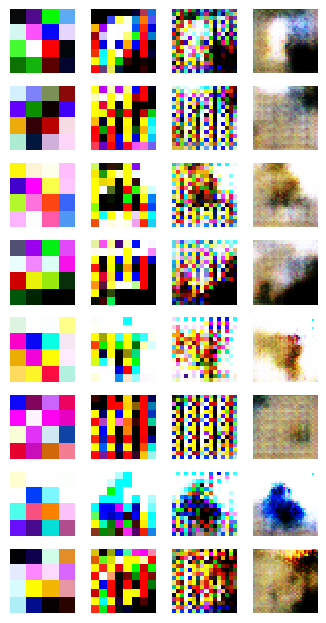

Epoch 2
                        Batch 0 Loss 0.3277
Epoch 2
                        Batch 100 Loss 0.2054
Epoch 2
                        Batch 200 Loss 0.3427
Epoch 2
                        Batch 300 Loss 0.2813
Epoch 2
                        Batch 400 Loss 0.4176
Epoch 2
                        Batch 500 Loss 0.3142
Epoch 2
                        Batch 600 Loss 0.3394
Epoch 2
                        Batch 700 Loss 0.3044
Epoch 2
                        Batch 800 Loss 0.3173
Epoch 2
                        Batch 900 Loss 0.2301
Epoch 2
                        Batch 1000 Loss 0.2771
Epoch 2
                        Batch 1100 Loss 0.3328
Epoch 2
                        Batch 1200 Loss 0.2215
Epoch 2
                        Batch 1300 Loss 0.3044
Epoch 2
                        Batch 1400 Loss 0.3128
Epoch 2
                        Batch 1500 Loss 0.3549
Epoch 2
                        Batch 1600 Loss 0.2748
Epoch 2
                        Batch 1700 Loss 0.3761
Epoch 2
              

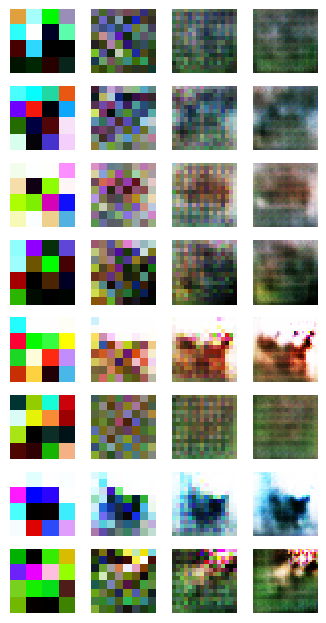

Epoch 3
                        Batch 0 Loss 0.2051
Epoch 3
                        Batch 100 Loss 0.1958
Epoch 3
                        Batch 200 Loss 0.1714
Epoch 3
                        Batch 300 Loss 0.2415
Epoch 3
                        Batch 400 Loss 0.1884
Epoch 3
                        Batch 500 Loss 0.3525
Epoch 3
                        Batch 600 Loss 0.2777
Epoch 3
                        Batch 700 Loss 0.2269
Epoch 3
                        Batch 800 Loss 0.2132
Epoch 3
                        Batch 900 Loss 0.2135
Epoch 3
                        Batch 1000 Loss 0.1985
Epoch 3
                        Batch 1100 Loss 0.3420
Epoch 3
                        Batch 1200 Loss 0.2551
Epoch 3
                        Batch 1300 Loss 0.1752
Epoch 3
                        Batch 1400 Loss 0.2372
Epoch 3
                        Batch 1500 Loss 0.1716
Epoch 3
                        Batch 1600 Loss 0.2103
Epoch 3
                        Batch 1700 Loss 0.1418
Epoch 3
              

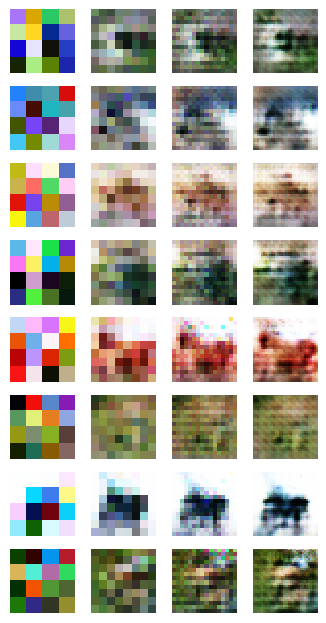

Epoch 4
                        Batch 0 Loss 0.1898
Epoch 4
                        Batch 100 Loss 0.2392
Epoch 4
                        Batch 200 Loss 0.2791
Epoch 4
                        Batch 300 Loss 0.2658
Epoch 4
                        Batch 400 Loss 0.1959
Epoch 4
                        Batch 500 Loss 0.1926
Epoch 4
                        Batch 600 Loss 0.2393
Epoch 4
                        Batch 700 Loss 0.3245
Epoch 4
                        Batch 800 Loss 0.2973
Epoch 4
                        Batch 900 Loss 0.2103
Epoch 4
                        Batch 1000 Loss 0.3574
Epoch 4
                        Batch 1100 Loss 0.1705
Epoch 4
                        Batch 1200 Loss 0.1952
Epoch 4
                        Batch 1300 Loss 0.1956
Epoch 4
                        Batch 1400 Loss 0.2856
Epoch 4
                        Batch 1500 Loss 0.2211
Epoch 4
                        Batch 1600 Loss 0.1818
Epoch 4
                        Batch 1700 Loss 0.3155
Epoch 4
              

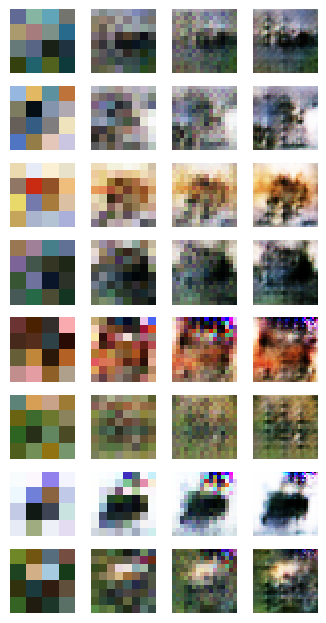

Epoch 5
                        Batch 0 Loss 0.3655
Epoch 5
                        Batch 100 Loss 0.3648
Epoch 5
                        Batch 200 Loss 0.2701
Epoch 5
                        Batch 300 Loss 0.3036
Epoch 5
                        Batch 400 Loss 0.2046
Epoch 5
                        Batch 500 Loss 0.1310
Epoch 5
                        Batch 600 Loss 0.2044
Epoch 5
                        Batch 700 Loss 0.1533
Epoch 5
                        Batch 800 Loss 0.2384
Epoch 5
                        Batch 900 Loss 0.2324
Epoch 5
                        Batch 1000 Loss 0.2762
Epoch 5
                        Batch 1100 Loss 0.1947
Epoch 5
                        Batch 1200 Loss 0.3077
Epoch 5
                        Batch 1300 Loss 0.2741
Epoch 5
                        Batch 1400 Loss 0.2703
Epoch 5
                        Batch 1500 Loss 0.3022
Epoch 5
                        Batch 1600 Loss 0.1985
Epoch 5
                        Batch 1700 Loss 0.1918
Epoch 5
              

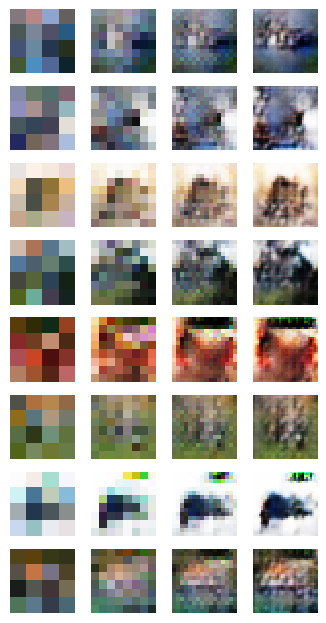

Epoch 6
                        Batch 0 Loss 0.2870
Epoch 6
                        Batch 100 Loss 0.1464
Epoch 6
                        Batch 200 Loss 0.1497
Epoch 6
                        Batch 300 Loss 0.1622
Epoch 6
                        Batch 400 Loss 0.1933
Epoch 6
                        Batch 500 Loss 0.1873
Epoch 6
                        Batch 600 Loss 0.1834
Epoch 6
                        Batch 700 Loss 0.2060
Epoch 6
                        Batch 800 Loss 0.2434
Epoch 6
                        Batch 900 Loss 0.2724
Epoch 6
                        Batch 1000 Loss 0.1899
Epoch 6
                        Batch 1100 Loss 0.1872
Epoch 6
                        Batch 1200 Loss 0.2213
Epoch 6
                        Batch 1300 Loss 0.2962
Epoch 6
                        Batch 1400 Loss 0.2362
Epoch 6
                        Batch 1500 Loss 0.1845
Epoch 6
                        Batch 1600 Loss 0.2106
Epoch 6
                        Batch 1700 Loss 0.1781
Epoch 6
              

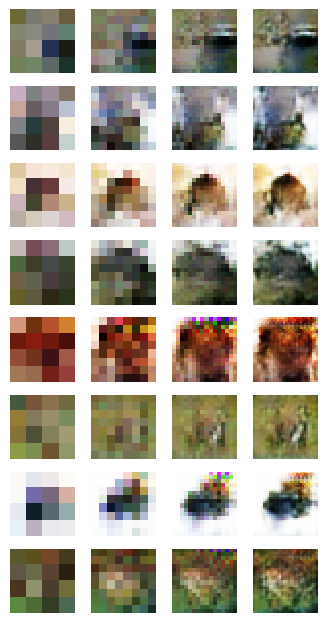

Epoch 7
                        Batch 0 Loss 0.2749
Epoch 7
                        Batch 100 Loss 0.2970
Epoch 7
                        Batch 200 Loss 0.1569
Epoch 7
                        Batch 300 Loss 0.1949
Epoch 7
                        Batch 400 Loss 0.1752
Epoch 7
                        Batch 500 Loss 0.2099
Epoch 7
                        Batch 600 Loss 0.2662
Epoch 7
                        Batch 700 Loss 0.2231
Epoch 7
                        Batch 800 Loss 0.3139
Epoch 7
                        Batch 900 Loss 0.2359
Epoch 7
                        Batch 1000 Loss 0.1971
Epoch 7
                        Batch 1100 Loss 0.1723
Epoch 7
                        Batch 1200 Loss 0.2656
Epoch 7
                        Batch 1300 Loss 0.2323
Epoch 7
                        Batch 1400 Loss 0.3287
Epoch 7
                        Batch 1500 Loss 0.2088
Epoch 7
                        Batch 1600 Loss 0.2976
Epoch 7
                        Batch 1700 Loss 0.2539
Epoch 7
              

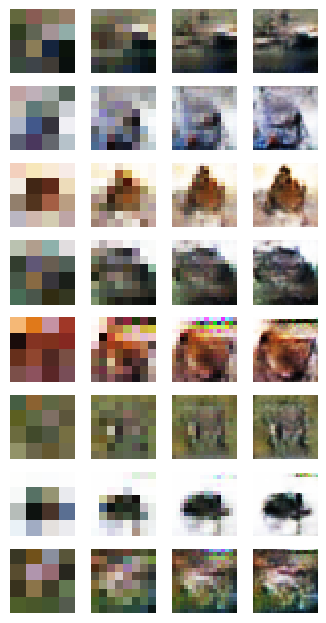

Epoch 8
                        Batch 0 Loss 0.3350
Epoch 8
                        Batch 100 Loss 0.2577
Epoch 8
                        Batch 200 Loss 0.2201
Epoch 8
                        Batch 300 Loss 0.3402
Epoch 8
                        Batch 400 Loss 0.1782
Epoch 8
                        Batch 500 Loss 0.2207
Epoch 8
                        Batch 600 Loss 0.2026
Epoch 8
                        Batch 700 Loss 0.1697
Epoch 8
                        Batch 800 Loss 0.2424
Epoch 8
                        Batch 900 Loss 0.2358
Epoch 8
                        Batch 1000 Loss 0.3972
Epoch 8
                        Batch 1100 Loss 0.2422
Epoch 8
                        Batch 1200 Loss 0.2522
Epoch 8
                        Batch 1300 Loss 0.2348
Epoch 8
                        Batch 1400 Loss 0.1879
Epoch 8
                        Batch 1500 Loss 0.2278
Epoch 8
                        Batch 1600 Loss 0.1793
Epoch 8
                        Batch 1700 Loss 0.2923
Epoch 8
              

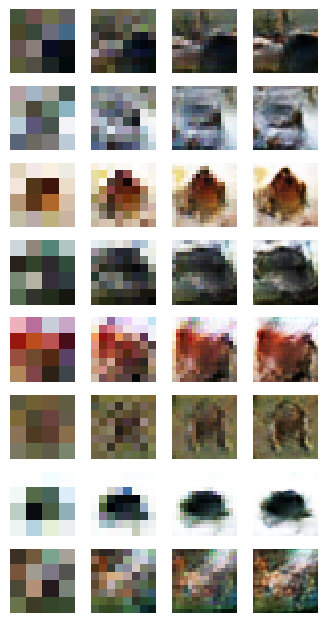

Epoch 9
                        Batch 0 Loss 0.3690
Epoch 9
                        Batch 100 Loss 0.3252
Epoch 9
                        Batch 200 Loss 0.1985
Epoch 9
                        Batch 300 Loss 0.3049
Epoch 9
                        Batch 400 Loss 0.3446
Epoch 9
                        Batch 500 Loss 0.2682
Epoch 9
                        Batch 600 Loss 0.1635
Epoch 9
                        Batch 700 Loss 0.2272
Epoch 9
                        Batch 800 Loss 0.2901
Epoch 9
                        Batch 900 Loss 0.2083
Epoch 9
                        Batch 1000 Loss 0.1532
Epoch 9
                        Batch 1100 Loss 0.3444
Epoch 9
                        Batch 1200 Loss 0.5638
Epoch 9
                        Batch 1300 Loss 0.2443
Epoch 9
                        Batch 1400 Loss 0.1662
Epoch 9
                        Batch 1500 Loss 0.2452
Epoch 9
                        Batch 1600 Loss 0.3824
Epoch 9
                        Batch 1700 Loss 0.1662
Epoch 9
              

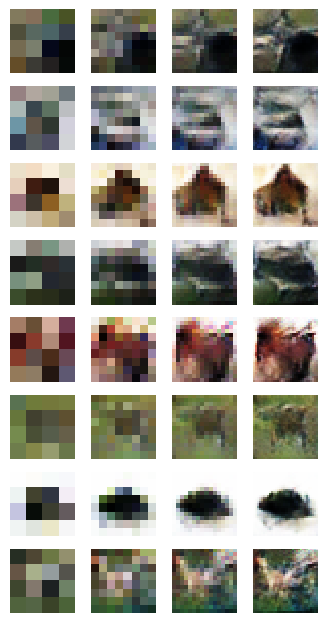

Epoch 10
                        Batch 0 Loss 0.1953
Epoch 10
                        Batch 100 Loss 0.3105
Epoch 10
                        Batch 200 Loss 0.1906
Epoch 10
                        Batch 300 Loss 0.1901
Epoch 10
                        Batch 400 Loss 0.2026
Epoch 10
                        Batch 500 Loss 0.2845
Epoch 10
                        Batch 600 Loss 0.1777
Epoch 10
                        Batch 700 Loss 0.1903
Epoch 10
                        Batch 800 Loss 0.1490
Epoch 10
                        Batch 900 Loss 0.1817
Epoch 10
                        Batch 1000 Loss 0.1812
Epoch 10
                        Batch 1100 Loss 0.2339
Epoch 10
                        Batch 1200 Loss 0.3377
Epoch 10
                        Batch 1300 Loss 0.3960
Epoch 10
                        Batch 1400 Loss 0.2834
Epoch 10
                        Batch 1500 Loss 0.1981
Epoch 10
                        Batch 1600 Loss 0.3319
Epoch 10
                        Batch 1700 Loss 0.2166
Epoc

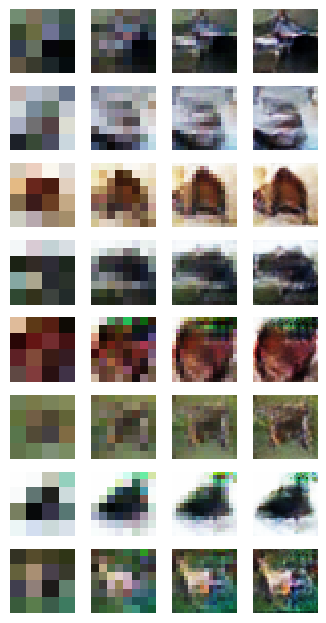

Epoch 11
                        Batch 0 Loss 0.2634
Epoch 11
                        Batch 100 Loss 0.1640
Epoch 11
                        Batch 200 Loss 0.2367
Epoch 11
                        Batch 300 Loss 0.3229
Epoch 11
                        Batch 400 Loss 0.2134
Epoch 11
                        Batch 500 Loss 0.1617
Epoch 11
                        Batch 600 Loss 0.2618
Epoch 11
                        Batch 700 Loss 0.3278
Epoch 11
                        Batch 800 Loss 0.2270
Epoch 11
                        Batch 900 Loss 0.2557
Epoch 11
                        Batch 1000 Loss 0.2446
Epoch 11
                        Batch 1100 Loss 0.1929
Epoch 11
                        Batch 1200 Loss 0.2647
Epoch 11
                        Batch 1300 Loss 0.3309
Epoch 11
                        Batch 1400 Loss 0.3266
Epoch 11
                        Batch 1500 Loss 0.3062
Epoch 11
                        Batch 1600 Loss 0.2037
Epoch 11
                        Batch 1700 Loss 0.3148
Epoc

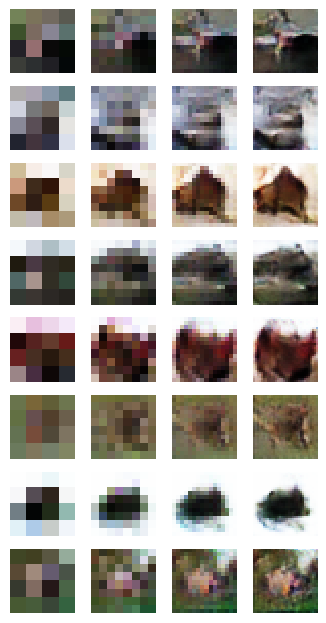

Epoch 12
                        Batch 0 Loss 0.3159
Epoch 12
                        Batch 100 Loss 0.3200
Epoch 12
                        Batch 200 Loss 0.3410
Epoch 12
                        Batch 300 Loss 0.2766
Epoch 12
                        Batch 400 Loss 0.2937
Epoch 12
                        Batch 500 Loss 0.2179
Epoch 12
                        Batch 600 Loss 0.2236
Epoch 12
                        Batch 700 Loss 0.1363
Epoch 12
                        Batch 800 Loss 0.2090
Epoch 12
                        Batch 900 Loss 0.2147
Epoch 12
                        Batch 1000 Loss 0.3506
Epoch 12
                        Batch 1100 Loss 0.3953
Epoch 12
                        Batch 1200 Loss 0.3314
Epoch 12
                        Batch 1300 Loss 0.3709
Epoch 12
                        Batch 1400 Loss 0.1666
Epoch 12
                        Batch 1500 Loss 0.2461
Epoch 12
                        Batch 1600 Loss 0.1843
Epoch 12
                        Batch 1700 Loss 0.2562
Epoc

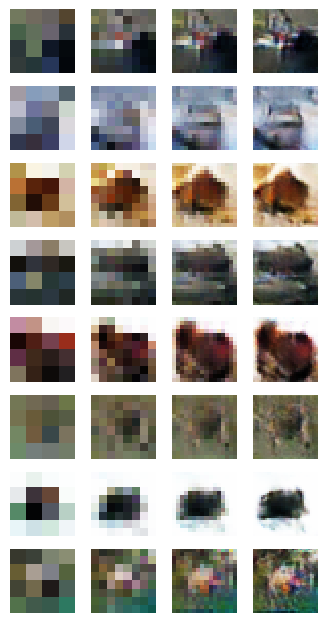

Epoch 13
                        Batch 0 Loss 0.2180
Epoch 13
                        Batch 100 Loss 0.3468
Epoch 13
                        Batch 200 Loss 0.1648
Epoch 13
                        Batch 300 Loss 0.4662
Epoch 13
                        Batch 400 Loss 0.3600
Epoch 13
                        Batch 500 Loss 0.1624
Epoch 13
                        Batch 600 Loss 0.1560
Epoch 13
                        Batch 700 Loss 0.1843
Epoch 13
                        Batch 800 Loss 0.3662
Epoch 13
                        Batch 900 Loss 0.2514
Epoch 13
                        Batch 1000 Loss 0.2057
Epoch 13
                        Batch 1100 Loss 0.2391
Epoch 13
                        Batch 1200 Loss 0.3714
Epoch 13
                        Batch 1300 Loss 0.3973
Epoch 13
                        Batch 1400 Loss 0.3246
Epoch 13
                        Batch 1500 Loss 0.1741
Epoch 13
                        Batch 1600 Loss 0.4036
Epoch 13
                        Batch 1700 Loss 0.3524
Epoc

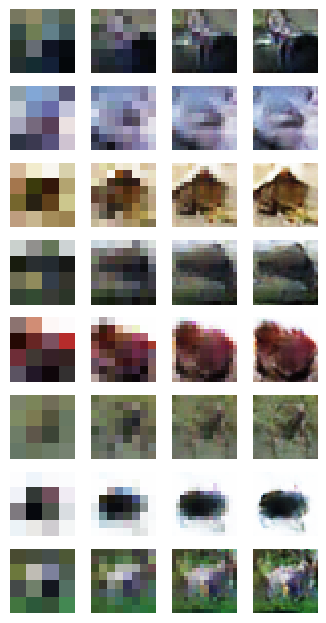

Epoch 14
                        Batch 0 Loss 0.2790
Epoch 14
                        Batch 100 Loss 0.2736
Epoch 14
                        Batch 200 Loss 0.2611
Epoch 14
                        Batch 300 Loss 0.5658
Epoch 14
                        Batch 400 Loss 0.2272
Epoch 14
                        Batch 500 Loss 0.1423
Epoch 14
                        Batch 600 Loss 0.2718
Epoch 14
                        Batch 700 Loss 0.2608
Epoch 14
                        Batch 800 Loss 0.3762
Epoch 14
                        Batch 900 Loss 0.1951
Epoch 14
                        Batch 1000 Loss 0.2283
Epoch 14
                        Batch 1100 Loss 0.3818
Epoch 14
                        Batch 1200 Loss 0.3287
Epoch 14
                        Batch 1300 Loss 0.4289
Epoch 14
                        Batch 1400 Loss 0.5319
Epoch 14
                        Batch 1500 Loss 0.3591
Epoch 14
                        Batch 1600 Loss 0.2942
Epoch 14
                        Batch 1700 Loss 0.3871
Epoc

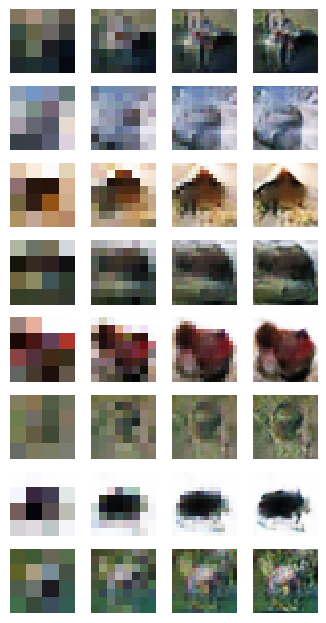

Epoch 15
                        Batch 0 Loss 0.1121
Epoch 15
                        Batch 100 Loss 0.2651
Epoch 15
                        Batch 200 Loss 0.4344
Epoch 15
                        Batch 300 Loss 0.2591
Epoch 15
                        Batch 400 Loss 0.2967
Epoch 15
                        Batch 500 Loss 0.2313
Epoch 15
                        Batch 600 Loss 0.2799
Epoch 15
                        Batch 700 Loss 0.3705
Epoch 15
                        Batch 800 Loss 0.1259
Epoch 15
                        Batch 900 Loss 0.2060
Epoch 15
                        Batch 1000 Loss 0.2254
Epoch 15
                        Batch 1100 Loss 0.2588
Epoch 15
                        Batch 1200 Loss 0.2523
Epoch 15
                        Batch 1300 Loss 0.3574
Epoch 15
                        Batch 1400 Loss 0.4191
Epoch 15
                        Batch 1500 Loss 0.4636
Epoch 15
                        Batch 1600 Loss 0.3395
Epoch 15
                        Batch 1700 Loss 0.2655
Epoc

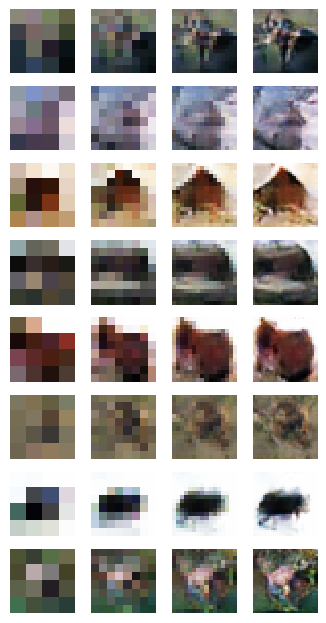

Epoch 16
                        Batch 0 Loss 0.2675
Epoch 16
                        Batch 100 Loss 0.1659
Epoch 16
                        Batch 200 Loss 0.2558
Epoch 16
                        Batch 300 Loss 0.2995
Epoch 16
                        Batch 400 Loss 0.3323
Epoch 16
                        Batch 500 Loss 0.1749
Epoch 16
                        Batch 600 Loss 0.2466
Epoch 16
                        Batch 700 Loss 0.4371
Epoch 16
                        Batch 800 Loss 0.1788
Epoch 16
                        Batch 900 Loss 0.3052
Epoch 16
                        Batch 1000 Loss 0.3569
Epoch 16
                        Batch 1100 Loss 0.4857
Epoch 16
                        Batch 1200 Loss 0.2496
Epoch 16
                        Batch 1300 Loss 0.3437
Epoch 16
                        Batch 1400 Loss 0.3376
Epoch 16
                        Batch 1500 Loss 0.3864
Epoch 16
                        Batch 1600 Loss 0.2813
Epoch 16
                        Batch 1700 Loss 0.2535
Epoc

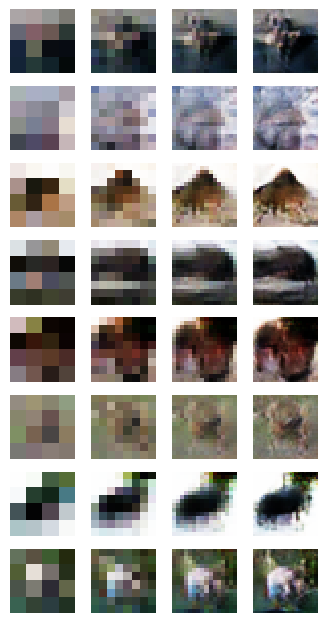

Epoch 17
                        Batch 0 Loss 0.3323
Epoch 17
                        Batch 100 Loss 0.3097
Epoch 17
                        Batch 200 Loss 0.2801
Epoch 17
                        Batch 300 Loss 0.2620
Epoch 17
                        Batch 400 Loss 0.0779
Epoch 17
                        Batch 500 Loss 0.1887
Epoch 17
                        Batch 600 Loss 0.2751
Epoch 17
                        Batch 700 Loss 0.2957
Epoch 17
                        Batch 800 Loss 0.2779
Epoch 17
                        Batch 900 Loss 0.2843
Epoch 17
                        Batch 1000 Loss 0.2316
Epoch 17
                        Batch 1100 Loss 0.2252
Epoch 17
                        Batch 1200 Loss 0.0642
Epoch 17
                        Batch 1300 Loss 0.3499
Epoch 17
                        Batch 1400 Loss 0.3793
Epoch 17
                        Batch 1500 Loss 0.2569
Epoch 17
                        Batch 1600 Loss 0.2706
Epoch 17
                        Batch 1700 Loss 0.7315
Epoc

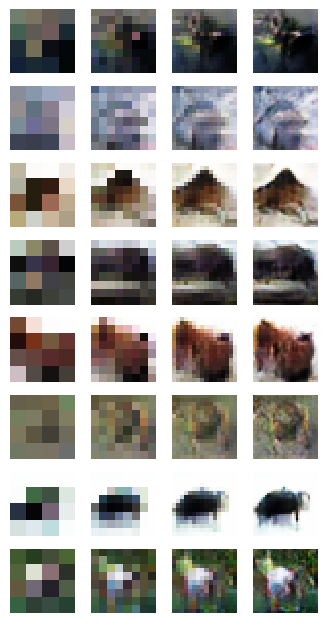

Epoch 18
                        Batch 0 Loss 0.1862
Epoch 18
                        Batch 100 Loss 0.2850
Epoch 18
                        Batch 200 Loss 0.2494
Epoch 18
                        Batch 300 Loss 0.2280
Epoch 18
                        Batch 400 Loss 0.3783
Epoch 18
                        Batch 500 Loss 0.2275
Epoch 18
                        Batch 600 Loss 0.2557
Epoch 18
                        Batch 700 Loss 0.2346
Epoch 18
                        Batch 800 Loss 0.3411
Epoch 18
                        Batch 900 Loss 0.2389
Epoch 18
                        Batch 1000 Loss 0.3302
Epoch 18
                        Batch 1100 Loss 0.4123
Epoch 18
                        Batch 1200 Loss 0.1242
Epoch 18
                        Batch 1300 Loss 0.3049
Epoch 18
                        Batch 1400 Loss 0.4117
Epoch 18
                        Batch 1500 Loss 0.6048
Epoch 18
                        Batch 1600 Loss 0.2818
Epoch 18
                        Batch 1700 Loss 0.4097
Epoc

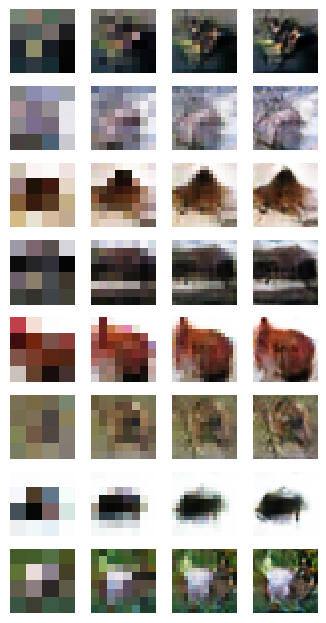

Epoch 19
                        Batch 0 Loss 0.2028
Epoch 19
                        Batch 100 Loss 0.4275
Epoch 19
                        Batch 200 Loss 0.2254
Epoch 19
                        Batch 300 Loss 0.2996
Epoch 19
                        Batch 400 Loss 0.2553
Epoch 19
                        Batch 500 Loss 0.1633
Epoch 19
                        Batch 600 Loss 0.3345
Epoch 19
                        Batch 700 Loss 0.1475
Epoch 19
                        Batch 800 Loss 0.3826
Epoch 19
                        Batch 900 Loss 0.2066
Epoch 19
                        Batch 1000 Loss 0.3424
Epoch 19
                        Batch 1100 Loss 0.2012
Epoch 19
                        Batch 1200 Loss 0.0971
Epoch 19
                        Batch 1300 Loss 0.3402
Epoch 19
                        Batch 1400 Loss 0.2986
Epoch 19
                        Batch 1500 Loss 0.1956
Epoch 19
                        Batch 1600 Loss 0.1661
Epoch 19
                        Batch 1700 Loss 0.1942
Epoc

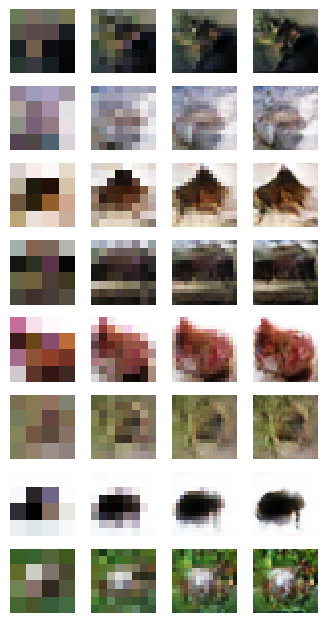

Epoch 20
                        Batch 0 Loss 0.4127
Epoch 20
                        Batch 100 Loss 0.3053
Epoch 20
                        Batch 200 Loss 0.2066
Epoch 20
                        Batch 300 Loss 0.2864
Epoch 20
                        Batch 400 Loss 0.3713
Epoch 20
                        Batch 500 Loss 0.2054
Epoch 20
                        Batch 600 Loss 0.3577
Epoch 20
                        Batch 700 Loss 0.1695
Epoch 20
                        Batch 800 Loss 0.2641
Epoch 20
                        Batch 900 Loss 0.2708
Epoch 20
                        Batch 1000 Loss 0.3539
Epoch 20
                        Batch 1100 Loss 0.2046
Epoch 20
                        Batch 1200 Loss 0.1267
Epoch 20
                        Batch 1300 Loss 0.2638
Epoch 20
                        Batch 1400 Loss 0.3945
Epoch 20
                        Batch 1500 Loss 0.1689
Epoch 20
                        Batch 1600 Loss 0.3072
Epoch 20
                        Batch 1700 Loss 0.3385
Epoc

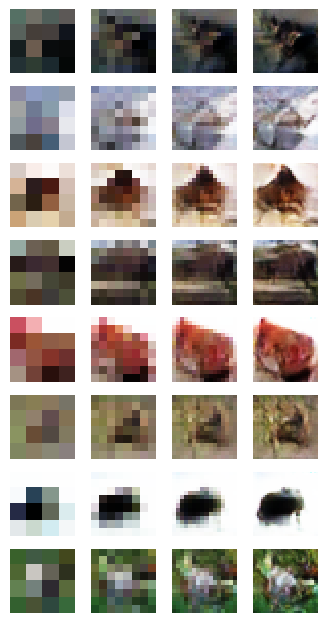

Epoch 21
                        Batch 0 Loss 0.3371
Epoch 21
                        Batch 100 Loss 0.2005
Epoch 21
                        Batch 200 Loss 0.3325
Epoch 21
                        Batch 300 Loss 0.3924
Epoch 21
                        Batch 400 Loss 0.4297
Epoch 21
                        Batch 500 Loss 0.3756
Epoch 21
                        Batch 600 Loss 0.2627
Epoch 21
                        Batch 700 Loss 0.2857
Epoch 21
                        Batch 800 Loss 0.4288
Epoch 21
                        Batch 900 Loss 0.1530
Epoch 21
                        Batch 1000 Loss 0.3926
Epoch 21
                        Batch 1100 Loss 0.3876
Epoch 21
                        Batch 1200 Loss 0.1535
Epoch 21
                        Batch 1300 Loss 0.2569
Epoch 21
                        Batch 1400 Loss 0.3072
Epoch 21
                        Batch 1500 Loss 0.2522
Epoch 21
                        Batch 1600 Loss 0.1258
Epoch 21
                        Batch 1700 Loss 0.1223
Epoc

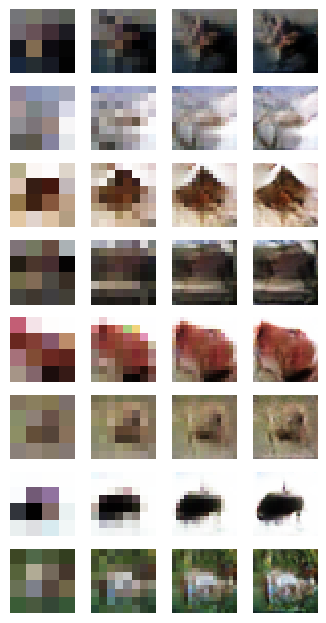

Epoch 22
                        Batch 0 Loss 0.2421
Epoch 22
                        Batch 100 Loss 0.3784
Epoch 22
                        Batch 200 Loss 0.4557
Epoch 22
                        Batch 300 Loss 0.3211
Epoch 22
                        Batch 400 Loss 0.2213
Epoch 22
                        Batch 500 Loss 0.2649
Epoch 22
                        Batch 600 Loss 0.1614
Epoch 22
                        Batch 700 Loss 0.2433
Epoch 22
                        Batch 800 Loss 0.3175
Epoch 22
                        Batch 900 Loss 0.3515
Epoch 22
                        Batch 1000 Loss 0.2099
Epoch 22
                        Batch 1100 Loss 0.2678
Epoch 22
                        Batch 1200 Loss 0.2989
Epoch 22
                        Batch 1300 Loss 0.2767
Epoch 22
                        Batch 1400 Loss 0.4483
Epoch 22
                        Batch 1500 Loss 0.2412
Epoch 22
                        Batch 1600 Loss 0.2517
Epoch 22
                        Batch 1700 Loss 0.3321
Epoc

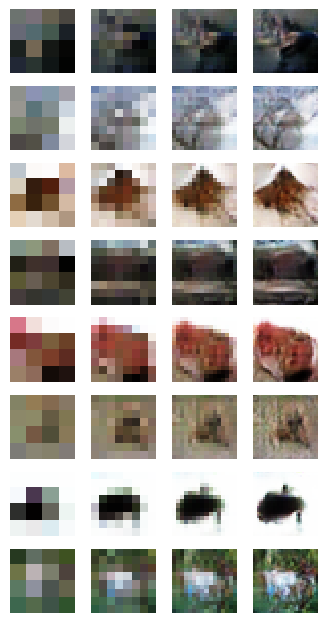

Epoch 23
                        Batch 0 Loss 0.3896
Epoch 23
                        Batch 100 Loss 0.3944
Epoch 23
                        Batch 200 Loss 0.3238
Epoch 23
                        Batch 300 Loss 0.5397
Epoch 23
                        Batch 400 Loss 0.2119
Epoch 23
                        Batch 500 Loss 0.2772
Epoch 23
                        Batch 600 Loss 0.2005
Epoch 23
                        Batch 700 Loss 0.3352
Epoch 23
                        Batch 800 Loss 0.1434
Epoch 23
                        Batch 900 Loss 0.2694
Epoch 23
                        Batch 1000 Loss 0.1793
Epoch 23
                        Batch 1100 Loss 0.4792
Epoch 23
                        Batch 1200 Loss 0.2100
Epoch 23
                        Batch 1300 Loss 0.3350
Epoch 23
                        Batch 1400 Loss 0.3016
Epoch 23
                        Batch 1500 Loss 0.2418
Epoch 23
                        Batch 1600 Loss 0.1639
Epoch 23
                        Batch 1700 Loss 0.2529
Epoc

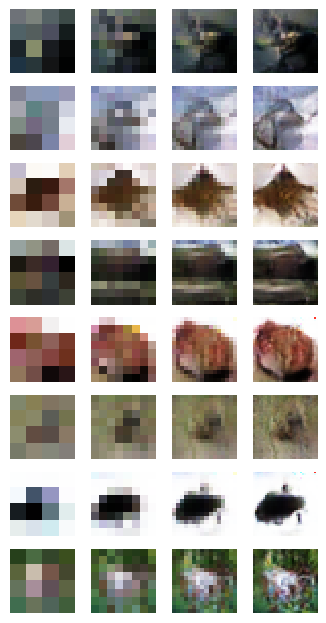

Epoch 24
                        Batch 0 Loss 0.3009
Epoch 24
                        Batch 100 Loss 0.2928
Epoch 24
                        Batch 200 Loss 0.4905
Epoch 24
                        Batch 300 Loss 0.3158
Epoch 24
                        Batch 400 Loss 0.2564
Epoch 24
                        Batch 500 Loss 0.3189
Epoch 24
                        Batch 600 Loss 0.3014
Epoch 24
                        Batch 700 Loss 0.2060
Epoch 24
                        Batch 800 Loss 0.3981
Epoch 24
                        Batch 900 Loss 0.2374
Epoch 24
                        Batch 1000 Loss 0.4309
Epoch 24
                        Batch 1100 Loss 0.3862
Epoch 24
                        Batch 1200 Loss 0.2347
Epoch 24
                        Batch 1300 Loss 0.2743
Epoch 24
                        Batch 1400 Loss 0.2916
Epoch 24
                        Batch 1500 Loss 0.2275
Epoch 24
                        Batch 1600 Loss 0.2539
Epoch 24
                        Batch 1700 Loss 0.2513
Epoc

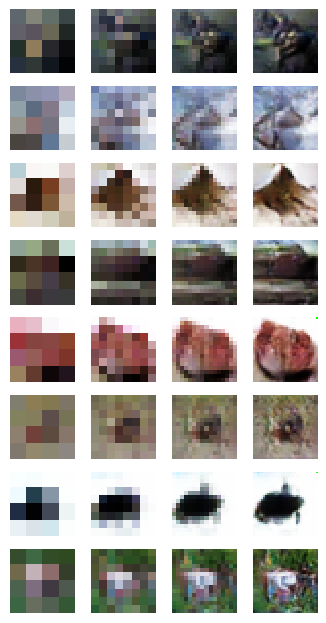

Epoch 25
                        Batch 0 Loss 0.3635
Epoch 25
                        Batch 100 Loss 0.5590
Epoch 25
                        Batch 200 Loss 0.3575
Epoch 25
                        Batch 300 Loss 0.4387
Epoch 25
                        Batch 400 Loss 0.3136
Epoch 25
                        Batch 500 Loss 0.2917
Epoch 25
                        Batch 600 Loss 0.1916
Epoch 25
                        Batch 700 Loss 0.2834
Epoch 25
                        Batch 800 Loss 0.2813
Epoch 25
                        Batch 900 Loss 0.4712
Epoch 25
                        Batch 1000 Loss 0.3821
Epoch 25
                        Batch 1100 Loss 0.2552
Epoch 25
                        Batch 1200 Loss 0.3264
Epoch 25
                        Batch 1300 Loss 0.1817
Epoch 25
                        Batch 1400 Loss 0.4463
Epoch 25
                        Batch 1500 Loss 0.2983
Epoch 25
                        Batch 1600 Loss 0.2825
Epoch 25
                        Batch 1700 Loss 0.2605
Epoc

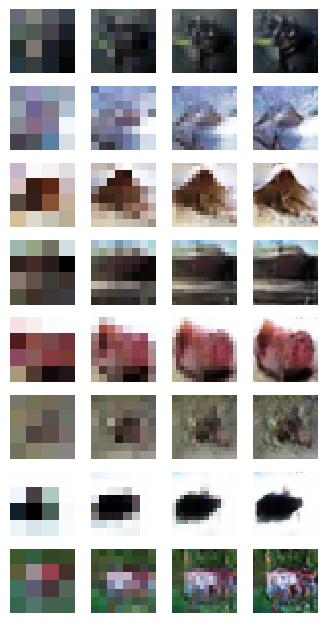

Epoch 26
                        Batch 0 Loss 0.2490
Epoch 26
                        Batch 100 Loss 0.3926
Epoch 26
                        Batch 200 Loss 0.0772
Epoch 26
                        Batch 300 Loss 0.2450
Epoch 26
                        Batch 400 Loss 0.1306
Epoch 26
                        Batch 500 Loss 0.2934
Epoch 26
                        Batch 600 Loss 0.3768
Epoch 26
                        Batch 700 Loss 0.3158
Epoch 26
                        Batch 800 Loss 0.1366
Epoch 26
                        Batch 900 Loss 0.1631
Epoch 26
                        Batch 1000 Loss 0.3175
Epoch 26
                        Batch 1100 Loss 0.3873
Epoch 26
                        Batch 1200 Loss 0.3774
Epoch 26
                        Batch 1300 Loss 0.1985
Epoch 26
                        Batch 1400 Loss 0.3271
Epoch 26
                        Batch 1500 Loss 0.2205
Epoch 26
                        Batch 1600 Loss 0.2165
Epoch 26
                        Batch 1700 Loss 0.1662
Epoc

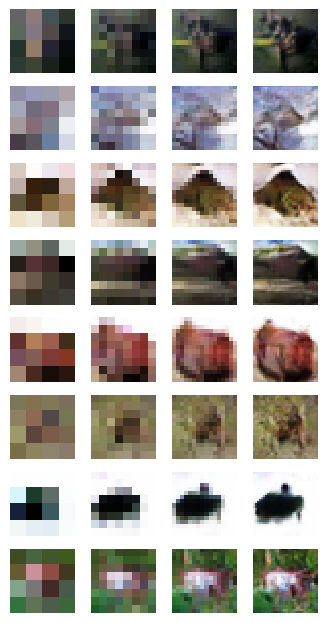

Epoch 27
                        Batch 0 Loss 0.4719
Epoch 27
                        Batch 100 Loss 0.2170
Epoch 27
                        Batch 200 Loss 0.2793
Epoch 27
                        Batch 300 Loss 0.3986
Epoch 27
                        Batch 400 Loss 0.2797
Epoch 27
                        Batch 500 Loss 0.2477
Epoch 27
                        Batch 600 Loss 0.4710
Epoch 27
                        Batch 700 Loss 0.3702
Epoch 27
                        Batch 800 Loss 0.3518
Epoch 27
                        Batch 900 Loss 0.2674
Epoch 27
                        Batch 1000 Loss 0.4315
Epoch 27
                        Batch 1100 Loss 0.2982
Epoch 27
                        Batch 1200 Loss 0.3392
Epoch 27
                        Batch 1300 Loss 0.1780
Epoch 27
                        Batch 1400 Loss 0.3844
Epoch 27
                        Batch 1500 Loss 0.1822
Epoch 27
                        Batch 1600 Loss 0.2756
Epoch 27
                        Batch 1700 Loss 0.1110
Epoc

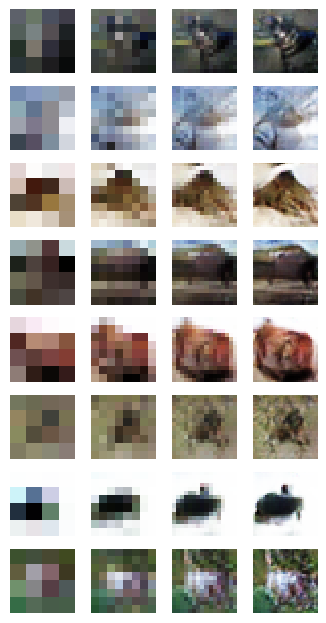

Epoch 28
                        Batch 0 Loss 0.5454
Epoch 28
                        Batch 100 Loss 0.3165
Epoch 28
                        Batch 200 Loss 0.1788
Epoch 28
                        Batch 300 Loss 0.4569
Epoch 28
                        Batch 400 Loss 0.4518
Epoch 28
                        Batch 500 Loss 0.2486
Epoch 28
                        Batch 600 Loss 0.3327
Epoch 28
                        Batch 700 Loss 0.2473
Epoch 28
                        Batch 800 Loss 0.4125
Epoch 28
                        Batch 900 Loss 0.3911
Epoch 28
                        Batch 1000 Loss 0.4858
Epoch 28
                        Batch 1100 Loss 0.3630
Epoch 28
                        Batch 1200 Loss 0.2336
Epoch 28
                        Batch 1300 Loss 0.3954
Epoch 28
                        Batch 1400 Loss 0.2291
Epoch 28
                        Batch 1500 Loss 0.1755
Epoch 28
                        Batch 1600 Loss 0.3204
Epoch 28
                        Batch 1700 Loss 0.2537
Epoc

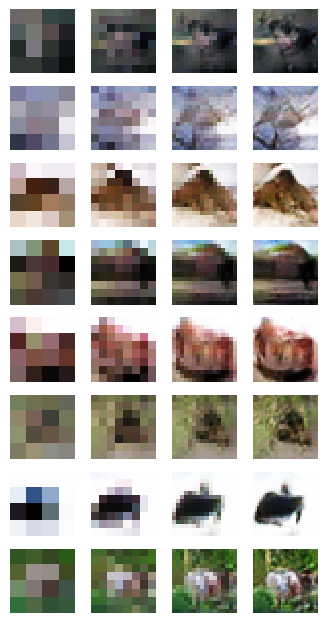

Epoch 29
                        Batch 0 Loss 0.2601
Epoch 29
                        Batch 100 Loss 0.1273
Epoch 29
                        Batch 200 Loss 0.3649
Epoch 29
                        Batch 300 Loss 0.2126
Epoch 29
                        Batch 400 Loss 0.3338
Epoch 29
                        Batch 500 Loss 0.3394
Epoch 29
                        Batch 600 Loss 0.3333
Epoch 29
                        Batch 700 Loss 0.2202
Epoch 29
                        Batch 800 Loss 0.3877
Epoch 29
                        Batch 900 Loss 0.1899
Epoch 29
                        Batch 1000 Loss 0.3217
Epoch 29
                        Batch 1100 Loss 0.2634
Epoch 29
                        Batch 1200 Loss 0.1927
Epoch 29
                        Batch 1300 Loss 0.2305
Epoch 29
                        Batch 1400 Loss 0.2274
Epoch 29
                        Batch 1500 Loss 0.3555
Epoch 29
                        Batch 1600 Loss 0.3650
Epoch 29
                        Batch 1700 Loss 0.4233
Epoc

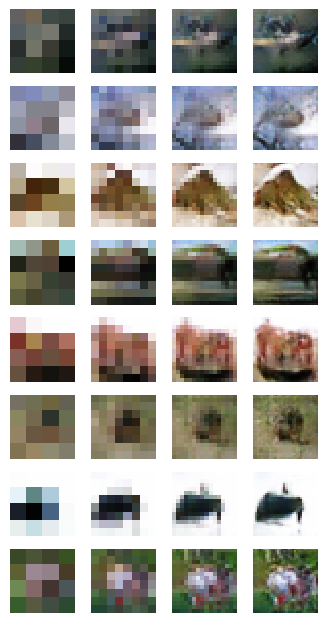

Epoch 30
                        Batch 0 Loss 0.2092
Epoch 30
                        Batch 100 Loss 0.4470
Epoch 30
                        Batch 200 Loss 0.2045
Epoch 30
                        Batch 300 Loss 0.4824
Epoch 30
                        Batch 400 Loss 0.2497
Epoch 30
                        Batch 500 Loss 0.2292
Epoch 30
                        Batch 600 Loss 0.4070
Epoch 30
                        Batch 700 Loss 0.2284
Epoch 30
                        Batch 800 Loss 0.2276
Epoch 30
                        Batch 900 Loss 0.3090
Epoch 30
                        Batch 1000 Loss 0.4416
Epoch 30
                        Batch 1100 Loss 0.3095
Epoch 30
                        Batch 1200 Loss 0.3055
Epoch 30
                        Batch 1300 Loss 0.1550
Epoch 30
                        Batch 1400 Loss 0.4144
Epoch 30
                        Batch 1500 Loss 0.2264
Epoch 30
                        Batch 1600 Loss 0.5029
Epoch 30
                        Batch 1700 Loss 0.2271
Epoc

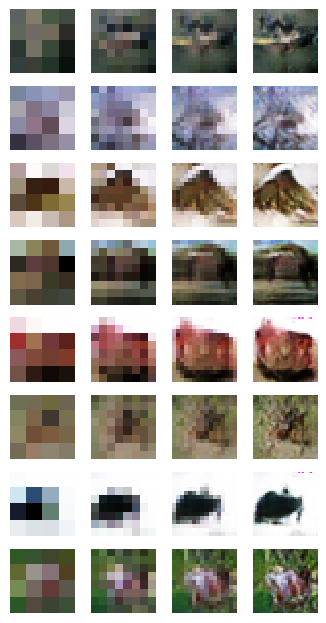

Epoch 31
                        Batch 0 Loss 0.2023
Epoch 31
                        Batch 100 Loss 0.2164
Epoch 31
                        Batch 200 Loss 0.2009
Epoch 31
                        Batch 300 Loss 0.4225
Epoch 31
                        Batch 400 Loss 0.2746
Epoch 31
                        Batch 500 Loss 0.2985
Epoch 31
                        Batch 600 Loss 0.3163
Epoch 31
                        Batch 700 Loss 0.3142
Epoch 31
                        Batch 800 Loss 0.2606
Epoch 31
                        Batch 900 Loss 0.3732
Epoch 31
                        Batch 1000 Loss 0.3510
Epoch 31
                        Batch 1100 Loss 0.3925
Epoch 31
                        Batch 1200 Loss 0.2110
Epoch 31
                        Batch 1300 Loss 0.4267
Epoch 31
                        Batch 1400 Loss 0.4550
Epoch 31
                        Batch 1500 Loss 0.3484
Epoch 31
                        Batch 1600 Loss 0.3146
Epoch 31
                        Batch 1700 Loss 0.4356
Epoc

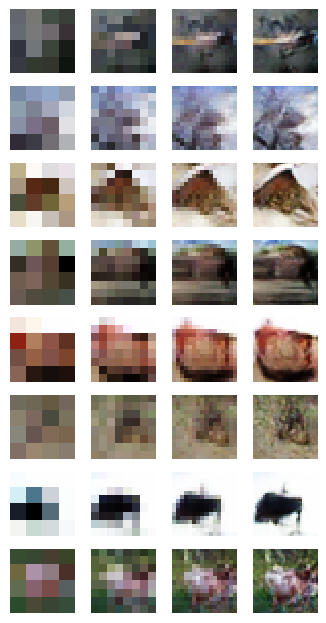

Epoch 32
                        Batch 0 Loss 0.4141
Epoch 32
                        Batch 100 Loss 0.2476
Epoch 32
                        Batch 200 Loss 0.3523
Epoch 32
                        Batch 300 Loss 0.2108
Epoch 32
                        Batch 400 Loss 0.1809
Epoch 32
                        Batch 500 Loss 0.3577
Epoch 32
                        Batch 600 Loss 0.4515
Epoch 32
                        Batch 700 Loss 0.1759
Epoch 32
                        Batch 800 Loss 0.2201
Epoch 32
                        Batch 900 Loss 0.2072
Epoch 32
                        Batch 1000 Loss 0.2216
Epoch 32
                        Batch 1100 Loss 0.3582
Epoch 32
                        Batch 1200 Loss 0.2596
Epoch 32
                        Batch 1300 Loss 0.3597
Epoch 32
                        Batch 1400 Loss 0.3644
Epoch 32
                        Batch 1500 Loss 0.4893
Epoch 32
                        Batch 1600 Loss 0.2744
Epoch 32
                        Batch 1700 Loss 0.1896
Epoc

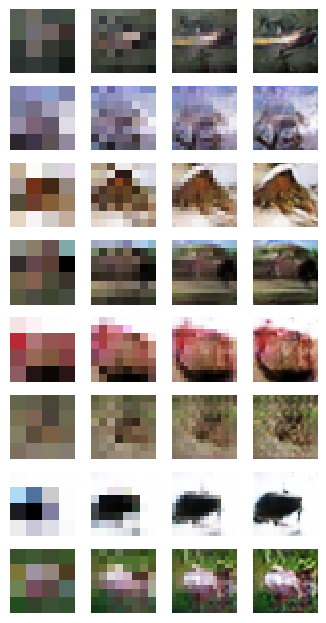

Epoch 33
                        Batch 0 Loss 0.2201
Epoch 33
                        Batch 100 Loss 0.2904
Epoch 33
                        Batch 200 Loss 0.3366
Epoch 33
                        Batch 300 Loss 0.5010
Epoch 33
                        Batch 400 Loss 0.2932
Epoch 33
                        Batch 500 Loss 0.2959
Epoch 33
                        Batch 600 Loss 0.4107
Epoch 33
                        Batch 700 Loss 0.2834
Epoch 33
                        Batch 800 Loss 0.4256
Epoch 33
                        Batch 900 Loss 0.3713
Epoch 33
                        Batch 1000 Loss 0.2756
Epoch 33
                        Batch 1100 Loss 0.4334
Epoch 33
                        Batch 1200 Loss 0.4516
Epoch 33
                        Batch 1300 Loss 0.2371
Epoch 33
                        Batch 1400 Loss 0.5556
Epoch 33
                        Batch 1500 Loss 0.3662
Epoch 33
                        Batch 1600 Loss 0.3565
Epoch 33
                        Batch 1700 Loss 0.2980
Epoc

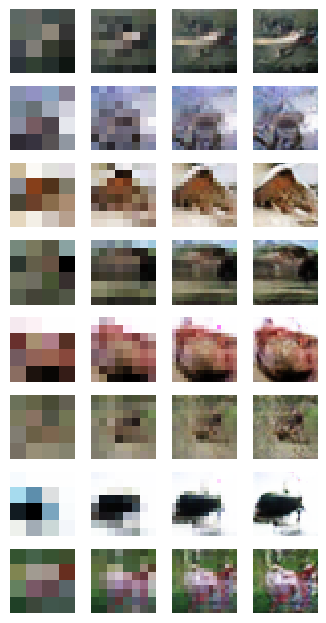

Epoch 34
                        Batch 0 Loss 0.3582
Epoch 34
                        Batch 100 Loss 0.2928
Epoch 34
                        Batch 200 Loss 0.3976
Epoch 34
                        Batch 300 Loss 0.4267
Epoch 34
                        Batch 400 Loss 0.2663
Epoch 34
                        Batch 500 Loss 0.3089
Epoch 34
                        Batch 600 Loss 0.3521
Epoch 34
                        Batch 700 Loss 0.3828
Epoch 34
                        Batch 800 Loss 0.2993
Epoch 34
                        Batch 900 Loss 0.1942
Epoch 34
                        Batch 1000 Loss 0.5085
Epoch 34
                        Batch 1100 Loss 0.3609
Epoch 34
                        Batch 1200 Loss 0.2746
Epoch 34
                        Batch 1300 Loss 0.4589
Epoch 34
                        Batch 1400 Loss 0.4055
Epoch 34
                        Batch 1500 Loss 0.4952
Epoch 34
                        Batch 1600 Loss 0.2487
Epoch 34
                        Batch 1700 Loss 0.2762
Epoc

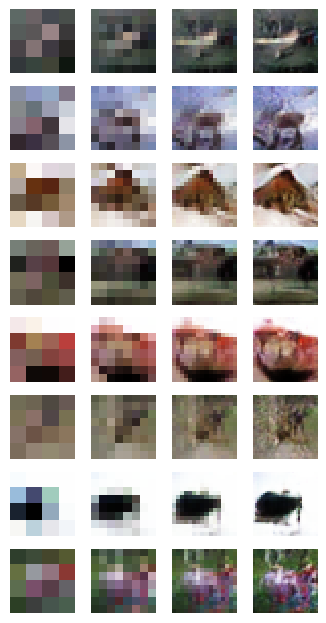

Epoch 35
                        Batch 0 Loss 0.2710
Epoch 35
                        Batch 100 Loss 0.3929
Epoch 35
                        Batch 200 Loss 0.2206
Epoch 35
                        Batch 300 Loss 0.3423
Epoch 35
                        Batch 400 Loss 0.3908
Epoch 35
                        Batch 500 Loss 0.4270
Epoch 35
                        Batch 600 Loss 0.3352
Epoch 35
                        Batch 700 Loss 0.1687
Epoch 35
                        Batch 800 Loss 0.2814
Epoch 35
                        Batch 900 Loss 0.3828
Epoch 35
                        Batch 1000 Loss 0.4689
Epoch 35
                        Batch 1100 Loss 0.2565
Epoch 35
                        Batch 1200 Loss 0.2162
Epoch 35
                        Batch 1300 Loss 0.3241
Epoch 35
                        Batch 1400 Loss 0.4172
Epoch 35
                        Batch 1500 Loss 0.2230
Epoch 35
                        Batch 1600 Loss 0.3089
Epoch 35
                        Batch 1700 Loss 0.3070
Epoc

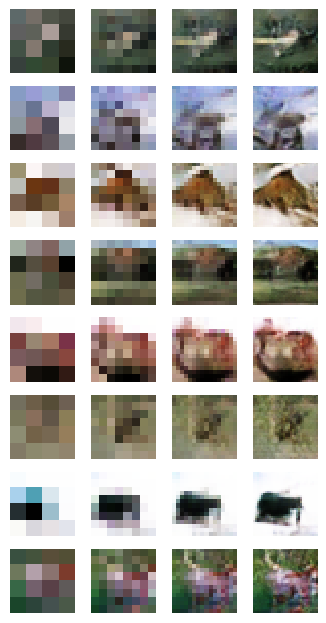

Epoch 36
                        Batch 0 Loss 0.3368
Epoch 36
                        Batch 100 Loss 0.4025
Epoch 36
                        Batch 200 Loss 0.3494
Epoch 36
                        Batch 300 Loss 0.3107
Epoch 36
                        Batch 400 Loss 0.4107
Epoch 36
                        Batch 500 Loss 0.2561
Epoch 36
                        Batch 600 Loss 0.2777
Epoch 36
                        Batch 700 Loss 0.4387
Epoch 36
                        Batch 800 Loss 0.4978
Epoch 36
                        Batch 900 Loss 0.3869
Epoch 36
                        Batch 1000 Loss 0.2988
Epoch 36
                        Batch 1100 Loss 0.3568
Epoch 36
                        Batch 1200 Loss 0.3193
Epoch 36
                        Batch 1300 Loss 0.2087
Epoch 36
                        Batch 1400 Loss 0.4569
Epoch 36
                        Batch 1500 Loss 0.2075
Epoch 36
                        Batch 1600 Loss 0.1733
Epoch 36
                        Batch 1700 Loss 0.3260
Epoc

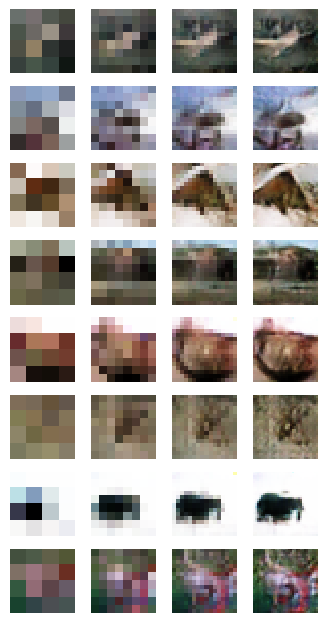

Epoch 37
                        Batch 0 Loss 0.3923
Epoch 37
                        Batch 100 Loss 0.1709
Epoch 37
                        Batch 200 Loss 0.2015
Epoch 37
                        Batch 300 Loss 0.1984
Epoch 37
                        Batch 400 Loss 0.3252
Epoch 37
                        Batch 500 Loss 0.3514
Epoch 37
                        Batch 600 Loss 0.2300
Epoch 37
                        Batch 700 Loss 0.2674
Epoch 37
                        Batch 800 Loss 0.2900
Epoch 37
                        Batch 900 Loss 0.2547
Epoch 37
                        Batch 1000 Loss 0.3236
Epoch 37
                        Batch 1100 Loss 0.2631
Epoch 37
                        Batch 1200 Loss 0.2688
Epoch 37
                        Batch 1300 Loss 0.3297
Epoch 37
                        Batch 1400 Loss 0.3838
Epoch 37
                        Batch 1500 Loss 0.3685
Epoch 37
                        Batch 1600 Loss 0.3436
Epoch 37
                        Batch 1700 Loss 0.3095
Epoc

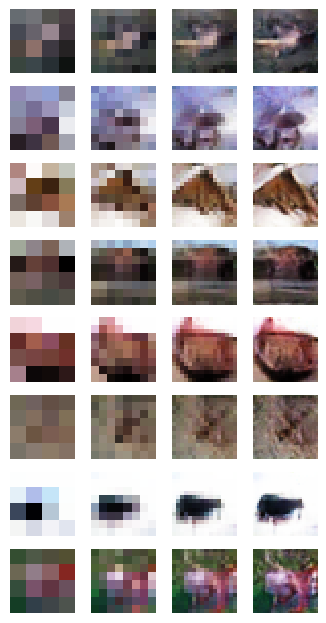

Epoch 38
                        Batch 0 Loss 0.4951
Epoch 38
                        Batch 100 Loss 0.4376
Epoch 38
                        Batch 200 Loss 0.5559
Epoch 38
                        Batch 300 Loss 0.4902
Epoch 38
                        Batch 400 Loss 0.3181
Epoch 38
                        Batch 500 Loss 0.1739
Epoch 38
                        Batch 600 Loss 0.1946
Epoch 38
                        Batch 700 Loss 0.2505
Epoch 38
                        Batch 800 Loss 0.2823
Epoch 38
                        Batch 900 Loss 0.5973
Epoch 38
                        Batch 1000 Loss 0.5003
Epoch 38
                        Batch 1100 Loss 0.3680
Epoch 38
                        Batch 1200 Loss 0.3706
Epoch 38
                        Batch 1300 Loss 0.3711
Epoch 38
                        Batch 1400 Loss 0.4760
Epoch 38
                        Batch 1500 Loss 0.4035
Epoch 38
                        Batch 1600 Loss 0.3183
Epoch 38
                        Batch 1700 Loss 0.2071
Epoc

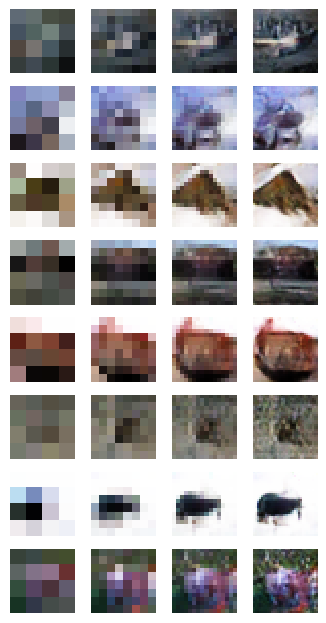

Epoch 39
                        Batch 0 Loss 0.3853
Epoch 39
                        Batch 100 Loss 0.5947
Epoch 39
                        Batch 200 Loss 0.3507
Epoch 39
                        Batch 300 Loss 0.2995
Epoch 39
                        Batch 400 Loss 0.3738
Epoch 39
                        Batch 500 Loss 0.4808
Epoch 39
                        Batch 600 Loss 0.3028
Epoch 39
                        Batch 700 Loss 0.4321
Epoch 39
                        Batch 800 Loss 0.1574
Epoch 39
                        Batch 900 Loss 0.2401
Epoch 39
                        Batch 1000 Loss 0.3490
Epoch 39
                        Batch 1100 Loss 0.3484
Epoch 39
                        Batch 1200 Loss 0.2194
Epoch 39
                        Batch 1300 Loss 0.4579
Epoch 39
                        Batch 1400 Loss 0.5469
Epoch 39
                        Batch 1500 Loss 0.5020
Epoch 39
                        Batch 1600 Loss 0.3034
Epoch 39
                        Batch 1700 Loss 0.3415
Epoc

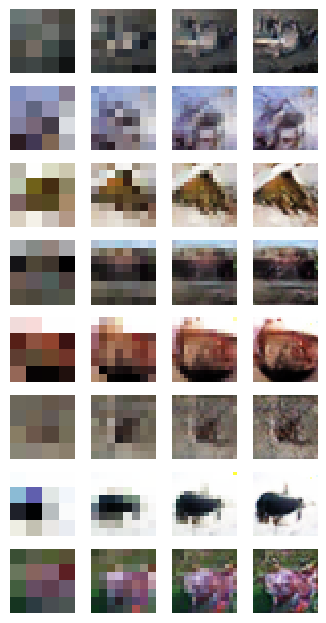

Epoch 40
                        Batch 0 Loss 0.2538
Epoch 40
                        Batch 100 Loss 0.2211
Epoch 40
                        Batch 200 Loss 0.3222
Epoch 40
                        Batch 300 Loss 0.3938
Epoch 40
                        Batch 400 Loss 0.2823
Epoch 40
                        Batch 500 Loss 0.1751
Epoch 40
                        Batch 600 Loss 0.3571
Epoch 40
                        Batch 700 Loss 0.3905
Epoch 40
                        Batch 800 Loss 0.1000
Epoch 40
                        Batch 900 Loss 0.3696
Epoch 40
                        Batch 1000 Loss 0.3881
Epoch 40
                        Batch 1100 Loss 0.3360
Epoch 40
                        Batch 1200 Loss 0.3871
Epoch 40
                        Batch 1300 Loss 0.3680
Epoch 40
                        Batch 1400 Loss 0.4150
Epoch 40
                        Batch 1500 Loss 0.4916
Epoch 40
                        Batch 1600 Loss 0.5105
Epoch 40
                        Batch 1700 Loss 0.3904
Epoc

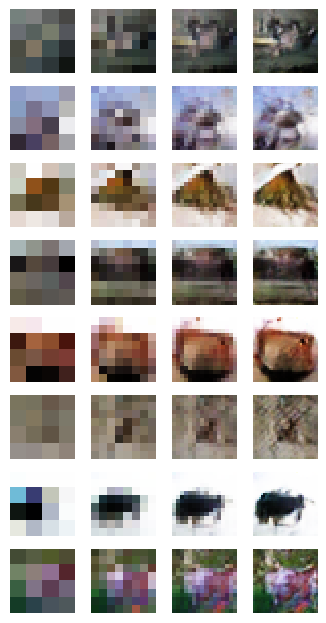

Epoch 41
                        Batch 0 Loss 0.3258
Epoch 41
                        Batch 100 Loss 0.1944
Epoch 41
                        Batch 200 Loss 0.1419
Epoch 41
                        Batch 300 Loss 0.4305
Epoch 41
                        Batch 400 Loss 0.2880
Epoch 41
                        Batch 500 Loss 0.3344
Epoch 41
                        Batch 600 Loss 0.2857
Epoch 41
                        Batch 700 Loss 0.3111
Epoch 41
                        Batch 800 Loss 0.3304
Epoch 41
                        Batch 900 Loss 0.1353
Epoch 41
                        Batch 1000 Loss 0.4126
Epoch 41
                        Batch 1100 Loss 0.3997
Epoch 41
                        Batch 1200 Loss 0.3451
Epoch 41
                        Batch 1300 Loss 0.4098
Epoch 41
                        Batch 1400 Loss 0.4692
Epoch 41
                        Batch 1500 Loss 0.3911
Epoch 41
                        Batch 1600 Loss 0.2983
Epoch 41
                        Batch 1700 Loss 0.3398
Epoc

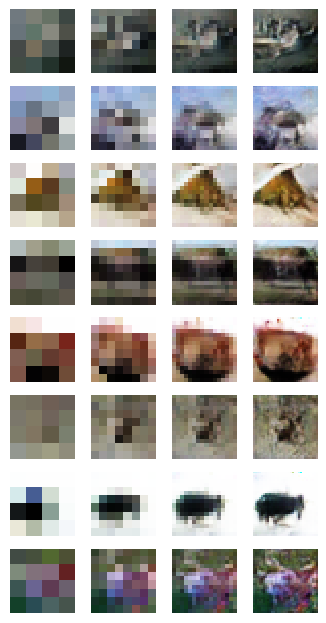

Epoch 42
                        Batch 0 Loss 0.3345
Epoch 42
                        Batch 100 Loss 0.3935
Epoch 42
                        Batch 200 Loss 0.4814
Epoch 42
                        Batch 300 Loss 0.3444
Epoch 42
                        Batch 400 Loss 0.3501
Epoch 42
                        Batch 500 Loss 0.3431
Epoch 42
                        Batch 600 Loss 0.4239
Epoch 42
                        Batch 700 Loss 0.3884
Epoch 42
                        Batch 800 Loss 0.1872
Epoch 42
                        Batch 900 Loss 0.2007
Epoch 42
                        Batch 1000 Loss 0.1146
Epoch 42
                        Batch 1100 Loss 0.2737
Epoch 42
                        Batch 1200 Loss 0.3578
Epoch 42
                        Batch 1300 Loss 0.2461
Epoch 42
                        Batch 1400 Loss 0.2458
Epoch 42
                        Batch 1500 Loss 0.4216
Epoch 42
                        Batch 1600 Loss 0.2688
Epoch 42
                        Batch 1700 Loss 0.4197
Epoc

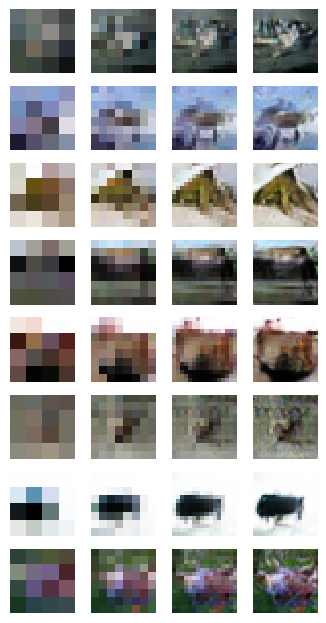

Epoch 43
                        Batch 0 Loss 0.4215
Epoch 43
                        Batch 100 Loss 0.4623
Epoch 43
                        Batch 200 Loss 0.3333
Epoch 43
                        Batch 300 Loss 0.4485
Epoch 43
                        Batch 400 Loss 0.2363
Epoch 43
                        Batch 500 Loss 0.5811
Epoch 43
                        Batch 600 Loss 0.2249
Epoch 43
                        Batch 700 Loss 0.3899
Epoch 43
                        Batch 800 Loss 0.3923
Epoch 43
                        Batch 900 Loss 0.3082
Epoch 43
                        Batch 1000 Loss 0.5014
Epoch 43
                        Batch 1100 Loss 0.3497
Epoch 43
                        Batch 1200 Loss 0.2546
Epoch 43
                        Batch 1300 Loss 0.3697
Epoch 43
                        Batch 1400 Loss 0.4763
Epoch 43
                        Batch 1500 Loss 0.2057
Epoch 43
                        Batch 1600 Loss 0.1502
Epoch 43
                        Batch 1700 Loss 0.2268
Epoc

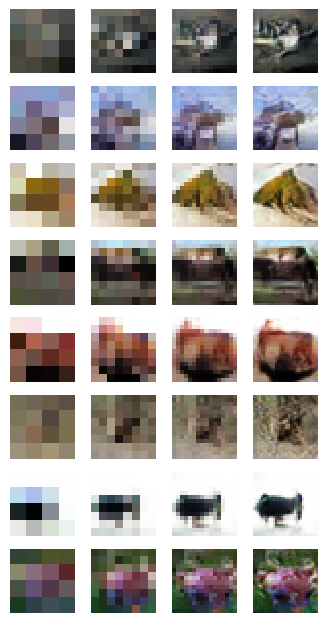

Epoch 44
                        Batch 0 Loss 0.3931
Epoch 44
                        Batch 100 Loss 0.4851
Epoch 44
                        Batch 200 Loss 0.4683
Epoch 44
                        Batch 300 Loss 0.3314
Epoch 44
                        Batch 400 Loss 0.2440
Epoch 44
                        Batch 500 Loss 0.2021
Epoch 44
                        Batch 600 Loss 0.4197
Epoch 44
                        Batch 700 Loss 0.5305
Epoch 44
                        Batch 800 Loss 0.5006
Epoch 44
                        Batch 900 Loss 0.2739
Epoch 44
                        Batch 1000 Loss 0.4779
Epoch 44
                        Batch 1100 Loss 0.3526
Epoch 44
                        Batch 1200 Loss 0.4946
Epoch 44
                        Batch 1300 Loss 0.2747
Epoch 44
                        Batch 1400 Loss 0.3519
Epoch 44
                        Batch 1500 Loss 0.2994
Epoch 44
                        Batch 1600 Loss 0.2846
Epoch 44
                        Batch 1700 Loss 0.3909
Epoc

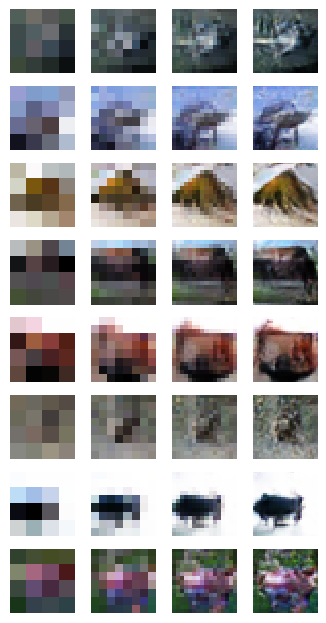

Epoch 45
                        Batch 0 Loss 0.3900
Epoch 45
                        Batch 100 Loss 0.2991
Epoch 45
                        Batch 200 Loss 0.4713
Epoch 45
                        Batch 300 Loss 0.2522
Epoch 45
                        Batch 400 Loss 0.2791
Epoch 45
                        Batch 500 Loss 0.4150
Epoch 45
                        Batch 600 Loss 0.3618
Epoch 45
                        Batch 700 Loss 0.4375
Epoch 45
                        Batch 800 Loss 0.4270
Epoch 45
                        Batch 900 Loss 0.1929
Epoch 45
                        Batch 1000 Loss 0.3902
Epoch 45
                        Batch 1100 Loss 0.4581
Epoch 45
                        Batch 1200 Loss 0.4425
Epoch 45
                        Batch 1300 Loss 0.4423
Epoch 45
                        Batch 1400 Loss 0.2126
Epoch 45
                        Batch 1500 Loss 0.2042
Epoch 45
                        Batch 1600 Loss 0.2134
Epoch 45
                        Batch 1700 Loss 0.3529
Epoc

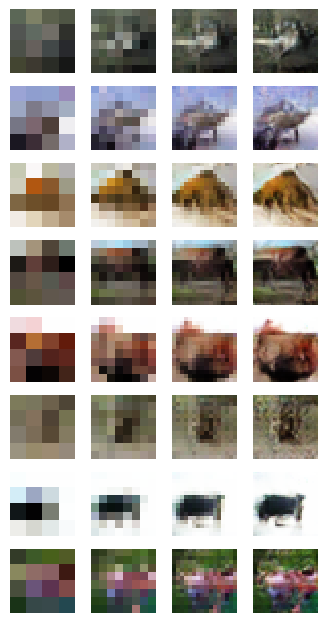

Epoch 46
                        Batch 0 Loss 0.2256
Epoch 46
                        Batch 100 Loss 0.3577
Epoch 46
                        Batch 200 Loss 0.2878
Epoch 46
                        Batch 300 Loss 0.4210
Epoch 46
                        Batch 400 Loss 0.5519
Epoch 46
                        Batch 500 Loss 0.4258
Epoch 46
                        Batch 600 Loss 0.1518
Epoch 46
                        Batch 700 Loss 0.8114
Epoch 46
                        Batch 800 Loss 0.3644
Epoch 46
                        Batch 900 Loss 0.2501
Epoch 46
                        Batch 1000 Loss 0.3926
Epoch 46
                        Batch 1100 Loss 0.4395
Epoch 46
                        Batch 1200 Loss 0.4364
Epoch 46
                        Batch 1300 Loss 0.1788
Epoch 46
                        Batch 1400 Loss 0.2740
Epoch 46
                        Batch 1500 Loss 0.3786
Epoch 46
                        Batch 1600 Loss 0.2794
Epoch 46
                        Batch 1700 Loss 0.2791
Epoc

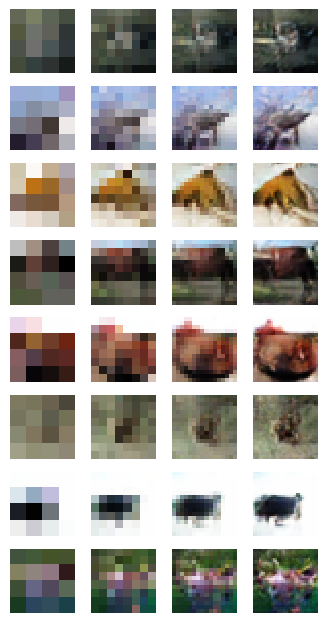

Epoch 47
                        Batch 0 Loss 0.6312
Epoch 47
                        Batch 100 Loss 0.5709
Epoch 47
                        Batch 200 Loss 0.2983
Epoch 47
                        Batch 300 Loss 0.4562
Epoch 47
                        Batch 400 Loss 0.3822
Epoch 47
                        Batch 500 Loss 0.3586
Epoch 47
                        Batch 600 Loss 0.5706
Epoch 47
                        Batch 700 Loss 0.1772
Epoch 47
                        Batch 800 Loss 0.2699
Epoch 47
                        Batch 900 Loss 0.2062
Epoch 47
                        Batch 1000 Loss 0.3662
Epoch 47
                        Batch 1100 Loss 0.5157
Epoch 47
                        Batch 1200 Loss 0.3478
Epoch 47
                        Batch 1300 Loss 0.1690
Epoch 47
                        Batch 1400 Loss 0.2691
Epoch 47
                        Batch 1500 Loss 0.1039
Epoch 47
                        Batch 1600 Loss 0.4615
Epoch 47
                        Batch 1700 Loss 0.2655
Epoc

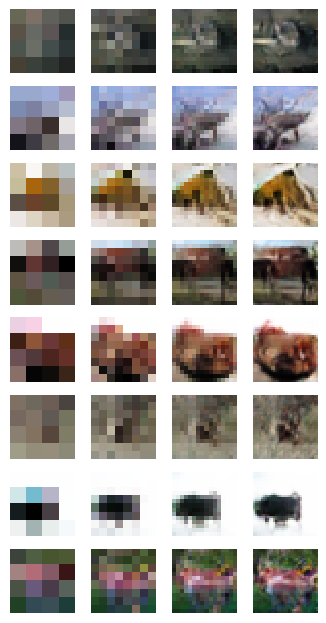

Epoch 48
                        Batch 0 Loss 0.3185
Epoch 48
                        Batch 100 Loss 0.2734
Epoch 48
                        Batch 200 Loss 0.3903
Epoch 48
                        Batch 300 Loss 0.5018
Epoch 48
                        Batch 400 Loss 0.2845
Epoch 48
                        Batch 500 Loss 0.2251
Epoch 48
                        Batch 600 Loss 0.3662
Epoch 48
                        Batch 700 Loss 0.5201
Epoch 48
                        Batch 800 Loss 0.5034
Epoch 48
                        Batch 900 Loss 0.4324
Epoch 48
                        Batch 1000 Loss 0.2682
Epoch 48
                        Batch 1100 Loss 0.3614
Epoch 48
                        Batch 1200 Loss 0.4335
Epoch 48
                        Batch 1300 Loss 0.3584
Epoch 48
                        Batch 1400 Loss 0.3603
Epoch 48
                        Batch 1500 Loss 0.4640
Epoch 48
                        Batch 1600 Loss 0.3588
Epoch 48
                        Batch 1700 Loss 0.2140
Epoc

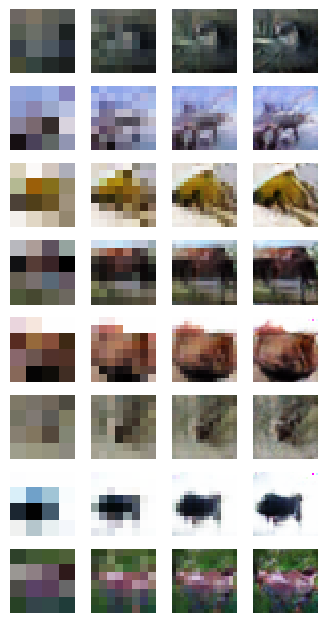

Epoch 49
                        Batch 0 Loss 0.1931
Epoch 49
                        Batch 100 Loss 0.4280
Epoch 49
                        Batch 200 Loss 0.2254
Epoch 49
                        Batch 300 Loss 0.2732
Epoch 49
                        Batch 400 Loss 0.2276
Epoch 49
                        Batch 500 Loss 0.2306
Epoch 49
                        Batch 600 Loss 0.3395
Epoch 49
                        Batch 700 Loss 0.3494
Epoch 49
                        Batch 800 Loss 0.2611
Epoch 49
                        Batch 900 Loss 0.5210
Epoch 49
                        Batch 1000 Loss 0.5040
Epoch 49
                        Batch 1100 Loss 0.2648
Epoch 49
                        Batch 1200 Loss 0.3252
Epoch 49
                        Batch 1300 Loss 0.3293
Epoch 49
                        Batch 1400 Loss 0.3928
Epoch 49
                        Batch 1500 Loss 0.2374
Epoch 49
                        Batch 1600 Loss 0.3806
Epoch 49
                        Batch 1700 Loss 0.4535
Epoc

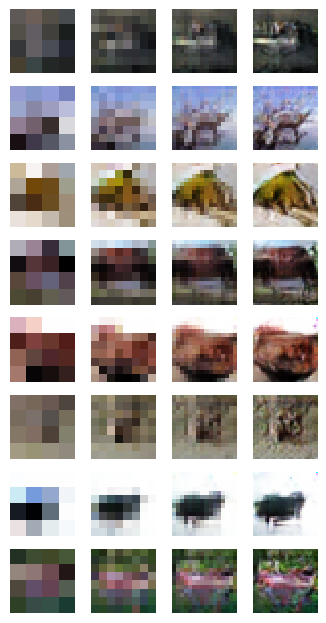

Epoch 50
                        Batch 0 Loss 0.3149
Epoch 50
                        Batch 100 Loss 0.3879
Epoch 50
                        Batch 200 Loss 0.4346
Epoch 50
                        Batch 300 Loss 0.4433
Epoch 50
                        Batch 400 Loss 0.1905
Epoch 50
                        Batch 500 Loss 0.7267
Epoch 50
                        Batch 600 Loss 0.3621
Epoch 50
                        Batch 700 Loss 0.4557
Epoch 50
                        Batch 800 Loss 0.3242
Epoch 50
                        Batch 900 Loss 0.3714
Epoch 50
                        Batch 1000 Loss 0.2564
Epoch 50
                        Batch 1100 Loss 0.4069
Epoch 50
                        Batch 1200 Loss 0.4435
Epoch 50
                        Batch 1300 Loss 0.2888
Epoch 50
                        Batch 1400 Loss 0.3338
Epoch 50
                        Batch 1500 Loss 0.4066
Epoch 50
                        Batch 1600 Loss 0.4179
Epoch 50
                        Batch 1700 Loss 0.4459
Epoc

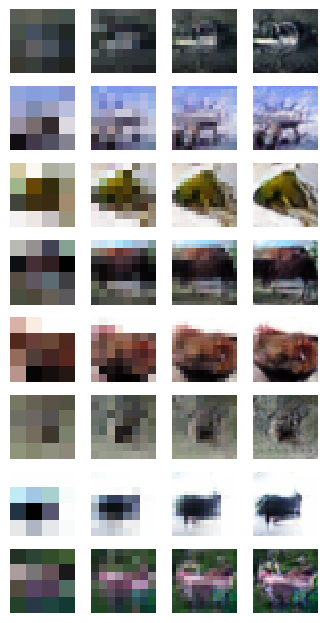

Epoch 51
                        Batch 0 Loss 0.4221
Epoch 51
                        Batch 100 Loss 0.4487
Epoch 51
                        Batch 200 Loss 0.4857
Epoch 51
                        Batch 300 Loss 0.4278
Epoch 51
                        Batch 400 Loss 0.1351
Epoch 51
                        Batch 500 Loss 0.3985
Epoch 51
                        Batch 600 Loss 0.4085
Epoch 51
                        Batch 700 Loss 0.3246
Epoch 51
                        Batch 800 Loss 0.2812
Epoch 51
                        Batch 900 Loss 0.2862
Epoch 51
                        Batch 1000 Loss 0.3745
Epoch 51
                        Batch 1100 Loss 0.3185
Epoch 51
                        Batch 1200 Loss 0.6563
Epoch 51
                        Batch 1300 Loss 0.3264
Epoch 51
                        Batch 1400 Loss 0.3273
Epoch 51
                        Batch 1500 Loss 0.4063
Epoch 51
                        Batch 1600 Loss 0.4500
Epoch 51
                        Batch 1700 Loss 0.1581
Epoc

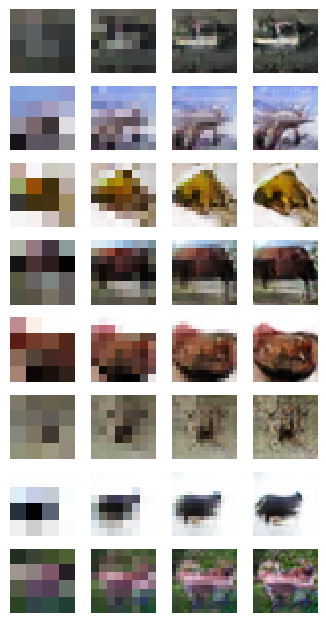

Epoch 52
                        Batch 0 Loss 0.4254
Epoch 52
                        Batch 100 Loss 0.1159
Epoch 52
                        Batch 200 Loss 0.2346
Epoch 52
                        Batch 300 Loss 0.4574
Epoch 52
                        Batch 400 Loss 0.4734
Epoch 52
                        Batch 500 Loss 0.2600
Epoch 52
                        Batch 600 Loss 0.3942
Epoch 52
                        Batch 700 Loss 0.3374
Epoch 52
                        Batch 800 Loss 0.3202
Epoch 52
                        Batch 900 Loss 0.4081
Epoch 52
                        Batch 1000 Loss 0.3264
Epoch 52
                        Batch 1100 Loss 0.5325
Epoch 52
                        Batch 1200 Loss 0.5721
Epoch 52
                        Batch 1300 Loss 0.3524
Epoch 52
                        Batch 1400 Loss 0.4993
Epoch 52
                        Batch 1500 Loss 0.5499
Epoch 52
                        Batch 1600 Loss 0.3363
Epoch 52
                        Batch 1700 Loss 0.3257
Epoc

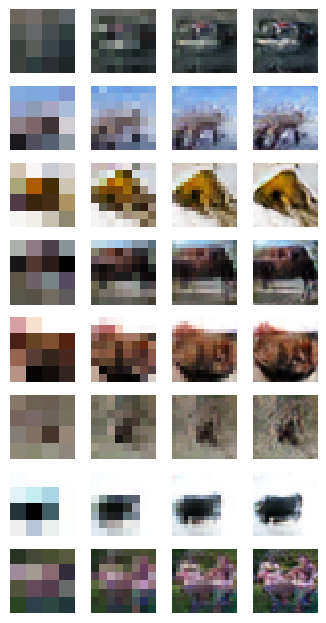

Epoch 53
                        Batch 0 Loss 0.4304
Epoch 53
                        Batch 100 Loss 0.4907
Epoch 53
                        Batch 200 Loss 0.2642
Epoch 53
                        Batch 300 Loss 0.3350
Epoch 53
                        Batch 400 Loss 0.3055
Epoch 53
                        Batch 500 Loss 0.3267
Epoch 53
                        Batch 600 Loss 0.4411
Epoch 53
                        Batch 700 Loss 0.3352
Epoch 53
                        Batch 800 Loss 0.5478
Epoch 53
                        Batch 900 Loss 0.2871
Epoch 53
                        Batch 1000 Loss 0.2955
Epoch 53
                        Batch 1100 Loss 0.3510
Epoch 53
                        Batch 1200 Loss 0.3119
Epoch 53
                        Batch 1300 Loss 0.6192
Epoch 53
                        Batch 1400 Loss 0.2707
Epoch 53
                        Batch 1500 Loss 0.3823
Epoch 53
                        Batch 1600 Loss 0.4417
Epoch 53
                        Batch 1700 Loss 0.3473
Epoc

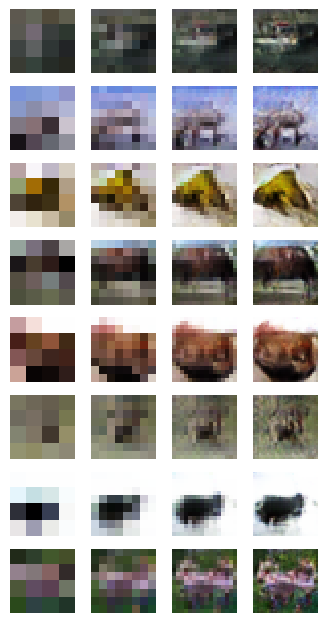

Epoch 54
                        Batch 0 Loss 0.3240
Epoch 54
                        Batch 100 Loss 0.4029
Epoch 54
                        Batch 200 Loss 0.2808
Epoch 54
                        Batch 300 Loss 0.3033
Epoch 54
                        Batch 400 Loss 0.5698
Epoch 54
                        Batch 500 Loss 0.2730
Epoch 54
                        Batch 600 Loss 0.4648
Epoch 54
                        Batch 700 Loss 0.4115
Epoch 54
                        Batch 800 Loss 0.4279
Epoch 54
                        Batch 900 Loss 0.2776
Epoch 54
                        Batch 1000 Loss 0.1112
Epoch 54
                        Batch 1100 Loss 0.3086
Epoch 54
                        Batch 1200 Loss 0.2734
Epoch 54
                        Batch 1300 Loss 0.2268
Epoch 54
                        Batch 1400 Loss 0.4941
Epoch 54
                        Batch 1500 Loss 0.4295
Epoch 54
                        Batch 1600 Loss 0.2742
Epoch 54
                        Batch 1700 Loss 0.3450
Epoc

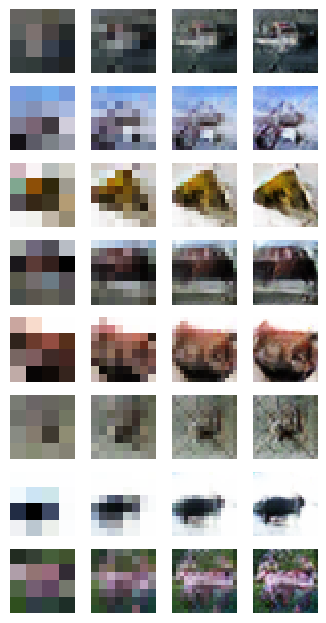

Epoch 55
                        Batch 0 Loss 0.2362
Epoch 55
                        Batch 100 Loss 0.4100
Epoch 55
                        Batch 200 Loss 0.0922
Epoch 55
                        Batch 300 Loss 0.4277
Epoch 55
                        Batch 400 Loss 0.4241
Epoch 55
                        Batch 500 Loss 0.2073
Epoch 55
                        Batch 600 Loss 0.4175
Epoch 55
                        Batch 700 Loss 0.3567
Epoch 55
                        Batch 800 Loss 0.3068
Epoch 55
                        Batch 900 Loss 0.2124
Epoch 55
                        Batch 1000 Loss 0.3612
Epoch 55
                        Batch 1100 Loss 0.2904
Epoch 55
                        Batch 1200 Loss 0.3895
Epoch 55
                        Batch 1300 Loss 0.5024
Epoch 55
                        Batch 1400 Loss 0.3177
Epoch 55
                        Batch 1500 Loss 0.2067
Epoch 55
                        Batch 1600 Loss 0.2571
Epoch 55
                        Batch 1700 Loss 0.5265
Epoc

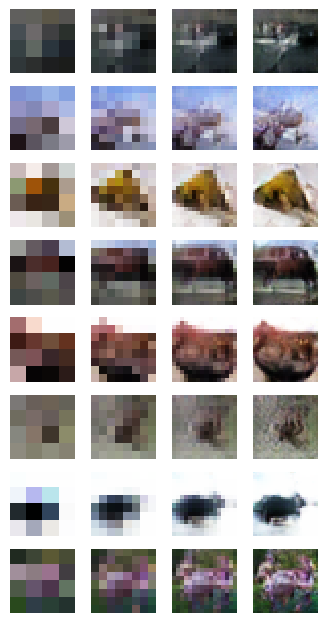

Epoch 56
                        Batch 0 Loss 0.2838
Epoch 56
                        Batch 100 Loss 0.3779
Epoch 56
                        Batch 200 Loss 0.4393
Epoch 56
                        Batch 300 Loss 0.3367
Epoch 56
                        Batch 400 Loss 0.2446
Epoch 56
                        Batch 500 Loss 0.3135
Epoch 56
                        Batch 600 Loss 0.9983
Epoch 56
                        Batch 700 Loss 0.2424
Epoch 56
                        Batch 800 Loss 0.2830
Epoch 56
                        Batch 900 Loss 0.2492
Epoch 56
                        Batch 1000 Loss 0.4025
Epoch 56
                        Batch 1100 Loss 0.3568
Epoch 56
                        Batch 1200 Loss 0.0952
Epoch 56
                        Batch 1300 Loss 0.2088
Epoch 56
                        Batch 1400 Loss 0.4307
Epoch 56
                        Batch 1500 Loss 0.4169
Epoch 56
                        Batch 1600 Loss 0.3034
Epoch 56
                        Batch 1700 Loss 0.2921
Epoc

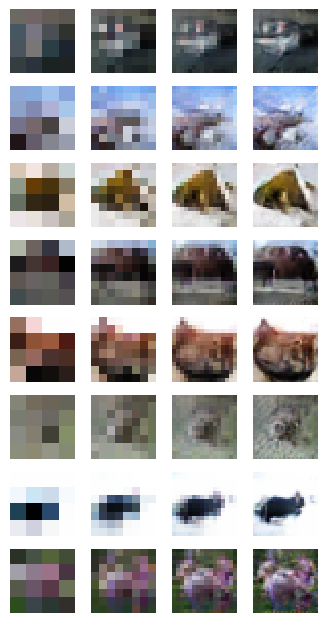

Epoch 57
                        Batch 0 Loss 0.2563
Epoch 57
                        Batch 100 Loss 0.5971
Epoch 57
                        Batch 200 Loss 0.2397
Epoch 57
                        Batch 300 Loss 0.4290
Epoch 57
                        Batch 400 Loss 0.2780
Epoch 57
                        Batch 500 Loss 0.2754
Epoch 57
                        Batch 600 Loss 0.3737
Epoch 57
                        Batch 700 Loss 0.5921
Epoch 57
                        Batch 800 Loss 0.4186
Epoch 57
                        Batch 900 Loss 0.3962
Epoch 57
                        Batch 1000 Loss 0.3618
Epoch 57
                        Batch 1100 Loss 0.4854
Epoch 57
                        Batch 1200 Loss 0.2628
Epoch 57
                        Batch 1300 Loss 0.5477
Epoch 57
                        Batch 1400 Loss 0.2444
Epoch 57
                        Batch 1500 Loss 0.3130
Epoch 57
                        Batch 1600 Loss 0.2466
Epoch 57
                        Batch 1700 Loss 0.3472
Epoc

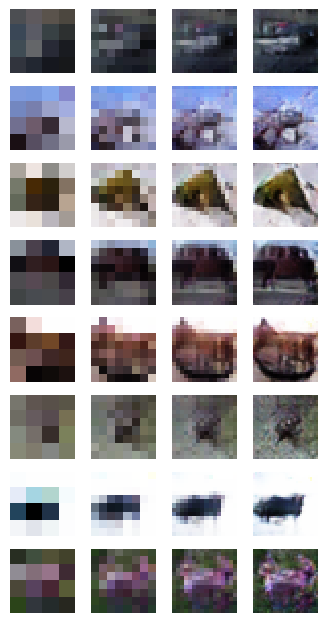

Epoch 58
                        Batch 0 Loss 0.3102
Epoch 58
                        Batch 100 Loss 0.3581
Epoch 58
                        Batch 200 Loss 0.4390
Epoch 58
                        Batch 300 Loss 0.4754
Epoch 58
                        Batch 400 Loss 0.3072
Epoch 58
                        Batch 500 Loss 0.4517
Epoch 58
                        Batch 600 Loss 0.3890
Epoch 58
                        Batch 700 Loss 0.3803
Epoch 58
                        Batch 800 Loss 0.4716
Epoch 58
                        Batch 900 Loss 0.6741
Epoch 58
                        Batch 1000 Loss 0.3515
Epoch 58
                        Batch 1100 Loss 0.4079
Epoch 58
                        Batch 1200 Loss 0.3191
Epoch 58
                        Batch 1300 Loss 0.4497
Epoch 58
                        Batch 1400 Loss 0.3463
Epoch 58
                        Batch 1500 Loss 0.2807
Epoch 58
                        Batch 1600 Loss 0.6112
Epoch 58
                        Batch 1700 Loss 0.4498
Epoc

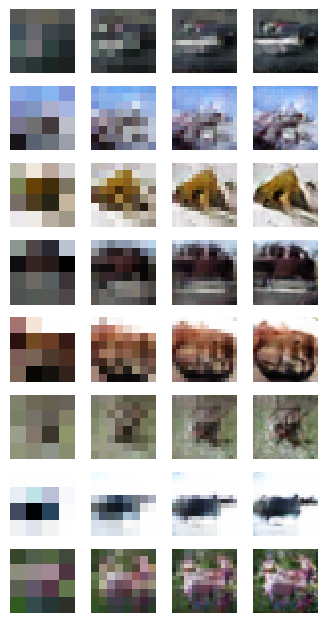

Epoch 59
                        Batch 0 Loss 0.2682
Epoch 59
                        Batch 100 Loss 0.3309
Epoch 59
                        Batch 200 Loss 0.4676
Epoch 59
                        Batch 300 Loss 0.3573
Epoch 59
                        Batch 400 Loss 0.2304
Epoch 59
                        Batch 500 Loss 0.2777
Epoch 59
                        Batch 600 Loss 0.4790
Epoch 59
                        Batch 700 Loss 0.3614
Epoch 59
                        Batch 800 Loss 0.2688
Epoch 59
                        Batch 900 Loss 0.4146
Epoch 59
                        Batch 1000 Loss 0.3412
Epoch 59
                        Batch 1100 Loss 0.3504
Epoch 59
                        Batch 1200 Loss 0.5710
Epoch 59
                        Batch 1300 Loss 0.3560
Epoch 59
                        Batch 1400 Loss 0.4697
Epoch 59
                        Batch 1500 Loss 0.3862
Epoch 59
                        Batch 1600 Loss 0.3826
Epoch 59
                        Batch 1700 Loss 0.2116
Epoc

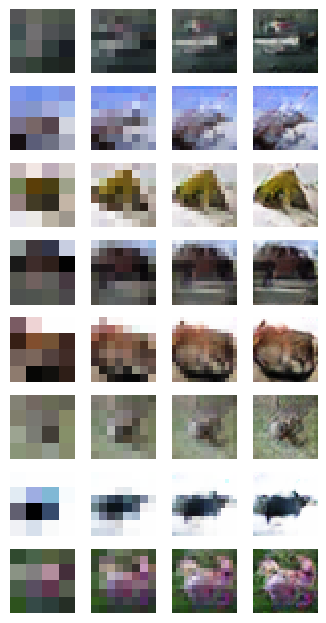

Epoch 60
                        Batch 0 Loss 0.5582
Epoch 60
                        Batch 100 Loss 0.2189
Epoch 60
                        Batch 200 Loss 0.3232
Epoch 60
                        Batch 300 Loss 0.3421
Epoch 60
                        Batch 400 Loss 0.4056
Epoch 60
                        Batch 500 Loss 0.3405
Epoch 60
                        Batch 600 Loss 0.7341
Epoch 60
                        Batch 700 Loss 0.1756
Epoch 60
                        Batch 800 Loss 0.5169
Epoch 60
                        Batch 900 Loss 0.2082
Epoch 60
                        Batch 1000 Loss 0.3459
Epoch 60
                        Batch 1100 Loss 0.4783
Epoch 60
                        Batch 1200 Loss 0.3984
Epoch 60
                        Batch 1300 Loss 0.3129
Epoch 60
                        Batch 1400 Loss 0.3416
Epoch 60
                        Batch 1500 Loss 0.5003
Epoch 60
                        Batch 1600 Loss 0.2116
Epoch 60
                        Batch 1700 Loss 0.4217
Epoc

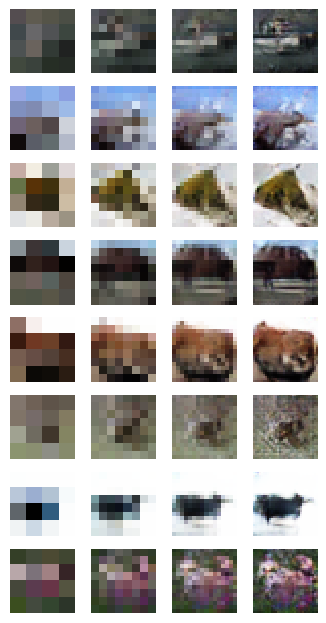

Epoch 61
                        Batch 0 Loss 0.5455
Epoch 61
                        Batch 100 Loss 0.2183
Epoch 61
                        Batch 200 Loss 0.3633
Epoch 61
                        Batch 300 Loss 0.4352
Epoch 61
                        Batch 400 Loss 0.3442
Epoch 61
                        Batch 500 Loss 0.3701
Epoch 61
                        Batch 600 Loss 0.5399
Epoch 61
                        Batch 700 Loss 0.3028
Epoch 61
                        Batch 800 Loss 0.2711
Epoch 61
                        Batch 900 Loss 0.1914
Epoch 61
                        Batch 1000 Loss 0.3817
Epoch 61
                        Batch 1100 Loss 0.3196
Epoch 61
                        Batch 1200 Loss 0.4103
Epoch 61
                        Batch 1300 Loss 0.2618
Epoch 61
                        Batch 1400 Loss 0.1141
Epoch 61
                        Batch 1500 Loss 0.4793
Epoch 61
                        Batch 1600 Loss 0.2581
Epoch 61
                        Batch 1700 Loss 0.3611
Epoc

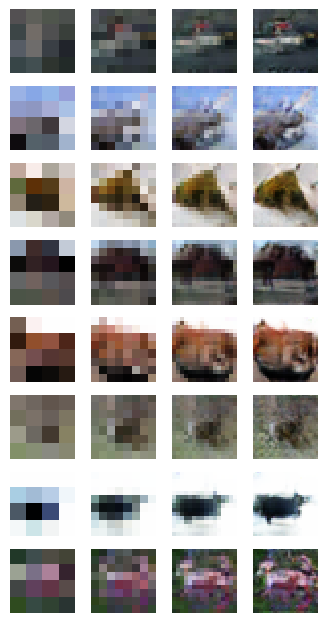

Epoch 62
                        Batch 0 Loss 0.5726
Epoch 62
                        Batch 100 Loss 0.4091
Epoch 62
                        Batch 200 Loss 0.5081
Epoch 62
                        Batch 300 Loss 0.2000
Epoch 62
                        Batch 400 Loss 0.2093
Epoch 62
                        Batch 500 Loss 0.4896
Epoch 62
                        Batch 600 Loss 0.1199
Epoch 62
                        Batch 700 Loss 0.3262
Epoch 62
                        Batch 800 Loss 0.6782
Epoch 62
                        Batch 900 Loss 0.4716
Epoch 62
                        Batch 1000 Loss 0.4782
Epoch 62
                        Batch 1100 Loss 0.4401
Epoch 62
                        Batch 1200 Loss 0.4370
Epoch 62
                        Batch 1300 Loss 0.4599
Epoch 62
                        Batch 1400 Loss 0.4168
Epoch 62
                        Batch 1500 Loss 0.4626
Epoch 62
                        Batch 1600 Loss 0.5439
Epoch 62
                        Batch 1700 Loss 0.2762
Epoc

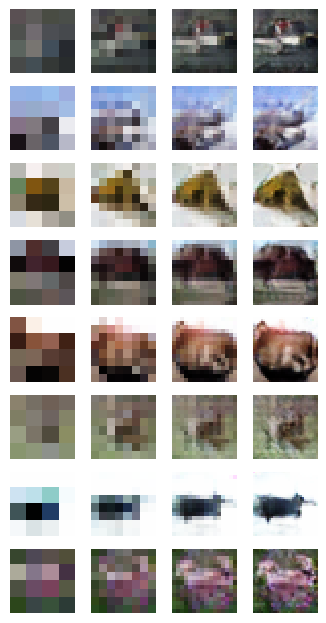

Epoch 63
                        Batch 0 Loss 0.2866
Epoch 63
                        Batch 100 Loss 0.3762
Epoch 63
                        Batch 200 Loss 0.3078
Epoch 63
                        Batch 300 Loss 0.3270
Epoch 63
                        Batch 400 Loss 0.5125
Epoch 63
                        Batch 500 Loss 0.4666
Epoch 63
                        Batch 600 Loss 0.6244
Epoch 63
                        Batch 700 Loss 0.5262
Epoch 63
                        Batch 800 Loss 0.4904
Epoch 63
                        Batch 900 Loss 0.3342
Epoch 63
                        Batch 1000 Loss 0.5665
Epoch 63
                        Batch 1100 Loss 0.2672
Epoch 63
                        Batch 1200 Loss 0.1543
Epoch 63
                        Batch 1300 Loss 0.5606
Epoch 63
                        Batch 1400 Loss 0.1007
Epoch 63
                        Batch 1500 Loss 0.3135
Epoch 63
                        Batch 1600 Loss 0.3704
Epoch 63
                        Batch 1700 Loss 0.2023
Epoc

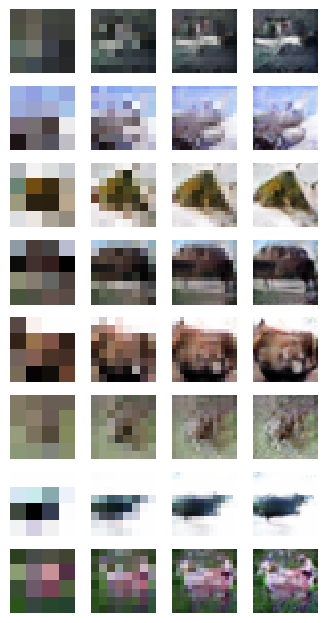

Epoch 64
                        Batch 0 Loss 0.2854
Epoch 64
                        Batch 100 Loss 0.2863
Epoch 64
                        Batch 200 Loss 0.3250
Epoch 64
                        Batch 300 Loss 0.4164
Epoch 64
                        Batch 400 Loss 0.2868
Epoch 64
                        Batch 500 Loss 0.6138
Epoch 64
                        Batch 600 Loss 0.2067
Epoch 64
                        Batch 700 Loss 0.4756
Epoch 64
                        Batch 800 Loss 0.4043
Epoch 64
                        Batch 900 Loss 0.6549
Epoch 64
                        Batch 1000 Loss 0.4531
Epoch 64
                        Batch 1100 Loss 0.1732
Epoch 64
                        Batch 1200 Loss 0.2719
Epoch 64
                        Batch 1300 Loss 0.4826
Epoch 64
                        Batch 1400 Loss 0.4612
Epoch 64
                        Batch 1500 Loss 0.3389
Epoch 64
                        Batch 1600 Loss 0.3061
Epoch 64
                        Batch 1700 Loss 0.4257
Epoc

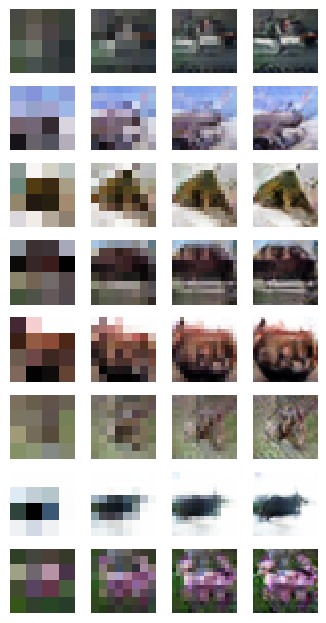

Epoch 65
                        Batch 0 Loss 0.4713
Epoch 65
                        Batch 100 Loss 0.6074
Epoch 65
                        Batch 200 Loss 0.2498
Epoch 65
                        Batch 300 Loss 0.4208
Epoch 65
                        Batch 400 Loss 0.3616
Epoch 65
                        Batch 500 Loss 0.4182
Epoch 65
                        Batch 600 Loss 0.3896
Epoch 65
                        Batch 700 Loss 0.5251
Epoch 65
                        Batch 800 Loss 0.4232
Epoch 65
                        Batch 900 Loss 0.3589
Epoch 65
                        Batch 1000 Loss 0.4428
Epoch 65
                        Batch 1100 Loss 0.2754
Epoch 65
                        Batch 1200 Loss 0.5620
Epoch 65
                        Batch 1300 Loss 0.2420
Epoch 65
                        Batch 1400 Loss 0.3339
Epoch 65
                        Batch 1500 Loss 0.4701
Epoch 65
                        Batch 1600 Loss 0.3313
Epoch 65
                        Batch 1700 Loss 0.3674
Epoc

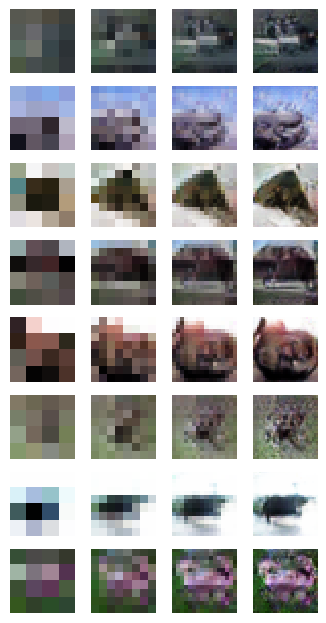

Epoch 66
                        Batch 0 Loss 0.3902
Epoch 66
                        Batch 100 Loss 0.3909
Epoch 66
                        Batch 200 Loss 0.3164
Epoch 66
                        Batch 300 Loss 0.2762
Epoch 66
                        Batch 400 Loss 0.3118
Epoch 66
                        Batch 500 Loss 0.3656
Epoch 66
                        Batch 600 Loss 0.2258
Epoch 66
                        Batch 700 Loss 0.3698
Epoch 66
                        Batch 800 Loss 0.4639
Epoch 66
                        Batch 900 Loss 0.3085
Epoch 66
                        Batch 1000 Loss 0.2800
Epoch 66
                        Batch 1100 Loss 0.2986
Epoch 66
                        Batch 1200 Loss 0.3859
Epoch 66
                        Batch 1300 Loss 0.4804
Epoch 66
                        Batch 1400 Loss 0.3122
Epoch 66
                        Batch 1500 Loss 0.2255
Epoch 66
                        Batch 1600 Loss 0.3487
Epoch 66
                        Batch 1700 Loss 0.2091
Epoc

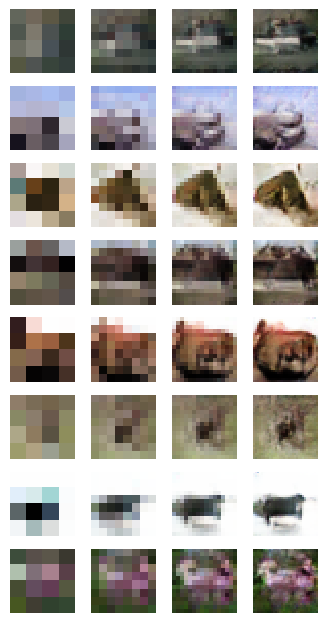

Epoch 67
                        Batch 0 Loss 0.5125
Epoch 67
                        Batch 100 Loss 0.2688
Epoch 67
                        Batch 200 Loss 0.4788
Epoch 67
                        Batch 300 Loss 0.2710
Epoch 67
                        Batch 400 Loss 0.2648
Epoch 67
                        Batch 500 Loss 0.4279
Epoch 67
                        Batch 600 Loss 0.5698
Epoch 67
                        Batch 700 Loss 0.5613
Epoch 67
                        Batch 800 Loss 0.2287
Epoch 67
                        Batch 900 Loss 0.2906
Epoch 67
                        Batch 1000 Loss 0.1353
Epoch 67
                        Batch 1100 Loss 0.2063
Epoch 67
                        Batch 1200 Loss 0.5339
Epoch 67
                        Batch 1300 Loss 0.5788
Epoch 67
                        Batch 1400 Loss 0.3489
Epoch 67
                        Batch 1500 Loss 0.1872
Epoch 67
                        Batch 1600 Loss 0.4548
Epoch 67
                        Batch 1700 Loss 0.4433
Epoc

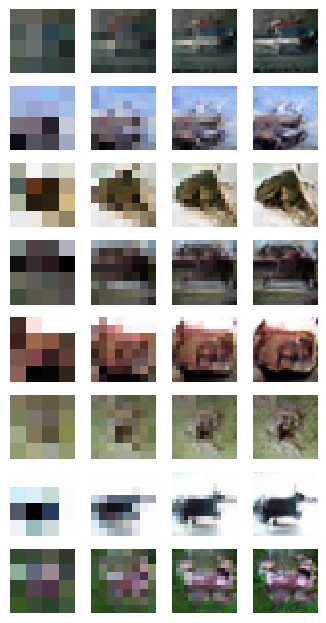

Epoch 68
                        Batch 0 Loss 0.4283
Epoch 68
                        Batch 100 Loss 0.4626
Epoch 68
                        Batch 200 Loss 0.2032
Epoch 68
                        Batch 300 Loss 0.3740
Epoch 68
                        Batch 400 Loss 0.5743
Epoch 68
                        Batch 500 Loss 0.3921
Epoch 68
                        Batch 600 Loss 0.3301
Epoch 68
                        Batch 700 Loss 0.2626
Epoch 68
                        Batch 800 Loss 0.1478
Epoch 68
                        Batch 900 Loss 0.3296
Epoch 68
                        Batch 1000 Loss 0.3777
Epoch 68
                        Batch 1100 Loss 0.2894
Epoch 68
                        Batch 1200 Loss 0.5701
Epoch 68
                        Batch 1300 Loss 0.2426
Epoch 68
                        Batch 1400 Loss 0.3376
Epoch 68
                        Batch 1500 Loss 0.6105
Epoch 68
                        Batch 1600 Loss 0.2748
Epoch 68
                        Batch 1700 Loss 0.3900
Epoc

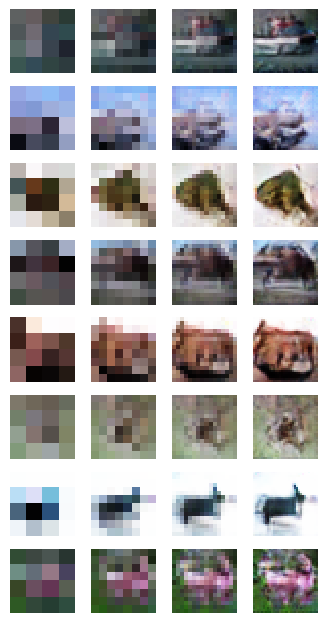

Epoch 69
                        Batch 0 Loss 0.3331
Epoch 69
                        Batch 100 Loss 0.3574
Epoch 69
                        Batch 200 Loss 0.7365
Epoch 69
                        Batch 300 Loss 0.3778
Epoch 69
                        Batch 400 Loss 0.1180
Epoch 69
                        Batch 500 Loss 0.2810
Epoch 69
                        Batch 600 Loss 0.2180
Epoch 69
                        Batch 700 Loss 0.4491
Epoch 69
                        Batch 800 Loss 0.3983
Epoch 69
                        Batch 900 Loss 0.4562
Epoch 69
                        Batch 1000 Loss 0.5150
Epoch 69
                        Batch 1100 Loss 0.3764
Epoch 69
                        Batch 1200 Loss 0.3733
Epoch 69
                        Batch 1300 Loss 0.2534
Epoch 69
                        Batch 1400 Loss 0.5057
Epoch 69
                        Batch 1500 Loss 0.1988
Epoch 69
                        Batch 1600 Loss 0.4152
Epoch 69
                        Batch 1700 Loss 0.3803
Epoc

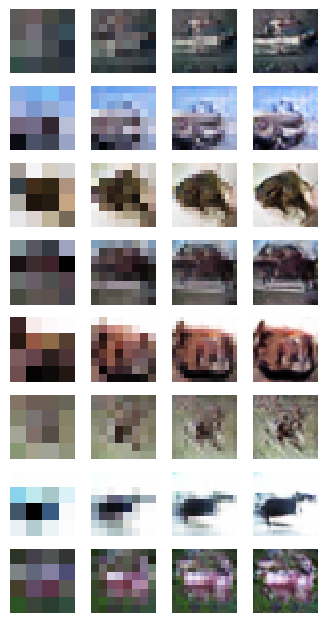

Epoch 70
                        Batch 0 Loss 0.2837
Epoch 70
                        Batch 100 Loss 0.4462
Epoch 70
                        Batch 200 Loss 0.3526
Epoch 70
                        Batch 300 Loss 0.6064
Epoch 70
                        Batch 400 Loss 0.5399
Epoch 70
                        Batch 500 Loss 0.3994
Epoch 70
                        Batch 600 Loss 0.4589
Epoch 70
                        Batch 700 Loss 0.3517
Epoch 70
                        Batch 800 Loss 0.4722
Epoch 70
                        Batch 900 Loss 0.4105
Epoch 70
                        Batch 1000 Loss 0.5986
Epoch 70
                        Batch 1100 Loss 0.6724
Epoch 70
                        Batch 1200 Loss 0.4496
Epoch 70
                        Batch 1300 Loss 0.2773
Epoch 70
                        Batch 1400 Loss 0.4443
Epoch 70
                        Batch 1500 Loss 0.4692
Epoch 70
                        Batch 1600 Loss 0.3994
Epoch 70
                        Batch 1700 Loss 0.4085
Epoc

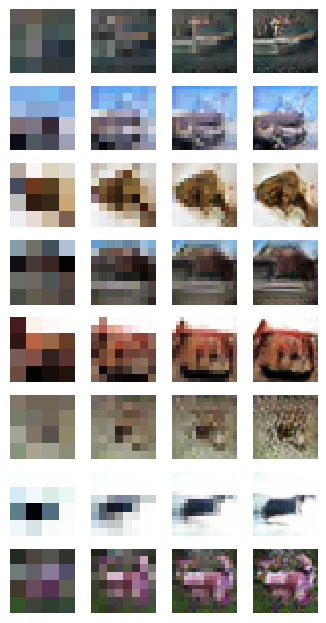

Epoch 71
                        Batch 0 Loss 0.2688
Epoch 71
                        Batch 100 Loss 0.2598
Epoch 71
                        Batch 200 Loss 0.2799
Epoch 71
                        Batch 300 Loss 0.3990
Epoch 71
                        Batch 400 Loss 0.1996
Epoch 71
                        Batch 500 Loss 0.4332
Epoch 71
                        Batch 600 Loss 0.1810
Epoch 71
                        Batch 700 Loss 0.2323
Epoch 71
                        Batch 800 Loss 0.5902
Epoch 71
                        Batch 900 Loss 0.3094
Epoch 71
                        Batch 1000 Loss 0.3258
Epoch 71
                        Batch 1100 Loss 0.5057
Epoch 71
                        Batch 1200 Loss 0.5635
Epoch 71
                        Batch 1300 Loss 0.3749
Epoch 71
                        Batch 1400 Loss 0.3478
Epoch 71
                        Batch 1500 Loss 0.3044
Epoch 71
                        Batch 1600 Loss 0.4005
Epoch 71
                        Batch 1700 Loss 0.4655
Epoc

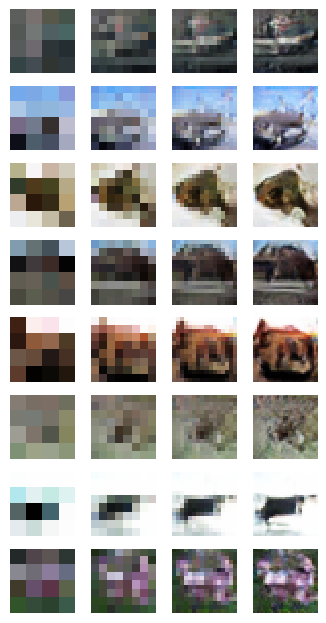

Epoch 72
                        Batch 0 Loss 0.4801
Epoch 72
                        Batch 100 Loss 0.2557
Epoch 72
                        Batch 200 Loss 0.1354
Epoch 72
                        Batch 300 Loss 0.5472
Epoch 72
                        Batch 400 Loss 0.5713
Epoch 72
                        Batch 500 Loss 0.2232
Epoch 72
                        Batch 600 Loss 0.3763
Epoch 72
                        Batch 700 Loss 0.4001
Epoch 72
                        Batch 800 Loss 0.2339
Epoch 72
                        Batch 900 Loss 0.2227
Epoch 72
                        Batch 1000 Loss 0.4252
Epoch 72
                        Batch 1100 Loss 0.3856
Epoch 72
                        Batch 1200 Loss 0.3791
Epoch 72
                        Batch 1300 Loss 0.3901
Epoch 72
                        Batch 1400 Loss 0.2028
Epoch 72
                        Batch 1500 Loss 0.2347
Epoch 72
                        Batch 1600 Loss 0.3708
Epoch 72
                        Batch 1700 Loss 0.6029
Epoc

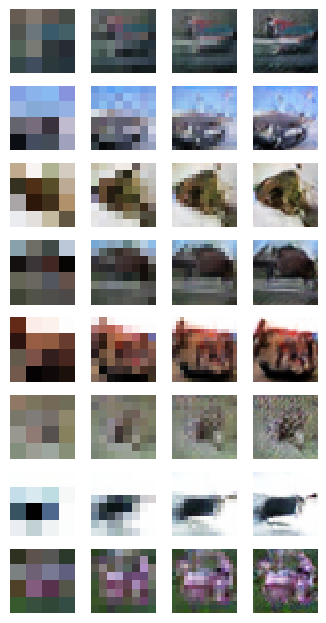

Epoch 73
                        Batch 0 Loss 0.5957
Epoch 73
                        Batch 100 Loss 0.3355
Epoch 73
                        Batch 200 Loss 0.3968
Epoch 73
                        Batch 300 Loss 0.4652
Epoch 73
                        Batch 400 Loss 0.2759
Epoch 73
                        Batch 500 Loss 0.4649
Epoch 73
                        Batch 600 Loss 0.4356
Epoch 73
                        Batch 700 Loss 0.4403
Epoch 73
                        Batch 800 Loss 0.3792
Epoch 73
                        Batch 900 Loss 0.4857
Epoch 73
                        Batch 1000 Loss 0.2994
Epoch 73
                        Batch 1100 Loss 0.3620
Epoch 73
                        Batch 1200 Loss 0.2276
Epoch 73
                        Batch 1300 Loss 0.3132
Epoch 73
                        Batch 1400 Loss 0.2669
Epoch 73
                        Batch 1500 Loss 0.2953
Epoch 73
                        Batch 1600 Loss 0.3133
Epoch 73
                        Batch 1700 Loss 0.4106
Epoc

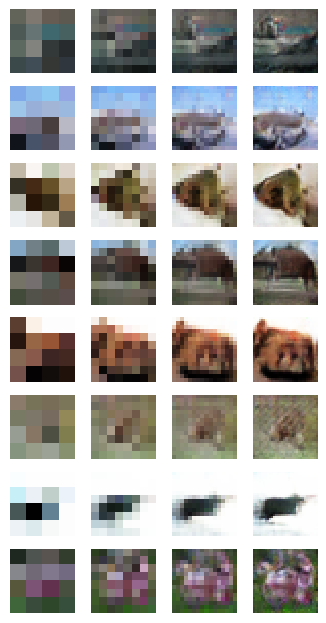

Epoch 74
                        Batch 0 Loss 0.2386
Epoch 74
                        Batch 100 Loss 0.3357
Epoch 74
                        Batch 200 Loss 0.4052
Epoch 74
                        Batch 300 Loss 0.3714
Epoch 74
                        Batch 400 Loss 0.5300
Epoch 74
                        Batch 500 Loss 0.3957
Epoch 74
                        Batch 600 Loss 0.4114
Epoch 74
                        Batch 700 Loss 0.3478
Epoch 74
                        Batch 800 Loss 0.7002
Epoch 74
                        Batch 900 Loss 0.3382
Epoch 74
                        Batch 1000 Loss 0.4336
Epoch 74
                        Batch 1100 Loss 0.3555
Epoch 74
                        Batch 1200 Loss 0.5536
Epoch 74
                        Batch 1300 Loss 0.0851
Epoch 74
                        Batch 1400 Loss 0.3917
Epoch 74
                        Batch 1500 Loss 0.4590
Epoch 74
                        Batch 1600 Loss 0.3336
Epoch 74
                        Batch 1700 Loss 0.2616
Epoc

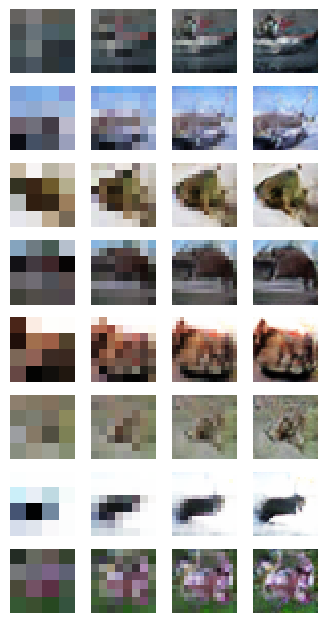

Epoch 75
                        Batch 0 Loss 0.4582
Epoch 75
                        Batch 100 Loss 0.3919
Epoch 75
                        Batch 200 Loss 0.4305
Epoch 75
                        Batch 300 Loss 0.5681
Epoch 75
                        Batch 400 Loss 0.6372
Epoch 75
                        Batch 500 Loss 0.4745
Epoch 75
                        Batch 600 Loss 0.4417
Epoch 75
                        Batch 700 Loss 0.8473
Epoch 75
                        Batch 800 Loss 0.3247
Epoch 75
                        Batch 900 Loss 0.4608
Epoch 75
                        Batch 1000 Loss 0.3941
Epoch 75
                        Batch 1100 Loss 0.3882
Epoch 75
                        Batch 1200 Loss 0.3627
Epoch 75
                        Batch 1300 Loss 0.2752
Epoch 75
                        Batch 1400 Loss 0.3377
Epoch 75
                        Batch 1500 Loss 0.2072
Epoch 75
                        Batch 1600 Loss 0.3390
Epoch 75
                        Batch 1700 Loss 0.5215
Epoc

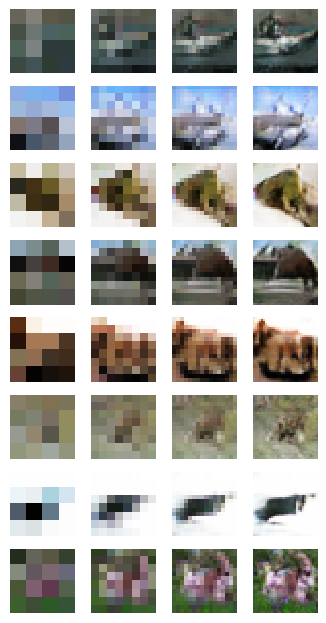

Epoch 76
                        Batch 0 Loss 0.4195
Epoch 76
                        Batch 100 Loss 0.3288
Epoch 76
                        Batch 200 Loss 0.2417
Epoch 76
                        Batch 300 Loss 0.4651
Epoch 76
                        Batch 400 Loss 0.2964
Epoch 76
                        Batch 500 Loss 0.3734
Epoch 76
                        Batch 600 Loss 0.4525
Epoch 76
                        Batch 700 Loss 0.3167
Epoch 76
                        Batch 800 Loss 0.4910
Epoch 76
                        Batch 900 Loss 0.3155
Epoch 76
                        Batch 1000 Loss 0.3832
Epoch 76
                        Batch 1100 Loss 0.4091
Epoch 76
                        Batch 1200 Loss 0.2933
Epoch 76
                        Batch 1300 Loss 0.3014
Epoch 76
                        Batch 1400 Loss 0.5739
Epoch 76
                        Batch 1500 Loss 0.4694
Epoch 76
                        Batch 1600 Loss 0.6095
Epoch 76
                        Batch 1700 Loss 0.3747
Epoc

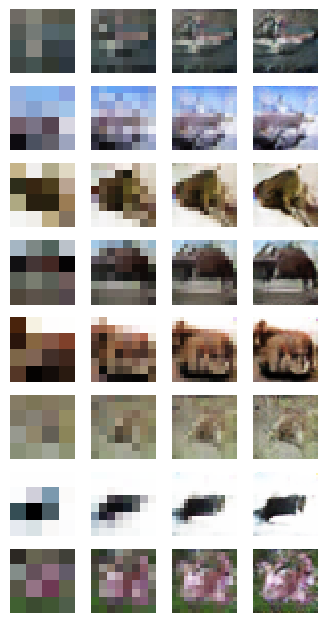

Epoch 77
                        Batch 0 Loss 0.4228
Epoch 77
                        Batch 100 Loss 0.4744
Epoch 77
                        Batch 200 Loss 0.4359
Epoch 77
                        Batch 300 Loss 0.1663
Epoch 77
                        Batch 400 Loss 0.3518
Epoch 77
                        Batch 500 Loss 0.4102
Epoch 77
                        Batch 600 Loss 0.6276
Epoch 77
                        Batch 700 Loss 0.3203
Epoch 77
                        Batch 800 Loss 0.2527
Epoch 77
                        Batch 900 Loss 0.2626
Epoch 77
                        Batch 1000 Loss 0.3486
Epoch 77
                        Batch 1100 Loss 0.4112
Epoch 77
                        Batch 1200 Loss 0.4521
Epoch 77
                        Batch 1300 Loss 0.3126
Epoch 77
                        Batch 1400 Loss 0.1297
Epoch 77
                        Batch 1500 Loss 0.2846
Epoch 77
                        Batch 1600 Loss 0.5022
Epoch 77
                        Batch 1700 Loss 0.4847
Epoc

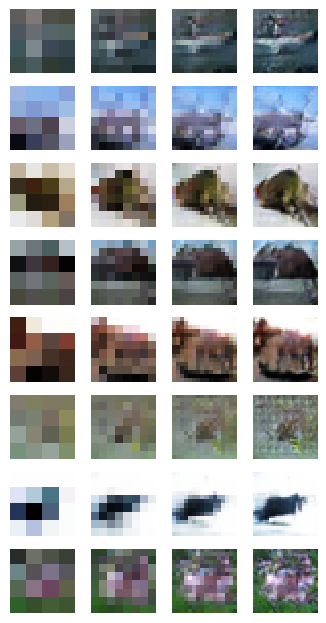

Epoch 78
                        Batch 0 Loss 0.3640
Epoch 78
                        Batch 100 Loss 0.3937
Epoch 78
                        Batch 200 Loss 0.2583
Epoch 78
                        Batch 300 Loss 0.4047
Epoch 78
                        Batch 400 Loss 0.2882
Epoch 78
                        Batch 500 Loss 0.2882
Epoch 78
                        Batch 600 Loss 0.3922
Epoch 78
                        Batch 700 Loss 0.7384
Epoch 78
                        Batch 800 Loss 0.8032
Epoch 78
                        Batch 900 Loss 0.4020
Epoch 78
                        Batch 1000 Loss 0.5149
Epoch 78
                        Batch 1100 Loss 0.2558
Epoch 78
                        Batch 1200 Loss 0.3514
Epoch 78
                        Batch 1300 Loss 0.5954
Epoch 78
                        Batch 1400 Loss 0.2913
Epoch 78
                        Batch 1500 Loss 0.6000
Epoch 78
                        Batch 1600 Loss 0.4674
Epoch 78
                        Batch 1700 Loss 0.3813
Epoc

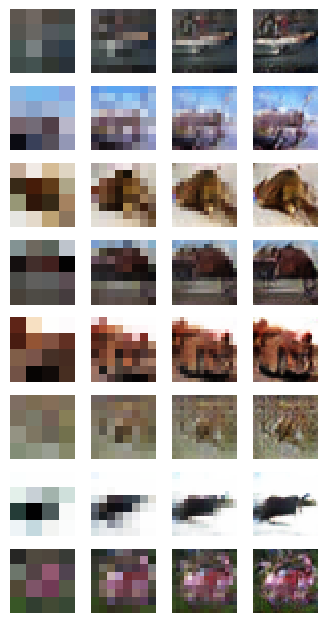

Epoch 79
                        Batch 0 Loss 0.3865
Epoch 79
                        Batch 100 Loss 0.4023
Epoch 79
                        Batch 200 Loss 0.4173
Epoch 79
                        Batch 300 Loss 0.4601
Epoch 79
                        Batch 400 Loss 0.5000
Epoch 79
                        Batch 500 Loss 0.5827
Epoch 79
                        Batch 600 Loss 0.4069
Epoch 79
                        Batch 700 Loss 0.3487
Epoch 79
                        Batch 800 Loss 0.3371
Epoch 79
                        Batch 900 Loss 0.2755
Epoch 79
                        Batch 1000 Loss 0.5038
Epoch 79
                        Batch 1100 Loss 0.5691
Epoch 79
                        Batch 1200 Loss 0.3786
Epoch 79
                        Batch 1300 Loss 0.3700
Epoch 79
                        Batch 1400 Loss 0.3186
Epoch 79
                        Batch 1500 Loss 0.5690
Epoch 79
                        Batch 1600 Loss 0.2355
Epoch 79
                        Batch 1700 Loss 0.1650
Epoc

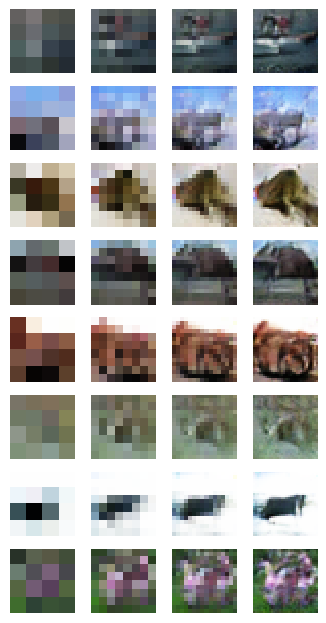

Epoch 80
                        Batch 0 Loss 0.5389
Epoch 80
                        Batch 100 Loss 0.4150
Epoch 80
                        Batch 200 Loss 0.5282
Epoch 80
                        Batch 300 Loss 0.2934
Epoch 80
                        Batch 400 Loss 0.5254
Epoch 80
                        Batch 500 Loss 0.2118
Epoch 80
                        Batch 600 Loss 0.5098
Epoch 80
                        Batch 700 Loss 0.1848
Epoch 80
                        Batch 800 Loss 0.4131
Epoch 80
                        Batch 900 Loss 0.4875
Epoch 80
                        Batch 1000 Loss 0.5482
Epoch 80
                        Batch 1100 Loss 0.5627
Epoch 80
                        Batch 1200 Loss 0.4755
Epoch 80
                        Batch 1300 Loss 0.4474
Epoch 80
                        Batch 1400 Loss 0.4605
Epoch 80
                        Batch 1500 Loss 0.4097
Epoch 80
                        Batch 1600 Loss 0.7566
Epoch 80
                        Batch 1700 Loss 0.4076
Epoc

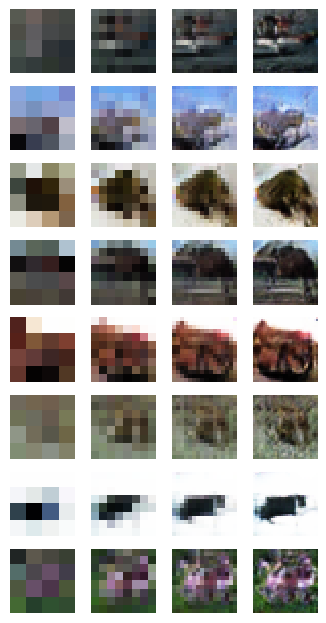

Epoch 81
                        Batch 0 Loss 0.5133
Epoch 81
                        Batch 100 Loss 0.3729
Epoch 81
                        Batch 200 Loss 0.2281
Epoch 81
                        Batch 300 Loss 0.4036
Epoch 81
                        Batch 400 Loss 0.3807
Epoch 81
                        Batch 500 Loss 0.3478
Epoch 81
                        Batch 600 Loss 0.5400
Epoch 81
                        Batch 700 Loss 0.2607
Epoch 81
                        Batch 800 Loss 0.2814
Epoch 81
                        Batch 900 Loss 0.3499
Epoch 81
                        Batch 1000 Loss 0.2640
Epoch 81
                        Batch 1100 Loss 0.4230
Epoch 81
                        Batch 1200 Loss 0.3267
Epoch 81
                        Batch 1300 Loss 0.3803
Epoch 81
                        Batch 1400 Loss 0.5297
Epoch 81
                        Batch 1500 Loss 0.3770
Epoch 81
                        Batch 1600 Loss 0.4587
Epoch 81
                        Batch 1700 Loss 0.3766
Epoc

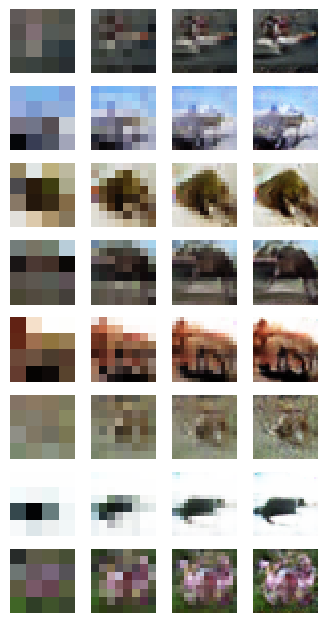

Epoch 82
                        Batch 0 Loss 0.5937
Epoch 82
                        Batch 100 Loss 0.4975
Epoch 82
                        Batch 200 Loss 0.4721
Epoch 82
                        Batch 300 Loss 0.2745
Epoch 82
                        Batch 400 Loss 0.3635
Epoch 82
                        Batch 500 Loss 0.3237
Epoch 82
                        Batch 600 Loss 0.4180
Epoch 82
                        Batch 700 Loss 0.5606
Epoch 82
                        Batch 800 Loss 0.4743
Epoch 82
                        Batch 900 Loss 0.3477
Epoch 82
                        Batch 1000 Loss 0.3561
Epoch 82
                        Batch 1100 Loss 0.1973
Epoch 82
                        Batch 1200 Loss 0.6107
Epoch 82
                        Batch 1300 Loss 0.4680
Epoch 82
                        Batch 1400 Loss 0.1847
Epoch 82
                        Batch 1500 Loss 0.4440
Epoch 82
                        Batch 1600 Loss 0.5342
Epoch 82
                        Batch 1700 Loss 0.3782
Epoc

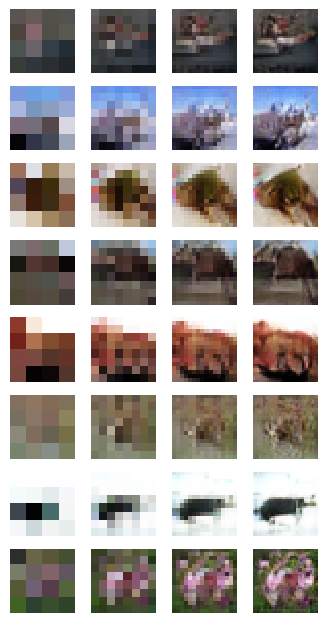

Epoch 83
                        Batch 0 Loss 0.6018
Epoch 83
                        Batch 100 Loss 0.3205
Epoch 83
                        Batch 200 Loss 0.4374
Epoch 83
                        Batch 300 Loss 0.2876
Epoch 83
                        Batch 400 Loss 0.6414
Epoch 83
                        Batch 500 Loss 0.2608
Epoch 83
                        Batch 600 Loss 0.5148
Epoch 83
                        Batch 700 Loss 0.5009
Epoch 83
                        Batch 800 Loss 0.3816
Epoch 83
                        Batch 900 Loss 0.5600
Epoch 83
                        Batch 1000 Loss 0.3301
Epoch 83
                        Batch 1100 Loss 0.3532
Epoch 83
                        Batch 1200 Loss 0.3838
Epoch 83
                        Batch 1300 Loss 0.2661
Epoch 83
                        Batch 1400 Loss 0.4196
Epoch 83
                        Batch 1500 Loss 0.3877
Epoch 83
                        Batch 1600 Loss 0.1702
Epoch 83
                        Batch 1700 Loss 0.3354
Epoc

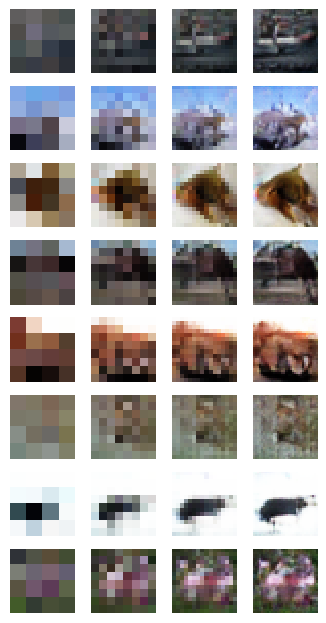

Epoch 84
                        Batch 0 Loss 0.2028
Epoch 84
                        Batch 100 Loss 0.4395
Epoch 84
                        Batch 200 Loss 0.2991
Epoch 84
                        Batch 300 Loss 0.3597
Epoch 84
                        Batch 400 Loss 0.7256
Epoch 84
                        Batch 500 Loss 0.3887
Epoch 84
                        Batch 600 Loss 0.4391
Epoch 84
                        Batch 700 Loss 0.3983
Epoch 84
                        Batch 800 Loss 0.5038
Epoch 84
                        Batch 900 Loss 0.3423
Epoch 84
                        Batch 1000 Loss 0.2461
Epoch 84
                        Batch 1100 Loss 0.4877
Epoch 84
                        Batch 1200 Loss 0.2714
Epoch 84
                        Batch 1300 Loss 0.1888
Epoch 84
                        Batch 1400 Loss 0.2765
Epoch 84
                        Batch 1500 Loss 0.2853
Epoch 84
                        Batch 1600 Loss 0.2558
Epoch 84
                        Batch 1700 Loss 0.4834
Epoc

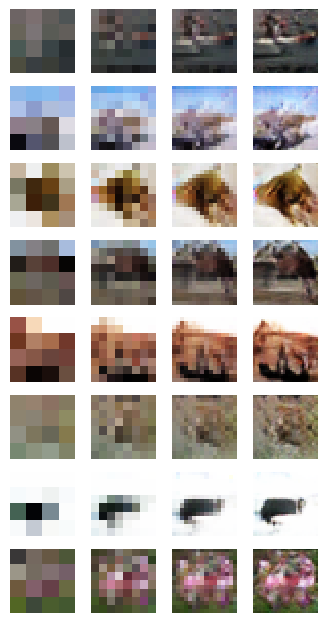

Epoch 85
                        Batch 0 Loss 0.3063
Epoch 85
                        Batch 100 Loss 0.5577
Epoch 85
                        Batch 200 Loss 0.4112
Epoch 85
                        Batch 300 Loss 0.3524
Epoch 85
                        Batch 400 Loss 0.4298
Epoch 85
                        Batch 500 Loss 0.2870
Epoch 85
                        Batch 600 Loss 0.3167
Epoch 85
                        Batch 700 Loss 0.2474
Epoch 85
                        Batch 800 Loss 0.4895
Epoch 85
                        Batch 900 Loss 0.6628
Epoch 85
                        Batch 1000 Loss 0.4584
Epoch 85
                        Batch 1100 Loss 0.3498
Epoch 85
                        Batch 1200 Loss 0.3481
Epoch 85
                        Batch 1300 Loss 0.6688
Epoch 85
                        Batch 1400 Loss 0.3411
Epoch 85
                        Batch 1500 Loss 0.3724
Epoch 85
                        Batch 1600 Loss 0.1940
Epoch 85
                        Batch 1700 Loss 0.2769
Epoc

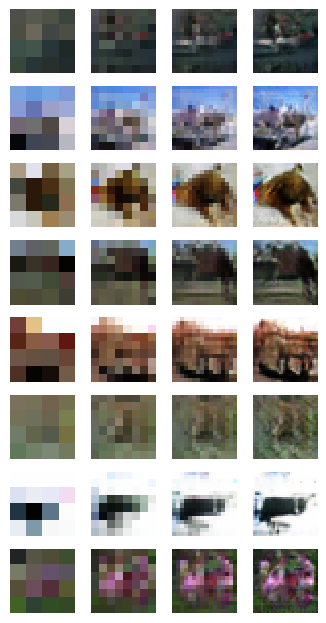

Epoch 86
                        Batch 0 Loss 0.4085
Epoch 86
                        Batch 100 Loss 0.2076
Epoch 86
                        Batch 200 Loss 0.2960
Epoch 86
                        Batch 300 Loss 0.2191
Epoch 86
                        Batch 400 Loss 0.4681
Epoch 86
                        Batch 500 Loss 0.5365
Epoch 86
                        Batch 600 Loss 0.5160
Epoch 86
                        Batch 700 Loss 0.1616
Epoch 86
                        Batch 800 Loss 0.2573
Epoch 86
                        Batch 900 Loss 0.3220
Epoch 86
                        Batch 1000 Loss 0.4520
Epoch 86
                        Batch 1100 Loss 0.2308
Epoch 86
                        Batch 1200 Loss 0.3835
Epoch 86
                        Batch 1300 Loss 0.5735
Epoch 86
                        Batch 1400 Loss 0.2464
Epoch 86
                        Batch 1500 Loss 0.4467
Epoch 86
                        Batch 1600 Loss 0.3412
Epoch 86
                        Batch 1700 Loss 0.4848
Epoc

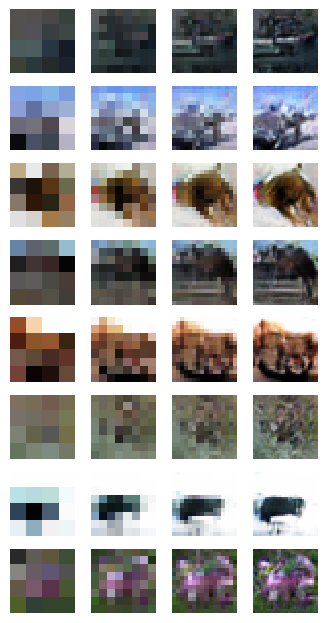

Epoch 87
                        Batch 0 Loss 0.2356
Epoch 87
                        Batch 100 Loss 0.4064
Epoch 87
                        Batch 200 Loss 0.4660
Epoch 87
                        Batch 300 Loss 0.3117
Epoch 87
                        Batch 400 Loss 0.4889
Epoch 87
                        Batch 500 Loss 0.1747
Epoch 87
                        Batch 600 Loss 0.3847
Epoch 87
                        Batch 700 Loss 0.2202
Epoch 87
                        Batch 800 Loss 0.3158
Epoch 87
                        Batch 900 Loss 0.3745
Epoch 87
                        Batch 1000 Loss 0.4825
Epoch 87
                        Batch 1100 Loss 0.3502
Epoch 87
                        Batch 1200 Loss 0.1593
Epoch 87
                        Batch 1300 Loss 0.3458
Epoch 87
                        Batch 1400 Loss 0.4519
Epoch 87
                        Batch 1500 Loss 0.4773
Epoch 87
                        Batch 1600 Loss 0.4042
Epoch 87
                        Batch 1700 Loss 0.2474
Epoc

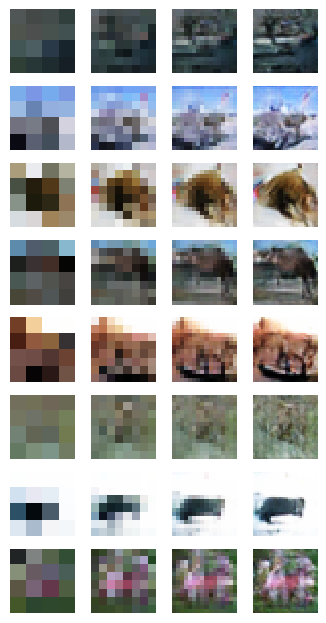

Epoch 88
                        Batch 0 Loss 0.6144
Epoch 88
                        Batch 100 Loss 0.4142
Epoch 88
                        Batch 200 Loss 0.4015
Epoch 88
                        Batch 300 Loss 0.3460
Epoch 88
                        Batch 400 Loss 0.4804
Epoch 88
                        Batch 500 Loss 0.4307
Epoch 88
                        Batch 600 Loss 0.6825
Epoch 88
                        Batch 700 Loss 0.2341
Epoch 88
                        Batch 800 Loss 0.2462
Epoch 88
                        Batch 900 Loss 0.3744
Epoch 88
                        Batch 1000 Loss 0.2553
Epoch 88
                        Batch 1100 Loss 0.4909
Epoch 88
                        Batch 1200 Loss 0.2365
Epoch 88
                        Batch 1300 Loss 0.4268
Epoch 88
                        Batch 1400 Loss 0.3828
Epoch 88
                        Batch 1500 Loss 0.3179
Epoch 88
                        Batch 1600 Loss 0.3654
Epoch 88
                        Batch 1700 Loss 0.6235
Epoc

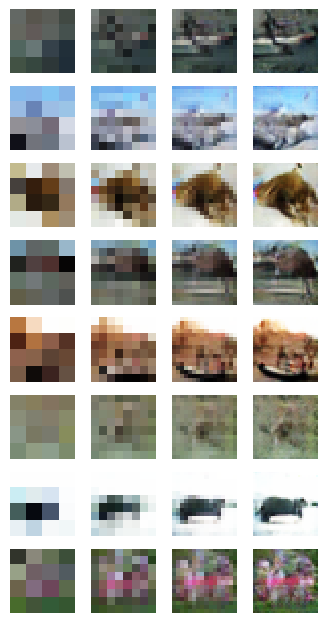

Epoch 89
                        Batch 0 Loss 0.4352
Epoch 89
                        Batch 100 Loss 0.4885
Epoch 89
                        Batch 200 Loss 0.4233
Epoch 89
                        Batch 300 Loss 0.3904
Epoch 89
                        Batch 400 Loss 0.4160
Epoch 89
                        Batch 500 Loss 0.4289
Epoch 89
                        Batch 600 Loss 0.2968
Epoch 89
                        Batch 700 Loss 0.3145
Epoch 89
                        Batch 800 Loss 0.3857
Epoch 89
                        Batch 900 Loss 0.1844
Epoch 89
                        Batch 1000 Loss 0.4964
Epoch 89
                        Batch 1100 Loss 0.4073
Epoch 89
                        Batch 1200 Loss 0.3307
Epoch 89
                        Batch 1300 Loss 0.3376
Epoch 89
                        Batch 1400 Loss 0.4155
Epoch 89
                        Batch 1500 Loss 0.2938
Epoch 89
                        Batch 1600 Loss 0.4164
Epoch 89
                        Batch 1700 Loss 0.4115
Epoc

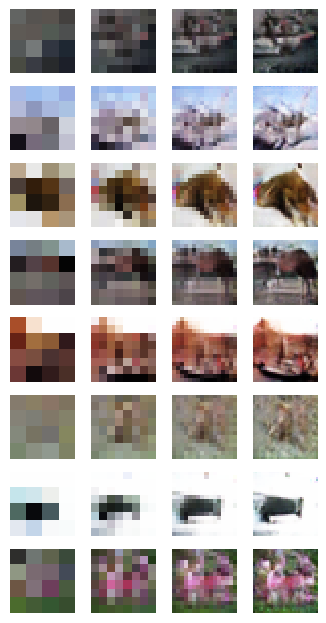

Epoch 90
                        Batch 0 Loss 0.4314
Epoch 90
                        Batch 100 Loss 0.5690
Epoch 90
                        Batch 200 Loss 0.4151
Epoch 90
                        Batch 300 Loss 0.2469
Epoch 90
                        Batch 400 Loss 0.6989
Epoch 90
                        Batch 500 Loss 0.4498
Epoch 90
                        Batch 600 Loss 0.4724
Epoch 90
                        Batch 700 Loss 0.4370
Epoch 90
                        Batch 800 Loss 0.6724
Epoch 90
                        Batch 900 Loss 0.5811
Epoch 90
                        Batch 1000 Loss 0.6408
Epoch 90
                        Batch 1100 Loss 0.4370
Epoch 90
                        Batch 1200 Loss 0.2848
Epoch 90
                        Batch 1300 Loss 0.6430
Epoch 90
                        Batch 1400 Loss 0.3327
Epoch 90
                        Batch 1500 Loss 0.4932
Epoch 90
                        Batch 1600 Loss 0.2788
Epoch 90
                        Batch 1700 Loss 0.2907
Epoc

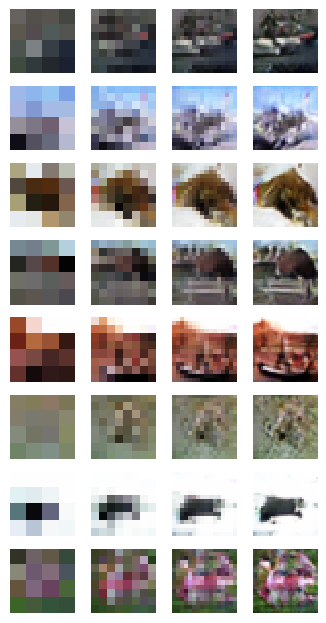

Epoch 91
                        Batch 0 Loss 0.4601
Epoch 91
                        Batch 100 Loss 0.3954
Epoch 91
                        Batch 200 Loss 0.4433
Epoch 91
                        Batch 300 Loss 0.4141
Epoch 91
                        Batch 400 Loss 0.4540
Epoch 91
                        Batch 500 Loss 0.4727
Epoch 91
                        Batch 600 Loss 0.2963
Epoch 91
                        Batch 700 Loss 0.1579
Epoch 91
                        Batch 800 Loss 0.2899
Epoch 91
                        Batch 900 Loss 0.2394
Epoch 91
                        Batch 1000 Loss 0.5415
Epoch 91
                        Batch 1100 Loss 0.5490
Epoch 91
                        Batch 1200 Loss 0.2935
Epoch 91
                        Batch 1300 Loss 0.4234
Epoch 91
                        Batch 1400 Loss 0.2642
Epoch 91
                        Batch 1500 Loss 0.3648
Epoch 91
                        Batch 1600 Loss 0.2993
Epoch 91
                        Batch 1700 Loss 0.6042
Epoc

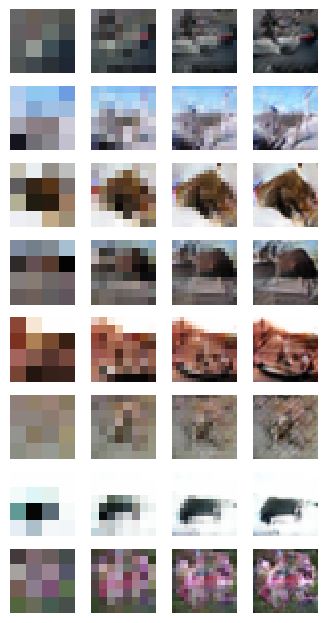

Epoch 92
                        Batch 0 Loss 0.4833
Epoch 92
                        Batch 100 Loss 0.4519
Epoch 92
                        Batch 200 Loss 0.3711
Epoch 92
                        Batch 300 Loss 0.4118
Epoch 92
                        Batch 400 Loss 0.4358
Epoch 92
                        Batch 500 Loss 0.1629
Epoch 92
                        Batch 600 Loss 0.2512
Epoch 92
                        Batch 700 Loss 0.5075
Epoch 92
                        Batch 800 Loss 0.8692
Epoch 92
                        Batch 900 Loss 0.6945
Epoch 92
                        Batch 1000 Loss 0.4251
Epoch 92
                        Batch 1100 Loss 0.9053
Epoch 92
                        Batch 1200 Loss 0.2957
Epoch 92
                        Batch 1300 Loss 0.8934
Epoch 92
                        Batch 1400 Loss 0.3127
Epoch 92
                        Batch 1500 Loss 0.6224
Epoch 92
                        Batch 1600 Loss 0.4992
Epoch 92
                        Batch 1700 Loss 0.4136
Epoc

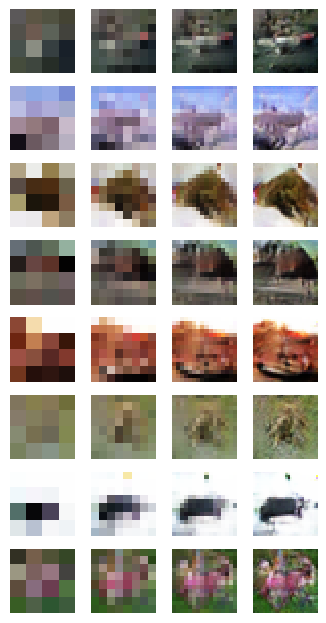

Epoch 93
                        Batch 0 Loss 0.7140
Epoch 93
                        Batch 100 Loss 0.5915
Epoch 93
                        Batch 200 Loss 0.1079
Epoch 93
                        Batch 300 Loss 0.6025
Epoch 93
                        Batch 400 Loss 0.4484
Epoch 93
                        Batch 500 Loss 0.3539
Epoch 93
                        Batch 600 Loss 0.5610
Epoch 93
                        Batch 700 Loss 0.2236
Epoch 93
                        Batch 800 Loss 0.3958
Epoch 93
                        Batch 900 Loss 0.2350
Epoch 93
                        Batch 1000 Loss 0.3156
Epoch 93
                        Batch 1100 Loss 0.3163
Epoch 93
                        Batch 1200 Loss 0.3667
Epoch 93
                        Batch 1300 Loss 0.1752
Epoch 93
                        Batch 1400 Loss 0.5490
Epoch 93
                        Batch 1500 Loss 0.5629
Epoch 93
                        Batch 1600 Loss 0.3711
Epoch 93
                        Batch 1700 Loss 0.4942
Epoc

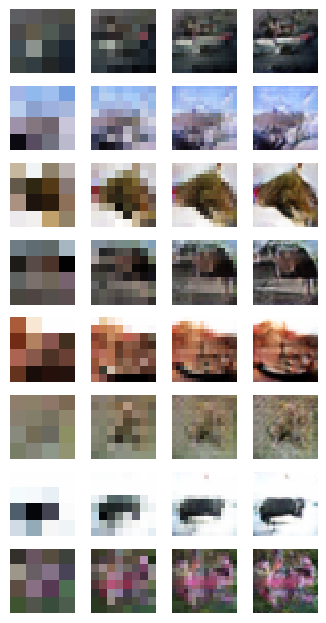

Epoch 94
                        Batch 0 Loss 0.3863
Epoch 94
                        Batch 100 Loss 0.4411
Epoch 94
                        Batch 200 Loss 0.4896
Epoch 94
                        Batch 300 Loss 0.5028
Epoch 94
                        Batch 400 Loss 0.2213
Epoch 94
                        Batch 500 Loss 0.5382
Epoch 94
                        Batch 600 Loss 0.2696
Epoch 94
                        Batch 700 Loss 0.5159
Epoch 94
                        Batch 800 Loss 0.4644
Epoch 94
                        Batch 900 Loss 0.5292
Epoch 94
                        Batch 1000 Loss 0.4894
Epoch 94
                        Batch 1100 Loss 0.3850
Epoch 94
                        Batch 1200 Loss 0.4893
Epoch 94
                        Batch 1300 Loss 0.4429
Epoch 94
                        Batch 1400 Loss 0.5990
Epoch 94
                        Batch 1500 Loss 0.4798
Epoch 94
                        Batch 1600 Loss 0.4464
Epoch 94
                        Batch 1700 Loss 0.4832
Epoc

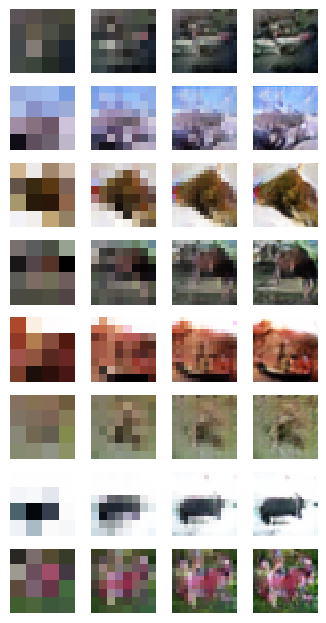

Epoch 95
                        Batch 0 Loss 0.4996
Epoch 95
                        Batch 100 Loss 0.3258
Epoch 95
                        Batch 200 Loss 0.3057
Epoch 95
                        Batch 300 Loss 0.4500
Epoch 95
                        Batch 400 Loss 0.2243
Epoch 95
                        Batch 500 Loss 0.2127
Epoch 95
                        Batch 600 Loss 0.3540
Epoch 95
                        Batch 700 Loss 0.4810
Epoch 95
                        Batch 800 Loss 0.3035
Epoch 95
                        Batch 900 Loss 0.3168
Epoch 95
                        Batch 1000 Loss 0.7616
Epoch 95
                        Batch 1100 Loss 0.3161
Epoch 95
                        Batch 1200 Loss 0.4554
Epoch 95
                        Batch 1300 Loss 0.5240
Epoch 95
                        Batch 1400 Loss 0.3217
Epoch 95
                        Batch 1500 Loss 0.4587
Epoch 95
                        Batch 1600 Loss 0.3597
Epoch 95
                        Batch 1700 Loss 0.3275
Epoc

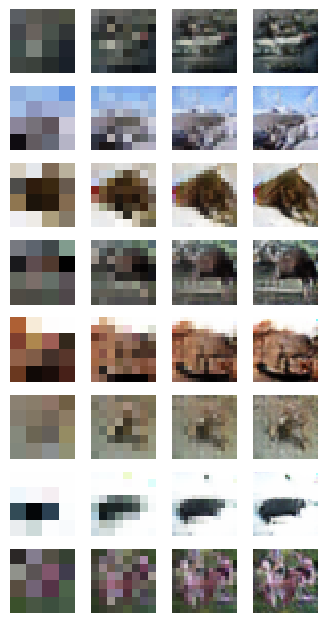

Epoch 96
                        Batch 0 Loss 0.3387
Epoch 96
                        Batch 100 Loss 0.6355
Epoch 96
                        Batch 200 Loss 0.6044
Epoch 96
                        Batch 300 Loss 0.6760
Epoch 96
                        Batch 400 Loss 0.4376
Epoch 96
                        Batch 500 Loss 0.4364
Epoch 96
                        Batch 600 Loss 0.5172
Epoch 96
                        Batch 700 Loss 0.4795
Epoch 96
                        Batch 800 Loss 0.3258
Epoch 96
                        Batch 900 Loss 0.5469
Epoch 96
                        Batch 1000 Loss 0.6081
Epoch 96
                        Batch 1100 Loss 0.5201
Epoch 96
                        Batch 1200 Loss 0.5236
Epoch 96
                        Batch 1300 Loss 0.3833
Epoch 96
                        Batch 1400 Loss 0.4390
Epoch 96
                        Batch 1500 Loss 0.3825
Epoch 96
                        Batch 1600 Loss 0.2078
Epoch 96
                        Batch 1700 Loss 0.3898
Epoc

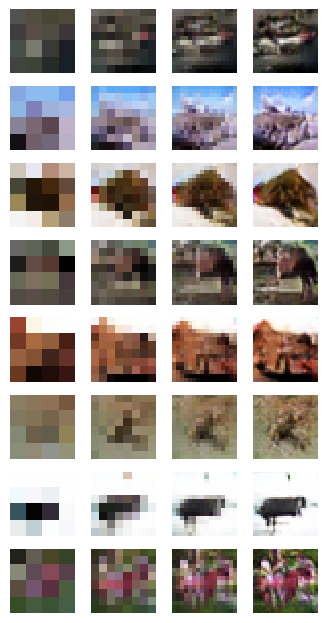

Epoch 97
                        Batch 0 Loss 0.2550
Epoch 97
                        Batch 100 Loss 0.3727
Epoch 97
                        Batch 200 Loss 0.4089
Epoch 97
                        Batch 300 Loss 0.2966
Epoch 97
                        Batch 400 Loss 0.4453
Epoch 97
                        Batch 500 Loss 0.6631
Epoch 97
                        Batch 600 Loss 0.2868
Epoch 97
                        Batch 700 Loss 0.4907
Epoch 97
                        Batch 800 Loss 0.4115
Epoch 97
                        Batch 900 Loss 0.4254
Epoch 97
                        Batch 1000 Loss 0.3949
Epoch 97
                        Batch 1100 Loss 0.3475
Epoch 97
                        Batch 1200 Loss 0.4938
Epoch 97
                        Batch 1300 Loss 0.4653
Epoch 97
                        Batch 1400 Loss 0.5428
Epoch 97
                        Batch 1500 Loss 0.3436
Epoch 97
                        Batch 1600 Loss 0.3280
Epoch 97
                        Batch 1700 Loss 0.5022
Epoc

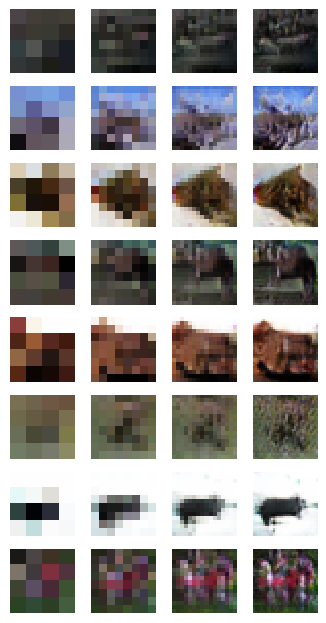

Epoch 98
                        Batch 0 Loss 0.6603
Epoch 98
                        Batch 100 Loss 0.3051
Epoch 98
                        Batch 200 Loss 0.4712
Epoch 98
                        Batch 300 Loss 0.4944
Epoch 98
                        Batch 400 Loss 0.2768
Epoch 98
                        Batch 500 Loss 0.4145
Epoch 98
                        Batch 600 Loss 0.5189
Epoch 98
                        Batch 700 Loss 0.3111
Epoch 98
                        Batch 800 Loss 0.3394
Epoch 98
                        Batch 900 Loss 0.5390
Epoch 98
                        Batch 1000 Loss 0.7598
Epoch 98
                        Batch 1100 Loss 0.2661
Epoch 98
                        Batch 1200 Loss 0.4464
Epoch 98
                        Batch 1300 Loss 0.4123
Epoch 98
                        Batch 1400 Loss 0.2583
Epoch 98
                        Batch 1500 Loss 0.6031
Epoch 98
                        Batch 1600 Loss 0.4183
Epoch 98
                        Batch 1700 Loss 0.3578
Epoc

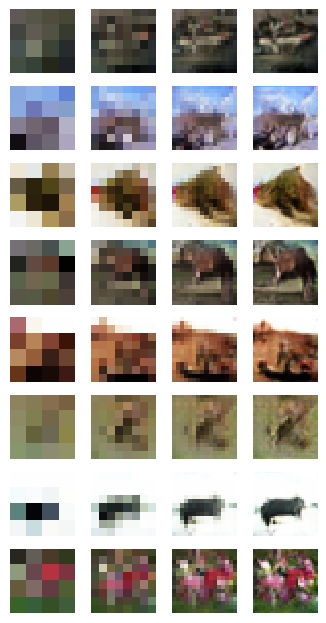

Epoch 99
                        Batch 0 Loss 0.2697
Epoch 99
                        Batch 100 Loss 0.4307
Epoch 99
                        Batch 200 Loss 0.2367
Epoch 99
                        Batch 300 Loss 0.6101
Epoch 99
                        Batch 400 Loss 0.4148
Epoch 99
                        Batch 500 Loss 0.3480
Epoch 99
                        Batch 600 Loss 0.3580
Epoch 99
                        Batch 700 Loss 0.5128
Epoch 99
                        Batch 800 Loss 0.4426
Epoch 99
                        Batch 900 Loss 0.4667
Epoch 99
                        Batch 1000 Loss 0.3158
Epoch 99
                        Batch 1100 Loss 0.5520
Epoch 99
                        Batch 1200 Loss 0.4779
Epoch 99
                        Batch 1300 Loss 0.6426
Epoch 99
                        Batch 1400 Loss 0.5410
Epoch 99
                        Batch 1500 Loss 0.4823
Epoch 99
                        Batch 1600 Loss 0.6035
Epoch 99
                        Batch 1700 Loss 0.4011
Epoc

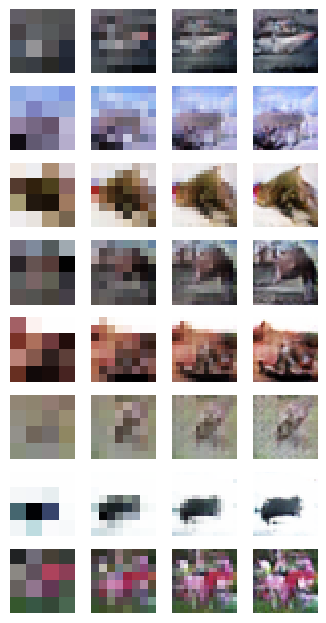

Epoch 100
                        Batch 0 Loss 0.4799
Epoch 100
                        Batch 100 Loss 0.5726
Epoch 100
                        Batch 200 Loss 0.4759
Epoch 100
                        Batch 300 Loss 0.6054
Epoch 100
                        Batch 400 Loss 0.4883
Epoch 100
                        Batch 500 Loss 0.5320
Epoch 100
                        Batch 600 Loss 0.3321
Epoch 100
                        Batch 700 Loss 0.5177
Epoch 100
                        Batch 800 Loss 0.2940
Epoch 100
                        Batch 900 Loss 0.5562
Epoch 100
                        Batch 1000 Loss 0.5119
Epoch 100
                        Batch 1100 Loss 0.4172
Epoch 100
                        Batch 1200 Loss 0.5675
Epoch 100
                        Batch 1300 Loss 0.4766
Epoch 100
                        Batch 1400 Loss 0.5289
Epoch 100
                        Batch 1500 Loss 0.3098
Epoch 100
                        Batch 1600 Loss 0.4074
Epoch 100
                        Batch 170

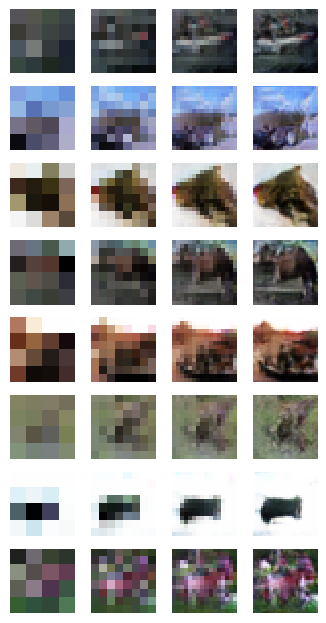

Epoch 101
                        Batch 0 Loss 0.3112
Epoch 101
                        Batch 100 Loss 0.2756
Epoch 101
                        Batch 200 Loss 0.4498
Epoch 101
                        Batch 300 Loss 0.3897
Epoch 101
                        Batch 400 Loss 0.5753
Epoch 101
                        Batch 500 Loss 0.3120
Epoch 101
                        Batch 600 Loss 0.2907
Epoch 101
                        Batch 700 Loss 0.2412
Epoch 101
                        Batch 800 Loss 0.5163
Epoch 101
                        Batch 900 Loss 0.3173
Epoch 101
                        Batch 1000 Loss 0.4003
Epoch 101
                        Batch 1100 Loss 0.5981
Epoch 101
                        Batch 1200 Loss 0.6081
Epoch 101
                        Batch 1300 Loss 0.5783
Epoch 101
                        Batch 1400 Loss 0.1690
Epoch 101
                        Batch 1500 Loss 0.5456
Epoch 101
                        Batch 1600 Loss 0.3282
Epoch 101
                        Batch 170

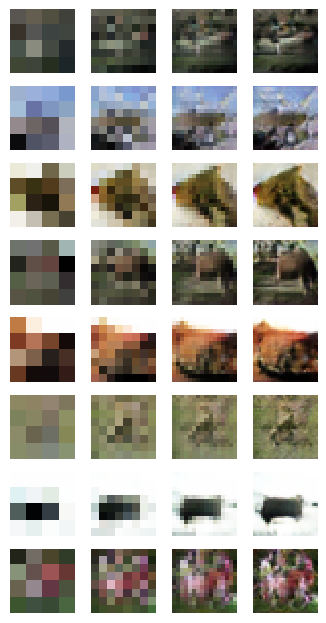

Epoch 102
                        Batch 0 Loss 0.5500
Epoch 102
                        Batch 100 Loss 0.3587
Epoch 102
                        Batch 200 Loss 0.5027
Epoch 102
                        Batch 300 Loss 0.4307
Epoch 102
                        Batch 400 Loss 0.2005
Epoch 102
                        Batch 500 Loss 0.5647
Epoch 102
                        Batch 600 Loss 0.4541
Epoch 102
                        Batch 700 Loss 0.4600
Epoch 102
                        Batch 800 Loss 0.5914
Epoch 102
                        Batch 900 Loss 0.6268
Epoch 102
                        Batch 1000 Loss 0.5177
Epoch 102
                        Batch 1100 Loss 0.5762
Epoch 102
                        Batch 1200 Loss 0.4025
Epoch 102
                        Batch 1300 Loss 0.6254
Epoch 102
                        Batch 1400 Loss 0.4926
Epoch 102
                        Batch 1500 Loss 0.2339
Epoch 102
                        Batch 1600 Loss 0.5834
Epoch 102
                        Batch 170

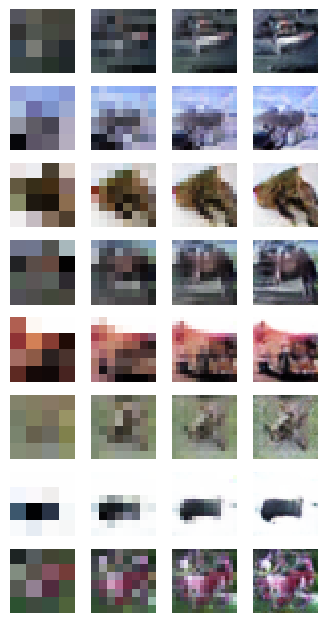

Epoch 103
                        Batch 0 Loss 0.5001
Epoch 103
                        Batch 100 Loss 0.4952
Epoch 103
                        Batch 200 Loss 0.3784
Epoch 103
                        Batch 300 Loss 0.6156
Epoch 103
                        Batch 400 Loss 0.4466
Epoch 103
                        Batch 500 Loss 0.4971
Epoch 103
                        Batch 600 Loss 0.4176
Epoch 103
                        Batch 700 Loss 0.4332
Epoch 103
                        Batch 800 Loss 0.3972
Epoch 103
                        Batch 900 Loss 0.6066
Epoch 103
                        Batch 1000 Loss 0.4838
Epoch 103
                        Batch 1100 Loss 0.3947
Epoch 103
                        Batch 1200 Loss 0.2210
Epoch 103
                        Batch 1300 Loss 0.4607
Epoch 103
                        Batch 1400 Loss 0.6079
Epoch 103
                        Batch 1500 Loss 0.5333
Epoch 103
                        Batch 1600 Loss 0.4237
Epoch 103
                        Batch 170

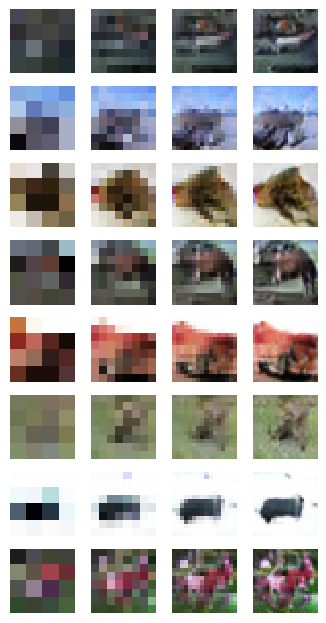

Epoch 104
                        Batch 0 Loss 0.4817
Epoch 104
                        Batch 100 Loss 0.5045
Epoch 104
                        Batch 200 Loss 0.4245
Epoch 104
                        Batch 300 Loss 0.5326
Epoch 104
                        Batch 400 Loss 0.0948
Epoch 104
                        Batch 500 Loss 0.4125
Epoch 104
                        Batch 600 Loss 0.6109
Epoch 104
                        Batch 700 Loss 0.3331
Epoch 104
                        Batch 800 Loss 0.4435
Epoch 104
                        Batch 900 Loss 0.4699
Epoch 104
                        Batch 1000 Loss 0.5475
Epoch 104
                        Batch 1100 Loss 0.3928
Epoch 104
                        Batch 1200 Loss 0.5161
Epoch 104
                        Batch 1300 Loss 0.5375
Epoch 104
                        Batch 1400 Loss 0.2718
Epoch 104
                        Batch 1500 Loss 0.4073
Epoch 104
                        Batch 1600 Loss 0.4762
Epoch 104
                        Batch 170

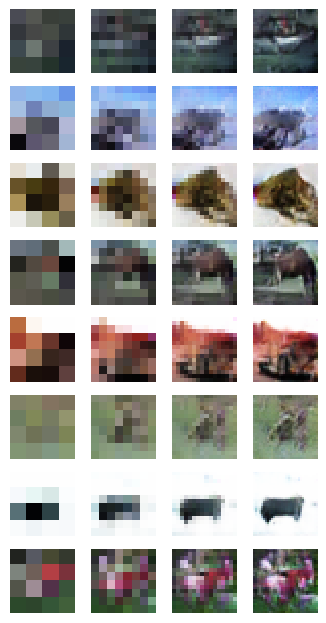

Epoch 105
                        Batch 0 Loss 0.4265
Epoch 105
                        Batch 100 Loss 0.5559
Epoch 105
                        Batch 200 Loss 0.3200
Epoch 105
                        Batch 300 Loss 0.3635
Epoch 105
                        Batch 400 Loss 0.4529
Epoch 105
                        Batch 500 Loss 0.6659
Epoch 105
                        Batch 600 Loss 0.3697
Epoch 105
                        Batch 700 Loss 0.5198
Epoch 105
                        Batch 800 Loss 0.4486
Epoch 105
                        Batch 900 Loss 0.4777
Epoch 105
                        Batch 1000 Loss 0.2363
Epoch 105
                        Batch 1100 Loss 0.3102
Epoch 105
                        Batch 1200 Loss 0.4962
Epoch 105
                        Batch 1300 Loss 0.4509
Epoch 105
                        Batch 1400 Loss 0.3041
Epoch 105
                        Batch 1500 Loss 0.3874
Epoch 105
                        Batch 1600 Loss 0.5404
Epoch 105
                        Batch 170

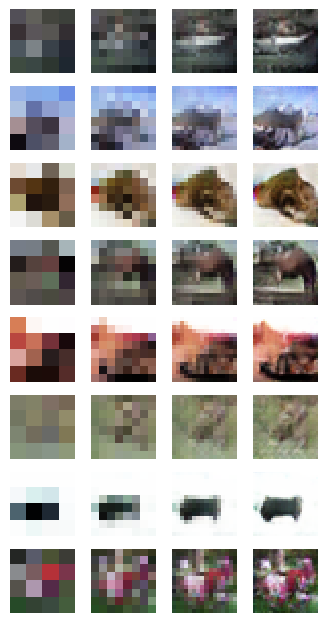

Epoch 106
                        Batch 0 Loss 0.4774
Epoch 106
                        Batch 100 Loss 0.3699
Epoch 106
                        Batch 200 Loss 0.5123
Epoch 106
                        Batch 300 Loss 0.3916
Epoch 106
                        Batch 400 Loss 0.4995
Epoch 106
                        Batch 500 Loss 0.4210
Epoch 106
                        Batch 600 Loss 0.2404
Epoch 106
                        Batch 700 Loss 0.5517
Epoch 106
                        Batch 800 Loss 0.3372
Epoch 106
                        Batch 900 Loss 0.6266
Epoch 106
                        Batch 1000 Loss 0.1435
Epoch 106
                        Batch 1100 Loss 0.4287
Epoch 106
                        Batch 1200 Loss 0.3798
Epoch 106
                        Batch 1300 Loss 0.3548
Epoch 106
                        Batch 1400 Loss 0.3054
Epoch 106
                        Batch 1500 Loss 0.2121
Epoch 106
                        Batch 1600 Loss 0.3528
Epoch 106
                        Batch 170

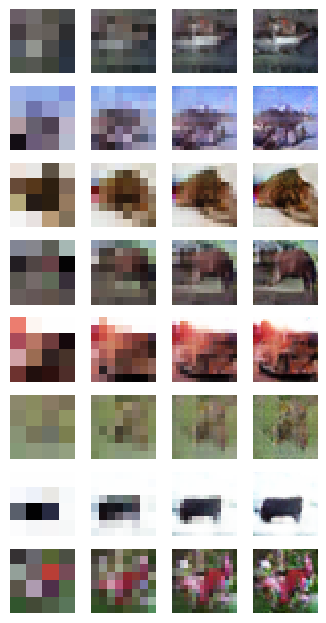

Epoch 107
                        Batch 0 Loss 0.4317
Epoch 107
                        Batch 100 Loss 0.4331
Epoch 107
                        Batch 200 Loss 0.4061
Epoch 107
                        Batch 300 Loss 0.2996
Epoch 107
                        Batch 400 Loss 0.5148
Epoch 107
                        Batch 500 Loss 0.6944
Epoch 107
                        Batch 600 Loss 0.3589
Epoch 107
                        Batch 700 Loss 0.4525
Epoch 107
                        Batch 800 Loss 0.3555
Epoch 107
                        Batch 900 Loss 0.3080
Epoch 107
                        Batch 1000 Loss 0.2869
Epoch 107
                        Batch 1100 Loss 0.6427
Epoch 107
                        Batch 1200 Loss 0.4914
Epoch 107
                        Batch 1300 Loss 0.5909
Epoch 107
                        Batch 1400 Loss 0.5210
Epoch 107
                        Batch 1500 Loss 0.2262
Epoch 107
                        Batch 1600 Loss 0.6751
Epoch 107
                        Batch 170

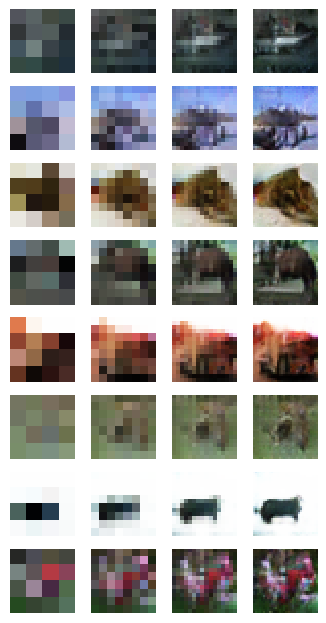

Epoch 108
                        Batch 0 Loss 0.4678
Epoch 108
                        Batch 100 Loss 0.2107
Epoch 108
                        Batch 200 Loss 0.4504
Epoch 108
                        Batch 300 Loss 0.2927
Epoch 108
                        Batch 400 Loss 0.3108
Epoch 108
                        Batch 500 Loss 0.5155
Epoch 108
                        Batch 600 Loss 0.9023
Epoch 108
                        Batch 700 Loss 0.5012
Epoch 108
                        Batch 800 Loss 0.4093
Epoch 108
                        Batch 900 Loss 0.4868
Epoch 108
                        Batch 1000 Loss 0.4926
Epoch 108
                        Batch 1100 Loss 0.6351
Epoch 108
                        Batch 1200 Loss 0.5054
Epoch 108
                        Batch 1300 Loss 0.4925
Epoch 108
                        Batch 1400 Loss 0.4509
Epoch 108
                        Batch 1500 Loss 0.3135
Epoch 108
                        Batch 1600 Loss 0.7361
Epoch 108
                        Batch 170

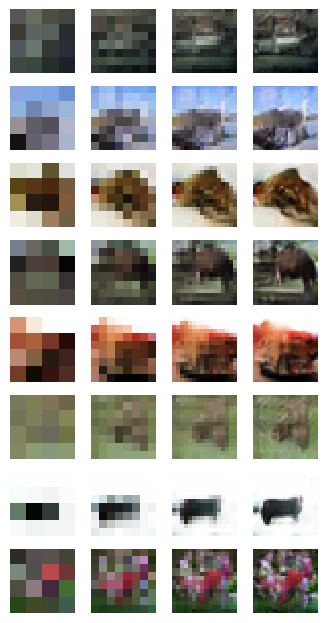

Epoch 109
                        Batch 0 Loss 0.7615
Epoch 109
                        Batch 100 Loss 0.5756
Epoch 109
                        Batch 200 Loss 0.3363
Epoch 109
                        Batch 300 Loss 0.5266
Epoch 109
                        Batch 400 Loss 0.4416
Epoch 109
                        Batch 500 Loss 0.4426
Epoch 109
                        Batch 600 Loss 0.5849
Epoch 109
                        Batch 700 Loss 0.2508
Epoch 109
                        Batch 800 Loss 0.3227
Epoch 109
                        Batch 900 Loss 0.5592
Epoch 109
                        Batch 1000 Loss 0.5670
Epoch 109
                        Batch 1100 Loss 0.7500
Epoch 109
                        Batch 1200 Loss 0.2214
Epoch 109
                        Batch 1300 Loss 0.4579
Epoch 109
                        Batch 1400 Loss 0.3904
Epoch 109
                        Batch 1500 Loss 0.6499
Epoch 109
                        Batch 1600 Loss 0.4668
Epoch 109
                        Batch 170

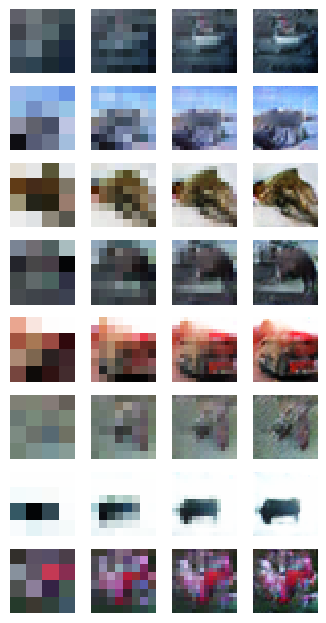

Epoch 110
                        Batch 0 Loss 0.3360
Epoch 110
                        Batch 100 Loss 0.7085
Epoch 110
                        Batch 200 Loss 0.3182
Epoch 110
                        Batch 300 Loss 0.3772
Epoch 110
                        Batch 400 Loss 0.4121
Epoch 110
                        Batch 500 Loss 0.2380
Epoch 110
                        Batch 600 Loss 0.2820
Epoch 110
                        Batch 700 Loss 0.5868
Epoch 110
                        Batch 800 Loss 0.5092
Epoch 110
                        Batch 900 Loss 0.4315
Epoch 110
                        Batch 1000 Loss 0.3727
Epoch 110
                        Batch 1100 Loss 0.3800
Epoch 110
                        Batch 1200 Loss 0.4925
Epoch 110
                        Batch 1300 Loss 0.4706
Epoch 110
                        Batch 1400 Loss 0.4113
Epoch 110
                        Batch 1500 Loss 0.1411
Epoch 110
                        Batch 1600 Loss 0.3753
Epoch 110
                        Batch 170

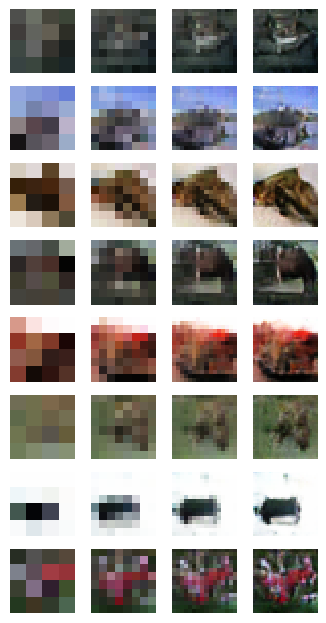

Epoch 111
                        Batch 0 Loss 0.5815
Epoch 111
                        Batch 100 Loss 0.4824
Epoch 111
                        Batch 200 Loss 0.3451
Epoch 111
                        Batch 300 Loss 0.4642
Epoch 111
                        Batch 400 Loss 0.5730
Epoch 111
                        Batch 500 Loss 0.4608
Epoch 111
                        Batch 600 Loss 0.4609
Epoch 111
                        Batch 700 Loss 0.6594
Epoch 111
                        Batch 800 Loss 0.3544
Epoch 111
                        Batch 900 Loss 0.4727
Epoch 111
                        Batch 1000 Loss 0.4218
Epoch 111
                        Batch 1100 Loss 0.1040
Epoch 111
                        Batch 1200 Loss 0.2916
Epoch 111
                        Batch 1300 Loss 0.7300
Epoch 111
                        Batch 1400 Loss 0.3558
Epoch 111
                        Batch 1500 Loss 0.4587
Epoch 111
                        Batch 1600 Loss 0.4938
Epoch 111
                        Batch 170

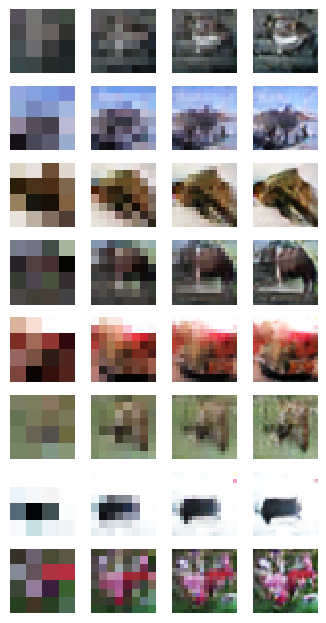

Epoch 112
                        Batch 0 Loss 0.4443
Epoch 112
                        Batch 100 Loss 0.4133
Epoch 112
                        Batch 200 Loss 0.4709
Epoch 112
                        Batch 300 Loss 0.3535
Epoch 112
                        Batch 400 Loss 0.6409
Epoch 112
                        Batch 500 Loss 0.4805
Epoch 112
                        Batch 600 Loss 0.5874
Epoch 112
                        Batch 700 Loss 0.4454
Epoch 112
                        Batch 800 Loss 0.3269
Epoch 112
                        Batch 900 Loss 0.6678
Epoch 112
                        Batch 1000 Loss 0.3489
Epoch 112
                        Batch 1100 Loss 0.3873
Epoch 112
                        Batch 1200 Loss 0.4398
Epoch 112
                        Batch 1300 Loss 0.5155
Epoch 112
                        Batch 1400 Loss 0.3106
Epoch 112
                        Batch 1500 Loss 0.5059
Epoch 112
                        Batch 1600 Loss 0.3423
Epoch 112
                        Batch 170

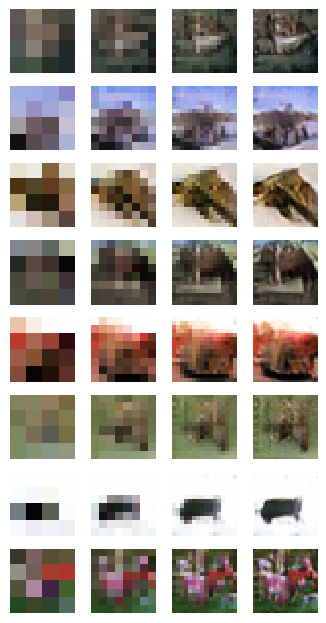

Epoch 113
                        Batch 0 Loss 0.6508
Epoch 113
                        Batch 100 Loss 0.4640
Epoch 113
                        Batch 200 Loss 0.3804
Epoch 113
                        Batch 300 Loss 0.2493
Epoch 113
                        Batch 400 Loss 0.4738
Epoch 113
                        Batch 500 Loss 0.2864
Epoch 113
                        Batch 600 Loss 0.5800
Epoch 113
                        Batch 700 Loss 0.6346
Epoch 113
                        Batch 800 Loss 0.6093
Epoch 113
                        Batch 900 Loss 0.6443
Epoch 113
                        Batch 1000 Loss 0.2881
Epoch 113
                        Batch 1100 Loss 0.4043
Epoch 113
                        Batch 1200 Loss 0.4256
Epoch 113
                        Batch 1300 Loss 0.4443
Epoch 113
                        Batch 1400 Loss 0.1952
Epoch 113
                        Batch 1500 Loss 0.6937
Epoch 113
                        Batch 1600 Loss 0.4017
Epoch 113
                        Batch 170

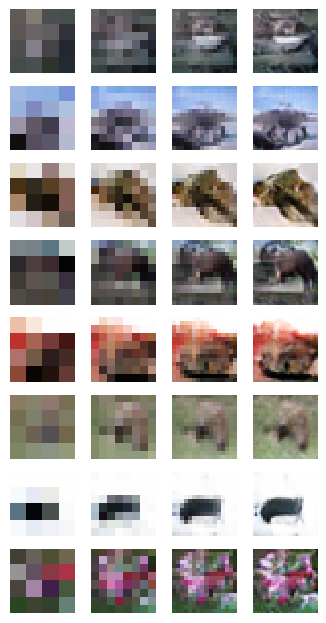

Epoch 114
                        Batch 0 Loss 0.4853
Epoch 114
                        Batch 100 Loss 0.5076
Epoch 114
                        Batch 200 Loss 0.2967
Epoch 114
                        Batch 300 Loss 0.5842
Epoch 114
                        Batch 400 Loss 0.6513
Epoch 114
                        Batch 500 Loss 0.2783
Epoch 114
                        Batch 600 Loss 0.4439
Epoch 114
                        Batch 700 Loss 0.6027
Epoch 114
                        Batch 800 Loss 0.5877
Epoch 114
                        Batch 900 Loss 0.4773
Epoch 114
                        Batch 1000 Loss 0.4284
Epoch 114
                        Batch 1100 Loss 0.5829
Epoch 114
                        Batch 1200 Loss 0.4659
Epoch 114
                        Batch 1300 Loss 0.4316
Epoch 114
                        Batch 1400 Loss 0.2997
Epoch 114
                        Batch 1500 Loss 0.5684
Epoch 114
                        Batch 1600 Loss 0.3973
Epoch 114
                        Batch 170

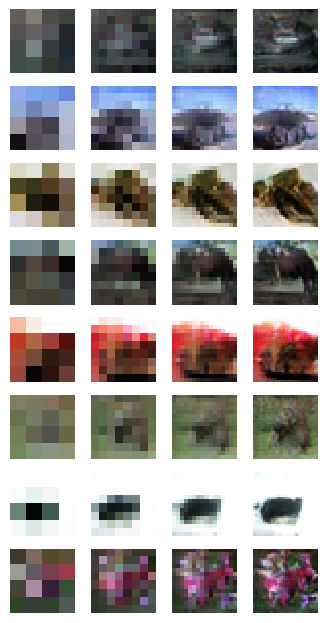

Epoch 115
                        Batch 0 Loss 0.4853
Epoch 115
                        Batch 100 Loss 0.3835
Epoch 115
                        Batch 200 Loss 0.3331
Epoch 115
                        Batch 300 Loss 0.2320
Epoch 115
                        Batch 400 Loss 0.4594
Epoch 115
                        Batch 500 Loss 0.4283
Epoch 115
                        Batch 600 Loss 0.4730
Epoch 115
                        Batch 700 Loss 0.7913
Epoch 115
                        Batch 800 Loss 0.5858
Epoch 115
                        Batch 900 Loss 0.6369
Epoch 115
                        Batch 1000 Loss 0.3533
Epoch 115
                        Batch 1100 Loss 0.6249
Epoch 115
                        Batch 1200 Loss 0.6183
Epoch 115
                        Batch 1300 Loss 0.1737
Epoch 115
                        Batch 1400 Loss 0.1354
Epoch 115
                        Batch 1500 Loss 0.7615
Epoch 115
                        Batch 1600 Loss 0.4131
Epoch 115
                        Batch 170

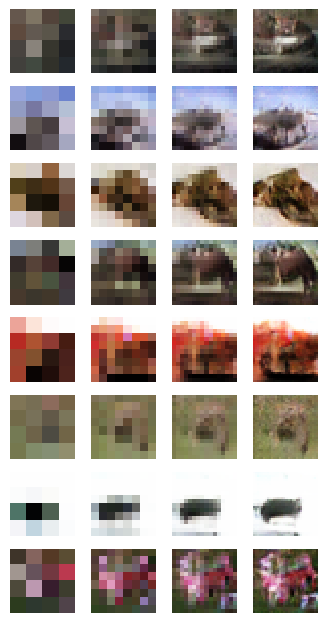

Epoch 116
                        Batch 0 Loss 0.4152
Epoch 116
                        Batch 100 Loss 0.4533
Epoch 116
                        Batch 200 Loss 0.3850
Epoch 116
                        Batch 300 Loss 0.3494
Epoch 116
                        Batch 400 Loss 0.3361
Epoch 116
                        Batch 500 Loss 0.3431
Epoch 116
                        Batch 600 Loss 0.6187
Epoch 116
                        Batch 700 Loss 0.3298
Epoch 116
                        Batch 800 Loss 0.6362
Epoch 116
                        Batch 900 Loss 0.4243
Epoch 116
                        Batch 1000 Loss 0.6740
Epoch 116
                        Batch 1100 Loss 0.1573
Epoch 116
                        Batch 1200 Loss 0.3685
Epoch 116
                        Batch 1300 Loss 0.5049
Epoch 116
                        Batch 1400 Loss 0.3163
Epoch 116
                        Batch 1500 Loss 0.2850
Epoch 116
                        Batch 1600 Loss 0.3359
Epoch 116
                        Batch 170

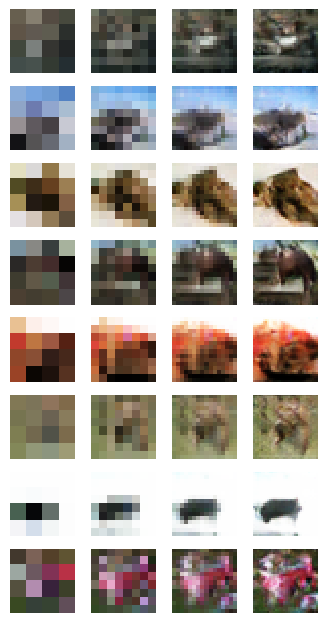

Epoch 117
                        Batch 0 Loss 0.4246
Epoch 117
                        Batch 100 Loss 0.5679
Epoch 117
                        Batch 200 Loss 0.5606
Epoch 117
                        Batch 300 Loss 0.2859
Epoch 117
                        Batch 400 Loss 0.4096
Epoch 117
                        Batch 500 Loss 0.4886
Epoch 117
                        Batch 600 Loss 0.4830
Epoch 117
                        Batch 700 Loss 0.5376
Epoch 117
                        Batch 800 Loss 0.4535
Epoch 117
                        Batch 900 Loss 0.5037
Epoch 117
                        Batch 1000 Loss 0.5207
Epoch 117
                        Batch 1100 Loss 0.4729
Epoch 117
                        Batch 1200 Loss 0.4311
Epoch 117
                        Batch 1300 Loss 0.2902
Epoch 117
                        Batch 1400 Loss 0.4449
Epoch 117
                        Batch 1500 Loss 0.4940
Epoch 117
                        Batch 1600 Loss 0.4343
Epoch 117
                        Batch 170

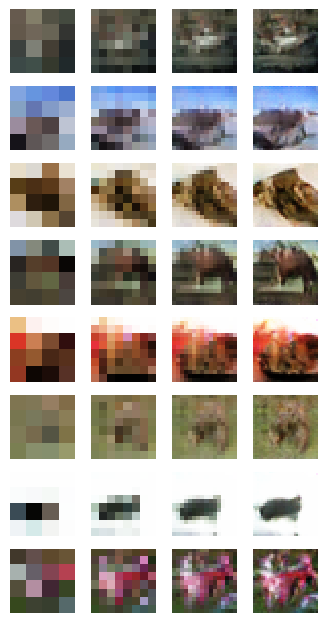

Epoch 118
                        Batch 0 Loss 0.4147
Epoch 118
                        Batch 100 Loss 0.3429
Epoch 118
                        Batch 200 Loss 0.2148
Epoch 118
                        Batch 300 Loss 0.2376
Epoch 118
                        Batch 400 Loss 0.4149
Epoch 118
                        Batch 500 Loss 0.4427
Epoch 118
                        Batch 600 Loss 0.5347
Epoch 118
                        Batch 700 Loss 0.6312
Epoch 118
                        Batch 800 Loss 0.5354
Epoch 118
                        Batch 900 Loss 0.5896
Epoch 118
                        Batch 1000 Loss 0.3208
Epoch 118
                        Batch 1100 Loss 0.3713
Epoch 118
                        Batch 1200 Loss 0.6864
Epoch 118
                        Batch 1300 Loss 0.4545
Epoch 118
                        Batch 1400 Loss 0.7171
Epoch 118
                        Batch 1500 Loss 0.5270
Epoch 118
                        Batch 1600 Loss 0.2617
Epoch 118
                        Batch 170

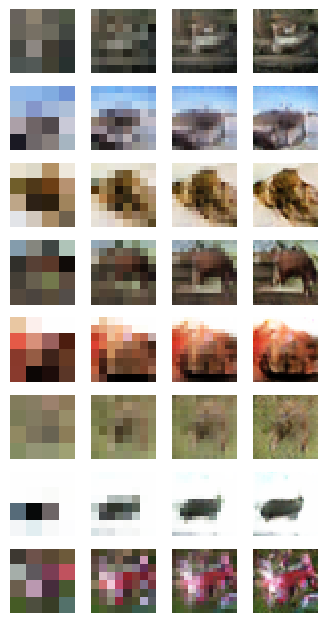

Epoch 119
                        Batch 0 Loss 0.3899
Epoch 119
                        Batch 100 Loss 0.4031
Epoch 119
                        Batch 200 Loss 0.2919
Epoch 119
                        Batch 300 Loss 0.4771
Epoch 119
                        Batch 400 Loss 0.7284
Epoch 119
                        Batch 500 Loss 0.6274
Epoch 119
                        Batch 600 Loss 0.2255
Epoch 119
                        Batch 700 Loss 0.5913
Epoch 119
                        Batch 800 Loss 0.5613
Epoch 119
                        Batch 900 Loss 0.3032
Epoch 119
                        Batch 1000 Loss 0.2845
Epoch 119
                        Batch 1100 Loss 0.3964
Epoch 119
                        Batch 1200 Loss 0.5816
Epoch 119
                        Batch 1300 Loss 0.3557
Epoch 119
                        Batch 1400 Loss 0.5063
Epoch 119
                        Batch 1500 Loss 0.3082
Epoch 119
                        Batch 1600 Loss 0.2327
Epoch 119
                        Batch 170

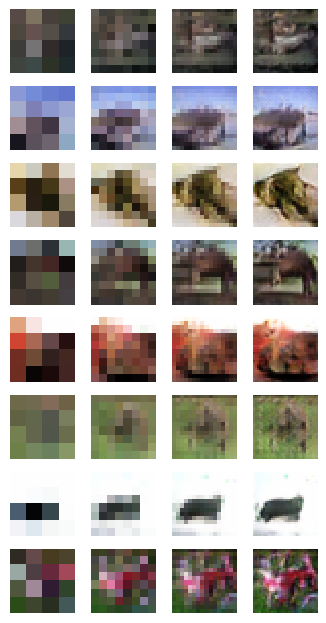

Epoch 120
                        Batch 0 Loss 0.4549
Epoch 120
                        Batch 100 Loss 0.4331
Epoch 120
                        Batch 200 Loss 0.3587
Epoch 120
                        Batch 300 Loss 0.2748
Epoch 120
                        Batch 400 Loss 0.4926
Epoch 120
                        Batch 500 Loss 0.3250
Epoch 120
                        Batch 600 Loss 0.1825
Epoch 120
                        Batch 700 Loss 0.5166
Epoch 120
                        Batch 800 Loss 0.1342
Epoch 120
                        Batch 900 Loss 0.8706
Epoch 120
                        Batch 1000 Loss 0.6643
Epoch 120
                        Batch 1100 Loss 0.7879
Epoch 120
                        Batch 1200 Loss 0.5756
Epoch 120
                        Batch 1300 Loss 0.5322
Epoch 120
                        Batch 1400 Loss 0.2694
Epoch 120
                        Batch 1500 Loss 0.5972
Epoch 120
                        Batch 1600 Loss 0.5294
Epoch 120
                        Batch 170

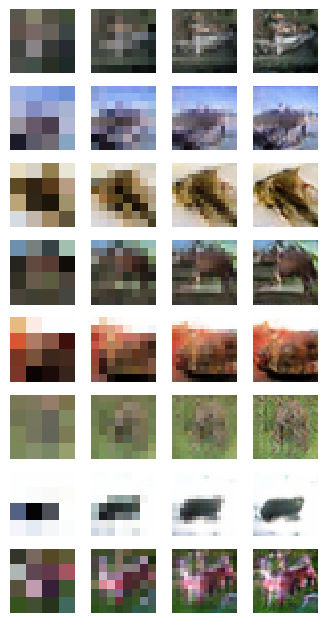

Epoch 121
                        Batch 0 Loss 0.5741
Epoch 121
                        Batch 100 Loss 0.4830
Epoch 121
                        Batch 200 Loss 0.4279
Epoch 121
                        Batch 300 Loss 0.3902
Epoch 121
                        Batch 400 Loss 0.6176
Epoch 121
                        Batch 500 Loss 0.4492
Epoch 121
                        Batch 600 Loss 0.4701
Epoch 121
                        Batch 700 Loss 0.4709
Epoch 121
                        Batch 800 Loss 0.3619
Epoch 121
                        Batch 900 Loss 0.3957
Epoch 121
                        Batch 1000 Loss 0.9346
Epoch 121
                        Batch 1100 Loss 0.6093
Epoch 121
                        Batch 1200 Loss 0.5145
Epoch 121
                        Batch 1300 Loss 0.3114
Epoch 121
                        Batch 1400 Loss 0.4238
Epoch 121
                        Batch 1500 Loss 0.4979
Epoch 121
                        Batch 1600 Loss 0.4127
Epoch 121
                        Batch 170

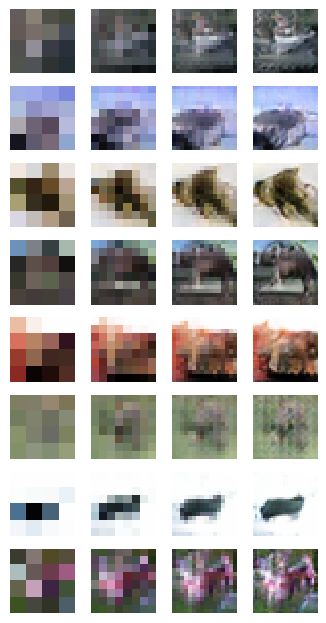

Epoch 122
                        Batch 0 Loss 0.2211
Epoch 122
                        Batch 100 Loss 0.2225
Epoch 122
                        Batch 200 Loss 0.5764
Epoch 122
                        Batch 300 Loss 0.3766
Epoch 122
                        Batch 400 Loss 0.5776
Epoch 122
                        Batch 500 Loss 0.4474
Epoch 122
                        Batch 600 Loss 0.3785
Epoch 122
                        Batch 700 Loss 0.7103
Epoch 122
                        Batch 800 Loss 0.4344
Epoch 122
                        Batch 900 Loss 0.4354
Epoch 122
                        Batch 1000 Loss 0.3716
Epoch 122
                        Batch 1100 Loss 0.6890
Epoch 122
                        Batch 1200 Loss 0.6496
Epoch 122
                        Batch 1300 Loss 0.0939
Epoch 122
                        Batch 1400 Loss 0.1895
Epoch 122
                        Batch 1500 Loss 0.3794
Epoch 122
                        Batch 1600 Loss 0.2587
Epoch 122
                        Batch 170

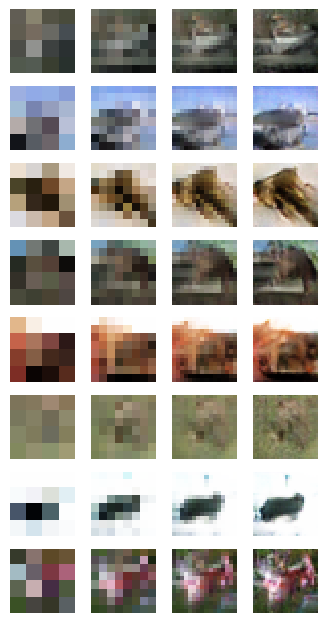

Epoch 123
                        Batch 0 Loss 0.3558
Epoch 123
                        Batch 100 Loss 0.3452
Epoch 123
                        Batch 200 Loss 0.6628
Epoch 123
                        Batch 300 Loss 0.5089
Epoch 123
                        Batch 400 Loss 0.7056
Epoch 123
                        Batch 500 Loss 0.0963
Epoch 123
                        Batch 600 Loss 0.3975
Epoch 123
                        Batch 700 Loss 0.3676
Epoch 123
                        Batch 800 Loss 0.4897
Epoch 123
                        Batch 900 Loss 0.5502
Epoch 123
                        Batch 1000 Loss 0.4109
Epoch 123
                        Batch 1100 Loss 0.3242
Epoch 123
                        Batch 1200 Loss 0.5278
Epoch 123
                        Batch 1300 Loss 0.3231
Epoch 123
                        Batch 1400 Loss 0.4321
Epoch 123
                        Batch 1500 Loss 0.2295
Epoch 123
                        Batch 1600 Loss 0.3071
Epoch 123
                        Batch 170

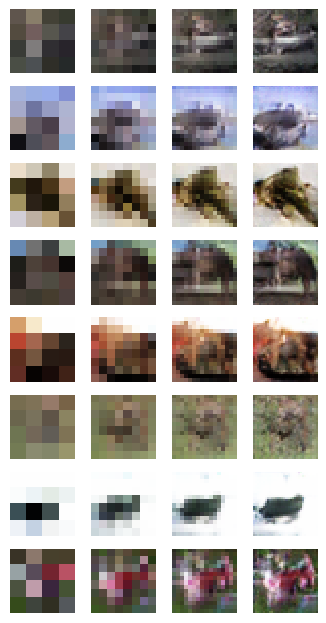

Epoch 124
                        Batch 0 Loss 0.5969
Epoch 124
                        Batch 100 Loss 0.5009
Epoch 124
                        Batch 200 Loss 0.6585
Epoch 124
                        Batch 300 Loss 0.5437
Epoch 124
                        Batch 400 Loss 0.3770
Epoch 124
                        Batch 500 Loss 0.2223
Epoch 124
                        Batch 600 Loss 0.3077
Epoch 124
                        Batch 700 Loss 0.4357
Epoch 124
                        Batch 800 Loss 0.5336
Epoch 124
                        Batch 900 Loss 0.4492
Epoch 124
                        Batch 1000 Loss 0.4637
Epoch 124
                        Batch 1100 Loss 0.6760
Epoch 124
                        Batch 1200 Loss 0.4393
Epoch 124
                        Batch 1300 Loss 0.5354
Epoch 124
                        Batch 1400 Loss 0.7182
Epoch 124
                        Batch 1500 Loss 0.1759
Epoch 124
                        Batch 1600 Loss 0.3369
Epoch 124
                        Batch 170

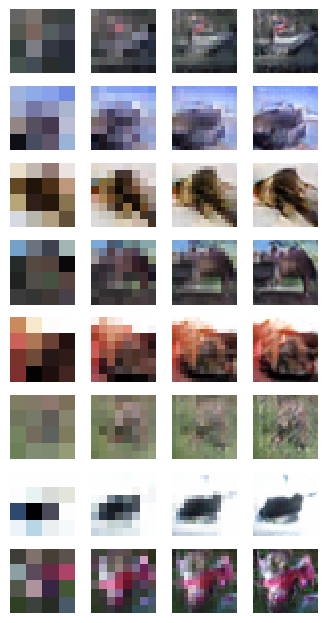

Epoch 125
                        Batch 0 Loss 0.4408
Epoch 125
                        Batch 100 Loss 0.2813
Epoch 125
                        Batch 200 Loss 0.4585
Epoch 125
                        Batch 300 Loss 0.4029
Epoch 125
                        Batch 400 Loss 0.4493
Epoch 125
                        Batch 500 Loss 0.4671
Epoch 125
                        Batch 600 Loss 0.5900
Epoch 125
                        Batch 700 Loss 0.4562
Epoch 125
                        Batch 800 Loss 0.8803
Epoch 125
                        Batch 900 Loss 0.6748
Epoch 125
                        Batch 1000 Loss 0.4055
Epoch 125
                        Batch 1100 Loss 0.7024
Epoch 125
                        Batch 1200 Loss 0.2506
Epoch 125
                        Batch 1300 Loss 0.4073
Epoch 125
                        Batch 1400 Loss 0.5993
Epoch 125
                        Batch 1500 Loss 0.2530
Epoch 125
                        Batch 1600 Loss 0.4160
Epoch 125
                        Batch 170

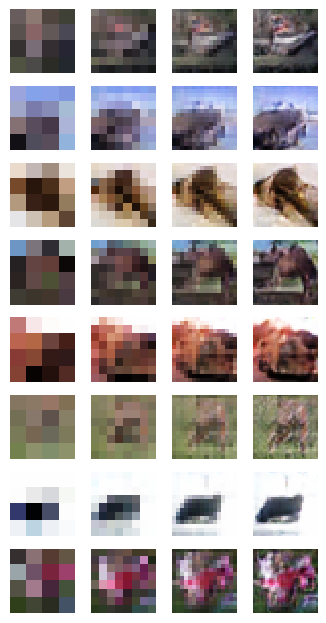

Epoch 126
                        Batch 0 Loss 0.6280
Epoch 126
                        Batch 100 Loss 0.2522
Epoch 126
                        Batch 200 Loss 0.4848
Epoch 126
                        Batch 300 Loss 0.3432
Epoch 126
                        Batch 400 Loss 0.1522
Epoch 126
                        Batch 500 Loss 0.5312
Epoch 126
                        Batch 600 Loss 0.4178
Epoch 126
                        Batch 700 Loss 0.7095
Epoch 126
                        Batch 800 Loss 0.3737
Epoch 126
                        Batch 900 Loss 0.4321
Epoch 126
                        Batch 1000 Loss 0.5781
Epoch 126
                        Batch 1100 Loss 0.5870
Epoch 126
                        Batch 1200 Loss 0.5289
Epoch 126
                        Batch 1300 Loss 0.3475
Epoch 126
                        Batch 1400 Loss 0.4648
Epoch 126
                        Batch 1500 Loss 0.6262
Epoch 126
                        Batch 1600 Loss 0.4144
Epoch 126
                        Batch 170

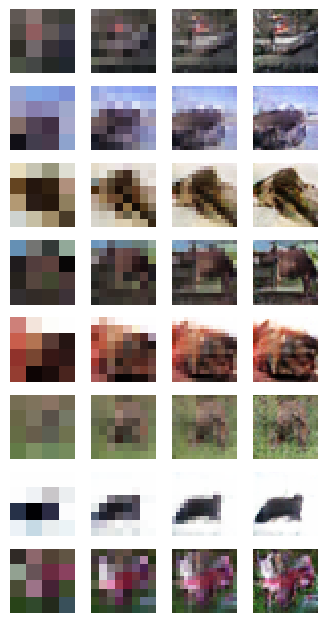

Epoch 127
                        Batch 0 Loss 0.5871
Epoch 127
                        Batch 100 Loss 0.2629
Epoch 127
                        Batch 200 Loss 0.4761
Epoch 127
                        Batch 300 Loss 0.5139
Epoch 127
                        Batch 400 Loss 0.4803
Epoch 127
                        Batch 500 Loss 0.5860
Epoch 127
                        Batch 600 Loss 0.4340
Epoch 127
                        Batch 700 Loss 0.4911
Epoch 127
                        Batch 800 Loss 0.5315
Epoch 127
                        Batch 900 Loss 0.5448
Epoch 127
                        Batch 1000 Loss 0.5151
Epoch 127
                        Batch 1100 Loss 0.3965
Epoch 127
                        Batch 1200 Loss 0.3348
Epoch 127
                        Batch 1300 Loss 0.3433
Epoch 127
                        Batch 1400 Loss 0.4492
Epoch 127
                        Batch 1500 Loss 0.4108
Epoch 127
                        Batch 1600 Loss 0.4516
Epoch 127
                        Batch 170

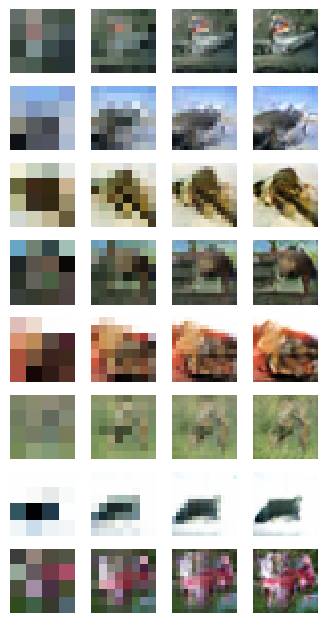

Epoch 128
                        Batch 0 Loss 0.5091
Epoch 128
                        Batch 100 Loss 0.4155
Epoch 128
                        Batch 200 Loss 0.4866
Epoch 128
                        Batch 300 Loss 0.4338
Epoch 128
                        Batch 400 Loss 0.2895
Epoch 128
                        Batch 500 Loss 0.6352
Epoch 128
                        Batch 600 Loss 0.6202
Epoch 128
                        Batch 700 Loss 0.4175
Epoch 128
                        Batch 800 Loss 0.4150
Epoch 128
                        Batch 900 Loss 0.3977
Epoch 128
                        Batch 1000 Loss 0.6223
Epoch 128
                        Batch 1100 Loss 0.5408
Epoch 128
                        Batch 1200 Loss 0.4490
Epoch 128
                        Batch 1300 Loss 0.4666
Epoch 128
                        Batch 1400 Loss 0.4594
Epoch 128
                        Batch 1500 Loss 0.4116
Epoch 128
                        Batch 1600 Loss 0.5208
Epoch 128
                        Batch 170

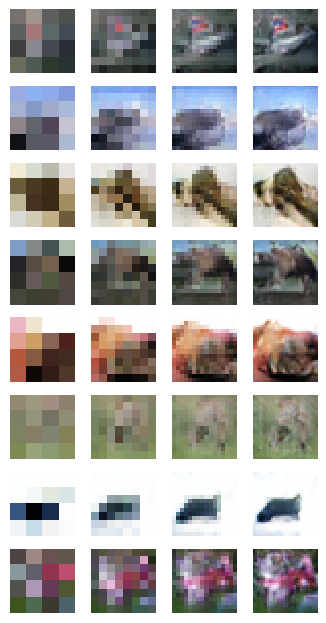

Epoch 129
                        Batch 0 Loss 0.3473
Epoch 129
                        Batch 100 Loss 0.3787
Epoch 129
                        Batch 200 Loss 0.1508
Epoch 129
                        Batch 300 Loss 0.3632
Epoch 129
                        Batch 400 Loss 0.6619
Epoch 129
                        Batch 500 Loss 0.3767
Epoch 129
                        Batch 600 Loss 0.2397
Epoch 129
                        Batch 700 Loss 0.4904
Epoch 129
                        Batch 800 Loss 0.5003
Epoch 129
                        Batch 900 Loss 0.2567
Epoch 129
                        Batch 1000 Loss 0.6781
Epoch 129
                        Batch 1100 Loss 0.4495
Epoch 129
                        Batch 1200 Loss 0.3439
Epoch 129
                        Batch 1300 Loss 0.2832
Epoch 129
                        Batch 1400 Loss 0.4143
Epoch 129
                        Batch 1500 Loss 0.6023
Epoch 129
                        Batch 1600 Loss 0.3227
Epoch 129
                        Batch 170

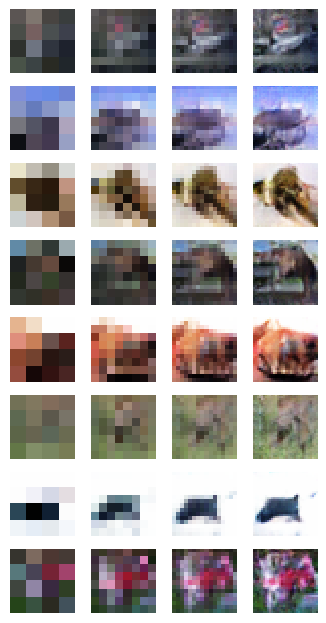

Epoch 130
                        Batch 0 Loss 0.3518
Epoch 130
                        Batch 100 Loss 0.2220
Epoch 130
                        Batch 200 Loss 0.2246
Epoch 130
                        Batch 300 Loss 0.4517
Epoch 130
                        Batch 400 Loss 0.4216
Epoch 130
                        Batch 500 Loss 0.3722
Epoch 130
                        Batch 600 Loss 0.5604
Epoch 130
                        Batch 700 Loss 0.5991
Epoch 130
                        Batch 800 Loss 0.2538
Epoch 130
                        Batch 900 Loss 0.5593
Epoch 130
                        Batch 1000 Loss 0.5294
Epoch 130
                        Batch 1100 Loss 0.4499
Epoch 130
                        Batch 1200 Loss 0.1404
Epoch 130
                        Batch 1300 Loss 0.2879
Epoch 130
                        Batch 1400 Loss 0.5999
Epoch 130
                        Batch 1500 Loss 0.4661
Epoch 130
                        Batch 1600 Loss 0.4559
Epoch 130
                        Batch 170

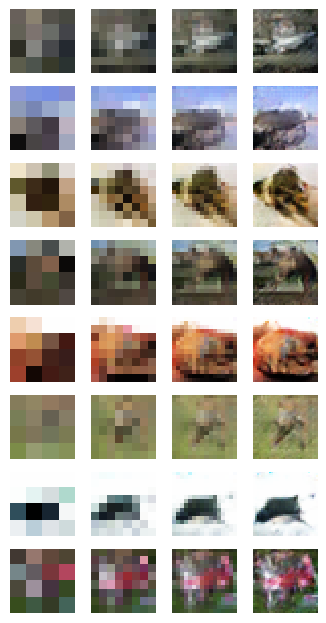

Epoch 131
                        Batch 0 Loss 0.2463
Epoch 131
                        Batch 100 Loss 0.2857
Epoch 131
                        Batch 200 Loss 0.3577
Epoch 131
                        Batch 300 Loss 0.2462
Epoch 131
                        Batch 400 Loss 0.5570
Epoch 131
                        Batch 500 Loss 0.4381
Epoch 131
                        Batch 600 Loss 0.5510
Epoch 131
                        Batch 700 Loss 0.4267
Epoch 131
                        Batch 800 Loss 0.4722
Epoch 131
                        Batch 900 Loss 0.6232
Epoch 131
                        Batch 1000 Loss 0.6359
Epoch 131
                        Batch 1100 Loss 0.5936
Epoch 131
                        Batch 1200 Loss 0.4800
Epoch 131
                        Batch 1300 Loss 0.5002
Epoch 131
                        Batch 1400 Loss 0.4237
Epoch 131
                        Batch 1500 Loss 0.4905
Epoch 131
                        Batch 1600 Loss 0.4099
Epoch 131
                        Batch 170

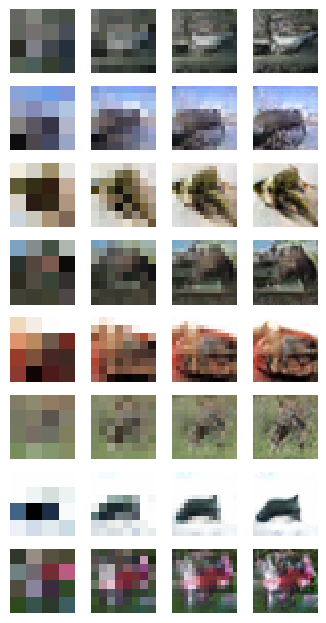

Epoch 132
                        Batch 0 Loss 0.3992
Epoch 132
                        Batch 100 Loss 0.4106
Epoch 132
                        Batch 200 Loss 0.2149
Epoch 132
                        Batch 300 Loss 0.5412
Epoch 132
                        Batch 400 Loss 0.4679
Epoch 132
                        Batch 500 Loss 0.4616
Epoch 132
                        Batch 600 Loss 0.3209
Epoch 132
                        Batch 700 Loss 0.7740
Epoch 132
                        Batch 800 Loss 0.3425
Epoch 132
                        Batch 900 Loss 0.4294
Epoch 132
                        Batch 1000 Loss 0.3726
Epoch 132
                        Batch 1100 Loss 0.3861
Epoch 132
                        Batch 1200 Loss 0.6618
Epoch 132
                        Batch 1300 Loss 0.4611
Epoch 132
                        Batch 1400 Loss 0.5517
Epoch 132
                        Batch 1500 Loss 0.5095
Epoch 132
                        Batch 1600 Loss 0.5994
Epoch 132
                        Batch 170

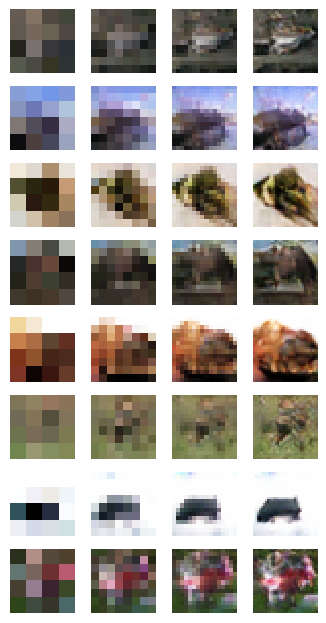

Epoch 133
                        Batch 0 Loss 0.5966
Epoch 133
                        Batch 100 Loss 0.6686
Epoch 133
                        Batch 200 Loss 0.3299
Epoch 133
                        Batch 300 Loss 0.4845
Epoch 133
                        Batch 400 Loss 0.6095
Epoch 133
                        Batch 500 Loss 0.4191
Epoch 133
                        Batch 600 Loss 0.4294
Epoch 133
                        Batch 700 Loss 0.6032
Epoch 133
                        Batch 800 Loss 0.3511
Epoch 133
                        Batch 900 Loss 0.2319
Epoch 133
                        Batch 1000 Loss 0.5059
Epoch 133
                        Batch 1100 Loss 0.5071
Epoch 133
                        Batch 1200 Loss 0.5432
Epoch 133
                        Batch 1300 Loss 0.3519
Epoch 133
                        Batch 1400 Loss 0.3896
Epoch 133
                        Batch 1500 Loss 0.4943
Epoch 133
                        Batch 1600 Loss 0.8105
Epoch 133
                        Batch 170

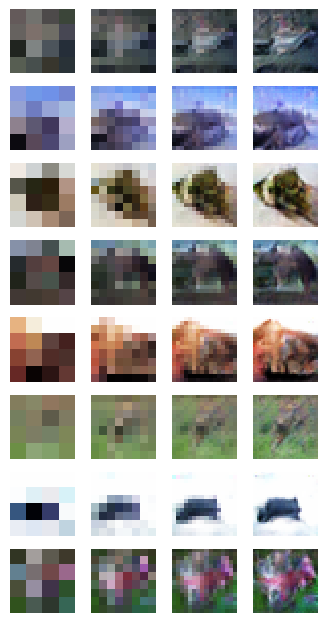

Epoch 134
                        Batch 0 Loss 0.4468
Epoch 134
                        Batch 100 Loss 0.4591
Epoch 134
                        Batch 200 Loss 0.3257
Epoch 134
                        Batch 300 Loss 0.5987
Epoch 134
                        Batch 400 Loss 0.5734
Epoch 134
                        Batch 500 Loss 0.3579
Epoch 134
                        Batch 600 Loss 0.4470
Epoch 134
                        Batch 700 Loss 0.2799
Epoch 134
                        Batch 800 Loss 0.5977
Epoch 134
                        Batch 900 Loss 0.4575
Epoch 134
                        Batch 1000 Loss 0.4149
Epoch 134
                        Batch 1100 Loss 0.3571
Epoch 134
                        Batch 1200 Loss 0.6958
Epoch 134
                        Batch 1300 Loss 0.3935
Epoch 134
                        Batch 1400 Loss 0.1922
Epoch 134
                        Batch 1500 Loss 0.4099
Epoch 134
                        Batch 1600 Loss 0.5917
Epoch 134
                        Batch 170

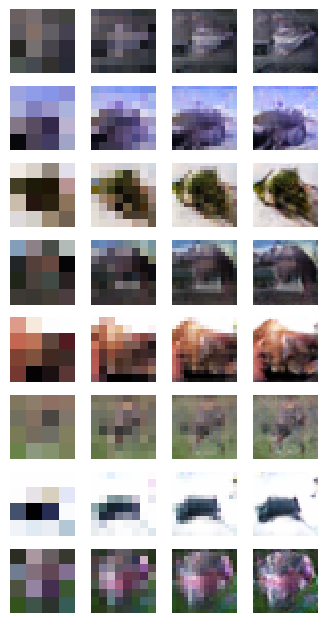

Epoch 135
                        Batch 0 Loss 0.3482
Epoch 135
                        Batch 100 Loss 0.4469
Epoch 135
                        Batch 200 Loss 0.3130
Epoch 135
                        Batch 300 Loss 0.4274
Epoch 135
                        Batch 400 Loss 0.3937
Epoch 135
                        Batch 500 Loss 0.7004
Epoch 135
                        Batch 600 Loss 0.6024
Epoch 135
                        Batch 700 Loss 0.3027
Epoch 135
                        Batch 800 Loss 0.4574
Epoch 135
                        Batch 900 Loss 0.3809
Epoch 135
                        Batch 1000 Loss 0.7451
Epoch 135
                        Batch 1100 Loss 0.2509
Epoch 135
                        Batch 1200 Loss 0.4021
Epoch 135
                        Batch 1300 Loss 0.4359
Epoch 135
                        Batch 1400 Loss 0.1817
Epoch 135
                        Batch 1500 Loss 0.5520
Epoch 135
                        Batch 1600 Loss 0.3888
Epoch 135
                        Batch 170

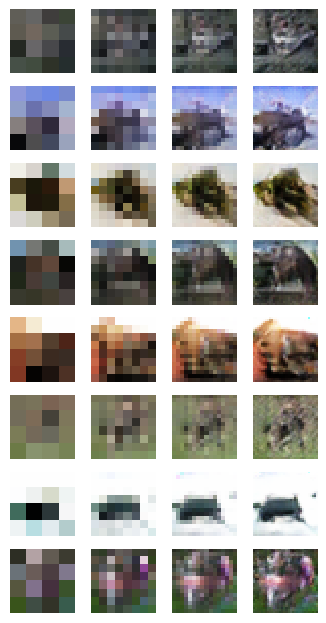

Epoch 136
                        Batch 0 Loss 0.3840
Epoch 136
                        Batch 100 Loss 0.4473
Epoch 136
                        Batch 200 Loss 0.3816
Epoch 136
                        Batch 300 Loss 0.2526
Epoch 136
                        Batch 400 Loss 0.5312
Epoch 136
                        Batch 500 Loss 0.5857
Epoch 136
                        Batch 600 Loss 0.5021
Epoch 136
                        Batch 700 Loss 0.2248
Epoch 136
                        Batch 800 Loss 0.3560
Epoch 136
                        Batch 900 Loss 0.3844
Epoch 136
                        Batch 1000 Loss 0.7066
Epoch 136
                        Batch 1100 Loss 0.2726
Epoch 136
                        Batch 1200 Loss 0.4048
Epoch 136
                        Batch 1300 Loss 0.7605
Epoch 136
                        Batch 1400 Loss 0.2501
Epoch 136
                        Batch 1500 Loss 0.3625
Epoch 136
                        Batch 1600 Loss 0.4627
Epoch 136
                        Batch 170

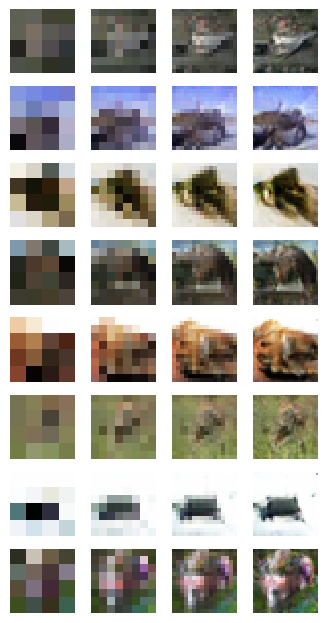

Epoch 137
                        Batch 0 Loss 0.5747
Epoch 137
                        Batch 100 Loss 0.4854
Epoch 137
                        Batch 200 Loss 0.5952
Epoch 137
                        Batch 300 Loss 0.6512
Epoch 137
                        Batch 400 Loss 0.6690
Epoch 137
                        Batch 500 Loss 0.5243
Epoch 137
                        Batch 600 Loss 0.5648
Epoch 137
                        Batch 700 Loss 0.3138
Epoch 137
                        Batch 800 Loss 0.5291
Epoch 137
                        Batch 900 Loss 0.6415
Epoch 137
                        Batch 1000 Loss 0.4270
Epoch 137
                        Batch 1100 Loss 0.5151
Epoch 137
                        Batch 1200 Loss 0.6182
Epoch 137
                        Batch 1300 Loss 0.2080
Epoch 137
                        Batch 1400 Loss 0.4872
Epoch 137
                        Batch 1500 Loss 0.4024
Epoch 137
                        Batch 1600 Loss 0.4860
Epoch 137
                        Batch 170

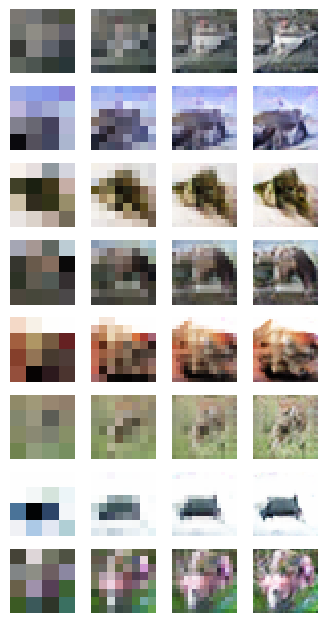

Epoch 138
                        Batch 0 Loss 0.4500
Epoch 138
                        Batch 100 Loss 0.4630
Epoch 138
                        Batch 200 Loss 0.3318
Epoch 138
                        Batch 300 Loss 0.4161
Epoch 138
                        Batch 400 Loss 0.5268
Epoch 138
                        Batch 500 Loss 0.4629
Epoch 138
                        Batch 600 Loss 0.3280
Epoch 138
                        Batch 700 Loss 0.4652
Epoch 138
                        Batch 800 Loss 0.2816
Epoch 138
                        Batch 900 Loss 0.5562
Epoch 138
                        Batch 1000 Loss 0.5735
Epoch 138
                        Batch 1100 Loss 0.3859
Epoch 138
                        Batch 1200 Loss 0.4078
Epoch 138
                        Batch 1300 Loss 0.6167
Epoch 138
                        Batch 1400 Loss 0.3047
Epoch 138
                        Batch 1500 Loss 0.4698
Epoch 138
                        Batch 1600 Loss 0.4964
Epoch 138
                        Batch 170

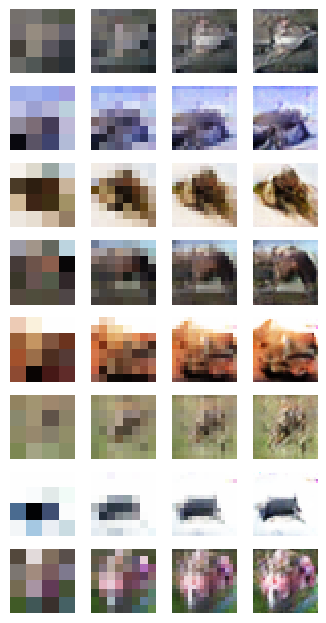

Epoch 139
                        Batch 0 Loss 0.5580
Epoch 139
                        Batch 100 Loss 0.4745
Epoch 139
                        Batch 200 Loss 0.4730
Epoch 139
                        Batch 300 Loss 0.3861
Epoch 139
                        Batch 400 Loss 0.2845
Epoch 139
                        Batch 500 Loss 0.6730
Epoch 139
                        Batch 600 Loss 0.3964
Epoch 139
                        Batch 700 Loss 0.5391
Epoch 139
                        Batch 800 Loss 0.4864
Epoch 139
                        Batch 900 Loss 0.2690
Epoch 139
                        Batch 1000 Loss 0.6114
Epoch 139
                        Batch 1100 Loss 0.3933
Epoch 139
                        Batch 1200 Loss 0.6170
Epoch 139
                        Batch 1300 Loss 0.6700
Epoch 139
                        Batch 1400 Loss 0.5424
Epoch 139
                        Batch 1500 Loss 0.2835
Epoch 139
                        Batch 1600 Loss 0.4380
Epoch 139
                        Batch 170

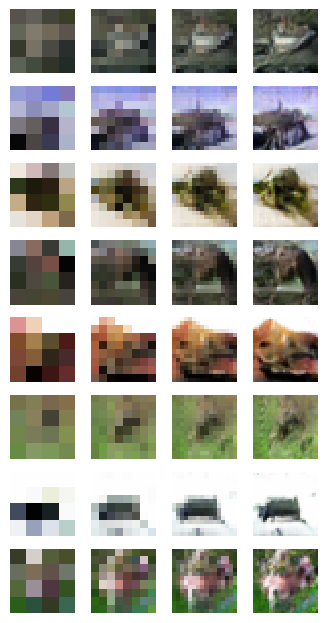

Epoch 140
                        Batch 0 Loss 0.3886
Epoch 140
                        Batch 100 Loss 0.6124
Epoch 140
                        Batch 200 Loss 0.6195
Epoch 140
                        Batch 300 Loss 0.8778
Epoch 140
                        Batch 400 Loss 0.8017
Epoch 140
                        Batch 500 Loss 0.3778
Epoch 140
                        Batch 600 Loss 0.4338
Epoch 140
                        Batch 700 Loss 0.4078
Epoch 140
                        Batch 800 Loss 0.4545
Epoch 140
                        Batch 900 Loss 0.4249
Epoch 140
                        Batch 1000 Loss 0.7419
Epoch 140
                        Batch 1100 Loss 0.6024
Epoch 140
                        Batch 1200 Loss 0.5449
Epoch 140
                        Batch 1300 Loss 0.5052
Epoch 140
                        Batch 1400 Loss 0.4970
Epoch 140
                        Batch 1500 Loss 0.3384
Epoch 140
                        Batch 1600 Loss 0.2032
Epoch 140
                        Batch 170

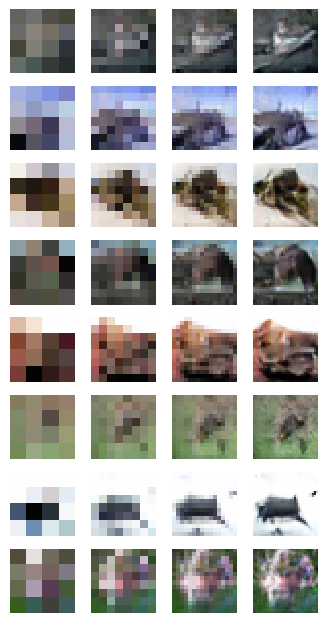

Epoch 141
                        Batch 0 Loss 0.5087
Epoch 141
                        Batch 100 Loss 0.5353
Epoch 141
                        Batch 200 Loss 0.3427
Epoch 141
                        Batch 300 Loss 0.4608
Epoch 141
                        Batch 400 Loss 0.5272
Epoch 141
                        Batch 500 Loss 0.4489
Epoch 141
                        Batch 600 Loss 0.6488
Epoch 141
                        Batch 700 Loss 0.7226
Epoch 141
                        Batch 800 Loss 0.4895
Epoch 141
                        Batch 900 Loss 0.5422
Epoch 141
                        Batch 1000 Loss 0.6875
Epoch 141
                        Batch 1100 Loss 0.5863
Epoch 141
                        Batch 1200 Loss 0.7882
Epoch 141
                        Batch 1300 Loss 0.3197
Epoch 141
                        Batch 1400 Loss 0.3855
Epoch 141
                        Batch 1500 Loss 0.4845
Epoch 141
                        Batch 1600 Loss 0.4120
Epoch 141
                        Batch 170

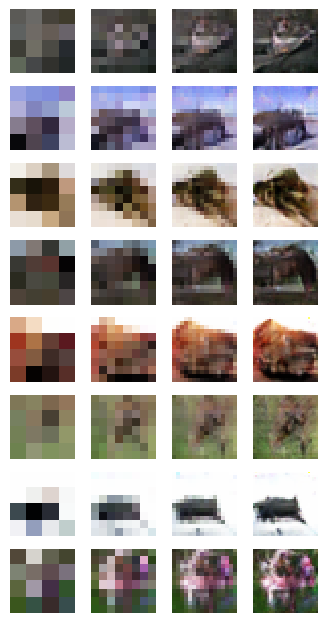

Epoch 142
                        Batch 0 Loss 0.7073
Epoch 142
                        Batch 100 Loss 0.5911
Epoch 142
                        Batch 200 Loss 0.5402
Epoch 142
                        Batch 300 Loss 0.3590
Epoch 142
                        Batch 400 Loss 0.5327
Epoch 142
                        Batch 500 Loss 0.6462
Epoch 142
                        Batch 600 Loss 0.4137
Epoch 142
                        Batch 700 Loss 0.3082
Epoch 142
                        Batch 800 Loss 0.3473
Epoch 142
                        Batch 900 Loss 0.6692
Epoch 142
                        Batch 1000 Loss 0.5887
Epoch 142
                        Batch 1100 Loss 0.4957
Epoch 142
                        Batch 1200 Loss 0.2611
Epoch 142
                        Batch 1300 Loss 0.4141
Epoch 142
                        Batch 1400 Loss 0.6560
Epoch 142
                        Batch 1500 Loss 0.5357
Epoch 142
                        Batch 1600 Loss 0.3804
Epoch 142
                        Batch 170

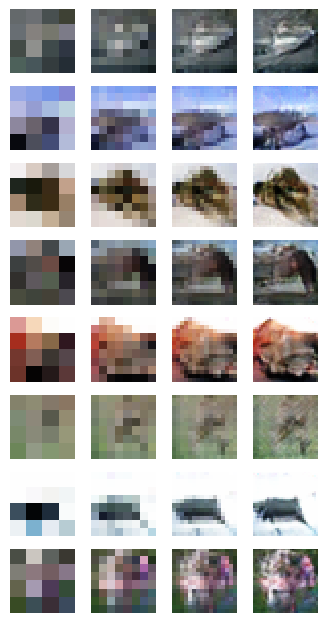

Epoch 143
                        Batch 0 Loss 0.3622
Epoch 143
                        Batch 100 Loss 0.4147
Epoch 143
                        Batch 200 Loss 0.2985
Epoch 143
                        Batch 300 Loss 0.1895
Epoch 143
                        Batch 400 Loss 0.5618
Epoch 143
                        Batch 500 Loss 0.4072
Epoch 143
                        Batch 600 Loss 0.4948
Epoch 143
                        Batch 700 Loss 0.5433
Epoch 143
                        Batch 800 Loss 0.4113
Epoch 143
                        Batch 900 Loss 0.5712
Epoch 143
                        Batch 1000 Loss 0.4479
Epoch 143
                        Batch 1100 Loss 0.2800
Epoch 143
                        Batch 1200 Loss 0.3929
Epoch 143
                        Batch 1300 Loss 0.7665
Epoch 143
                        Batch 1400 Loss 0.7092
Epoch 143
                        Batch 1500 Loss 0.3676
Epoch 143
                        Batch 1600 Loss 0.4692
Epoch 143
                        Batch 170

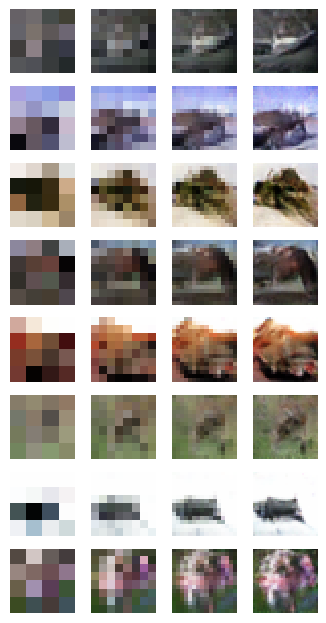

Epoch 144
                        Batch 0 Loss 0.4193
Epoch 144
                        Batch 100 Loss 0.5748
Epoch 144
                        Batch 200 Loss 0.3658
Epoch 144
                        Batch 300 Loss 0.3875
Epoch 144
                        Batch 400 Loss 0.2511
Epoch 144
                        Batch 500 Loss 0.4452
Epoch 144
                        Batch 600 Loss 0.2098
Epoch 144
                        Batch 700 Loss 0.4115
Epoch 144
                        Batch 800 Loss 0.4604
Epoch 144
                        Batch 900 Loss 0.4912
Epoch 144
                        Batch 1000 Loss 0.2944
Epoch 144
                        Batch 1100 Loss 0.3304
Epoch 144
                        Batch 1200 Loss 0.4522
Epoch 144
                        Batch 1300 Loss 0.1934
Epoch 144
                        Batch 1400 Loss 0.6699
Epoch 144
                        Batch 1500 Loss 0.6081
Epoch 144
                        Batch 1600 Loss 0.5389
Epoch 144
                        Batch 170

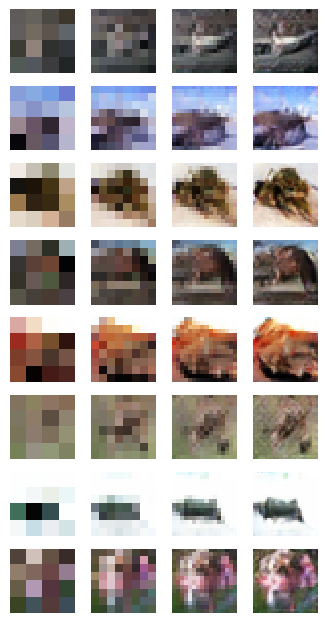

Epoch 145
                        Batch 0 Loss 0.5108
Epoch 145
                        Batch 100 Loss 0.4959
Epoch 145
                        Batch 200 Loss 0.6071
Epoch 145
                        Batch 300 Loss 0.5772
Epoch 145
                        Batch 400 Loss 0.5165
Epoch 145
                        Batch 500 Loss 0.3885
Epoch 145
                        Batch 600 Loss 0.5828
Epoch 145
                        Batch 700 Loss 0.5597
Epoch 145
                        Batch 800 Loss 0.5311
Epoch 145
                        Batch 900 Loss 0.5898
Epoch 145
                        Batch 1000 Loss 0.3703
Epoch 145
                        Batch 1100 Loss 0.6050
Epoch 145
                        Batch 1200 Loss 0.5767
Epoch 145
                        Batch 1300 Loss 0.1949
Epoch 145
                        Batch 1400 Loss 0.5336
Epoch 145
                        Batch 1500 Loss 0.6044
Epoch 145
                        Batch 1600 Loss 0.4860
Epoch 145
                        Batch 170

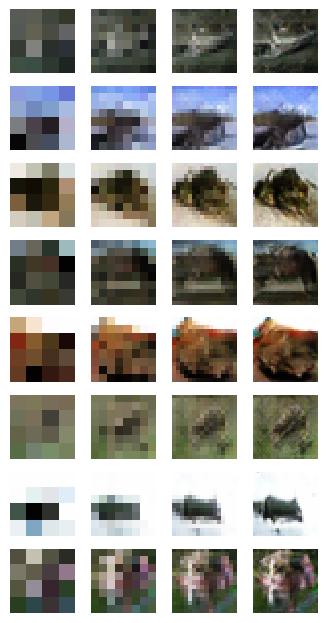

Epoch 146
                        Batch 0 Loss 0.5338
Epoch 146
                        Batch 100 Loss 0.4850
Epoch 146
                        Batch 200 Loss 0.5110
Epoch 146
                        Batch 300 Loss 0.4431
Epoch 146
                        Batch 400 Loss 0.3331
Epoch 146
                        Batch 500 Loss 0.4642
Epoch 146
                        Batch 600 Loss 0.2086
Epoch 146
                        Batch 700 Loss 0.5792
Epoch 146
                        Batch 800 Loss 0.5242
Epoch 146
                        Batch 900 Loss 0.6766
Epoch 146
                        Batch 1000 Loss 0.4797
Epoch 146
                        Batch 1100 Loss 0.2862
Epoch 146
                        Batch 1200 Loss 0.6949
Epoch 146
                        Batch 1300 Loss 0.4811
Epoch 146
                        Batch 1400 Loss 0.7091
Epoch 146
                        Batch 1500 Loss 0.4749
Epoch 146
                        Batch 1600 Loss 0.3538
Epoch 146
                        Batch 170

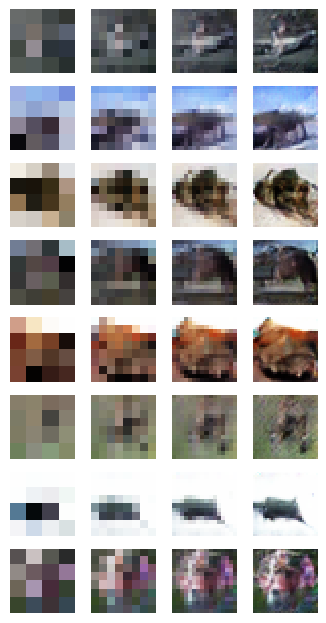

Epoch 147
                        Batch 0 Loss 0.6082
Epoch 147
                        Batch 100 Loss 0.3807
Epoch 147
                        Batch 200 Loss 0.5094
Epoch 147
                        Batch 300 Loss 0.5676
Epoch 147
                        Batch 400 Loss 0.6377
Epoch 147
                        Batch 500 Loss 0.5161
Epoch 147
                        Batch 600 Loss 0.6007
Epoch 147
                        Batch 700 Loss 0.3316
Epoch 147
                        Batch 800 Loss 0.6766
Epoch 147
                        Batch 900 Loss 0.6404
Epoch 147
                        Batch 1000 Loss 0.5458
Epoch 147
                        Batch 1100 Loss 0.5106
Epoch 147
                        Batch 1200 Loss 0.2482
Epoch 147
                        Batch 1300 Loss 0.6709
Epoch 147
                        Batch 1400 Loss 0.5552
Epoch 147
                        Batch 1500 Loss 0.5385
Epoch 147
                        Batch 1600 Loss 0.4286
Epoch 147
                        Batch 170

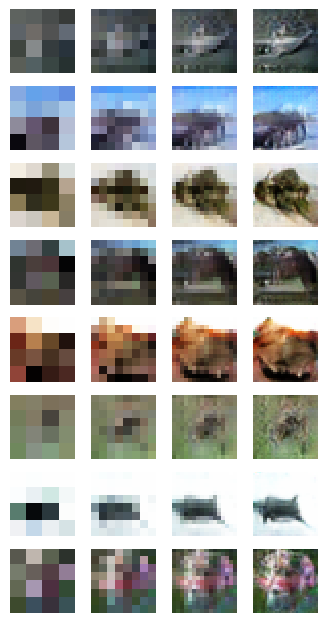

Epoch 148
                        Batch 0 Loss 0.1729
Epoch 148
                        Batch 100 Loss 0.3875
Epoch 148
                        Batch 200 Loss 0.2839
Epoch 148
                        Batch 300 Loss 0.4716
Epoch 148
                        Batch 400 Loss 0.6007
Epoch 148
                        Batch 500 Loss 0.4933
Epoch 148
                        Batch 600 Loss 0.5538
Epoch 148
                        Batch 700 Loss 0.3920
Epoch 148
                        Batch 800 Loss 0.4057
Epoch 148
                        Batch 900 Loss 0.4030
Epoch 148
                        Batch 1000 Loss 0.5388
Epoch 148
                        Batch 1100 Loss 0.3510
Epoch 148
                        Batch 1200 Loss 0.5139
Epoch 148
                        Batch 1300 Loss 0.6143
Epoch 148
                        Batch 1400 Loss 0.4307
Epoch 148
                        Batch 1500 Loss 0.6527
Epoch 148
                        Batch 1600 Loss 0.5250
Epoch 148
                        Batch 170

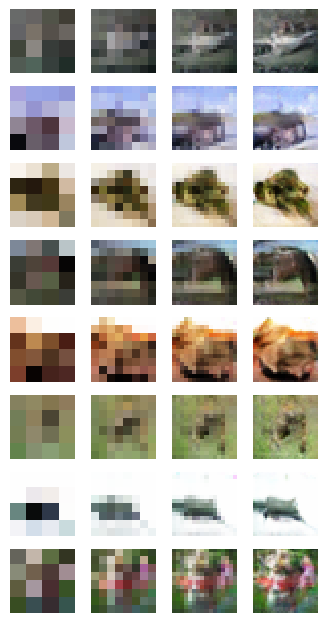

Epoch 149
                        Batch 0 Loss 0.3828
Epoch 149
                        Batch 100 Loss 0.3591
Epoch 149
                        Batch 200 Loss 0.5125
Epoch 149
                        Batch 300 Loss 0.2388
Epoch 149
                        Batch 400 Loss 0.3222
Epoch 149
                        Batch 500 Loss 0.5167
Epoch 149
                        Batch 600 Loss 0.3319
Epoch 149
                        Batch 700 Loss 0.3745
Epoch 149
                        Batch 800 Loss 0.3038
Epoch 149
                        Batch 900 Loss 0.4845
Epoch 149
                        Batch 1000 Loss 0.4901
Epoch 149
                        Batch 1100 Loss 0.2435
Epoch 149
                        Batch 1200 Loss 0.5217
Epoch 149
                        Batch 1300 Loss 0.4848
Epoch 149
                        Batch 1400 Loss 0.5177
Epoch 149
                        Batch 1500 Loss 0.3629
Epoch 149
                        Batch 1600 Loss 0.5764
Epoch 149
                        Batch 170

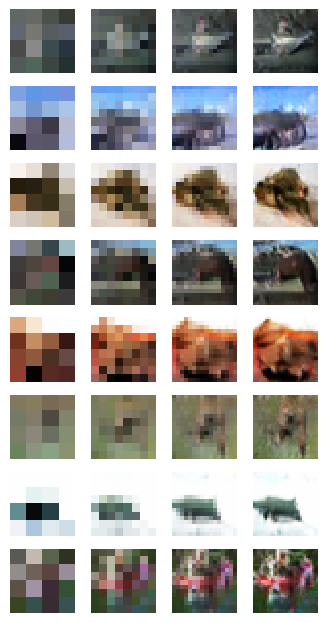

Epoch 150
                        Batch 0 Loss 0.5088
Epoch 150
                        Batch 100 Loss 0.6202
Epoch 150
                        Batch 200 Loss 0.5300
Epoch 150
                        Batch 300 Loss 0.7404
Epoch 150
                        Batch 400 Loss 0.3119
Epoch 150
                        Batch 500 Loss 0.3200
Epoch 150
                        Batch 600 Loss 0.5436
Epoch 150
                        Batch 700 Loss 0.4687
Epoch 150
                        Batch 800 Loss 0.4642
Epoch 150
                        Batch 900 Loss 0.5559
Epoch 150
                        Batch 1000 Loss 0.5410
Epoch 150
                        Batch 1100 Loss 0.2854
Epoch 150
                        Batch 1200 Loss 0.5887
Epoch 150
                        Batch 1300 Loss 0.3679
Epoch 150
                        Batch 1400 Loss 0.5262
Epoch 150
                        Batch 1500 Loss 0.4344
Epoch 150
                        Batch 1600 Loss 0.5751
Epoch 150
                        Batch 170

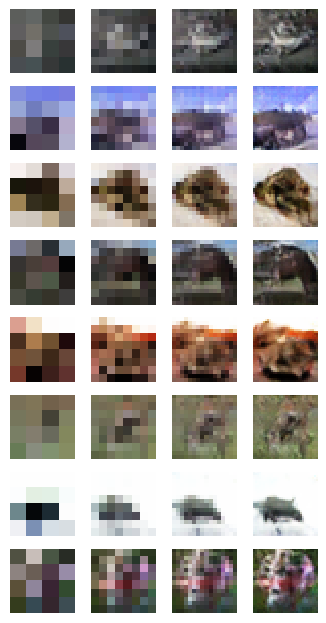

Epoch 151
                        Batch 0 Loss 0.3534
Epoch 151
                        Batch 100 Loss 0.5843
Epoch 151
                        Batch 200 Loss 0.5473
Epoch 151
                        Batch 300 Loss 0.1189
Epoch 151
                        Batch 400 Loss 0.3001
Epoch 151
                        Batch 500 Loss 0.3961
Epoch 151
                        Batch 600 Loss 0.2465
Epoch 151
                        Batch 700 Loss 0.3305
Epoch 151
                        Batch 800 Loss 0.5209
Epoch 151
                        Batch 900 Loss 0.2253
Epoch 151
                        Batch 1000 Loss 0.4328
Epoch 151
                        Batch 1100 Loss 0.6688
Epoch 151
                        Batch 1200 Loss 0.4764
Epoch 151
                        Batch 1300 Loss 0.4685
Epoch 151
                        Batch 1400 Loss 0.3876
Epoch 151
                        Batch 1500 Loss 0.5289
Epoch 151
                        Batch 1600 Loss 0.5326
Epoch 151
                        Batch 170

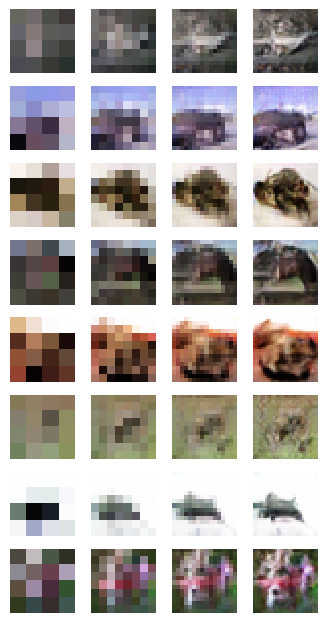

Epoch 152
                        Batch 0 Loss 0.4851
Epoch 152
                        Batch 100 Loss 0.5907
Epoch 152
                        Batch 200 Loss 0.2402
Epoch 152
                        Batch 300 Loss 0.3408
Epoch 152
                        Batch 400 Loss 0.2455
Epoch 152
                        Batch 500 Loss 0.4935
Epoch 152
                        Batch 600 Loss 0.3044
Epoch 152
                        Batch 700 Loss 0.5018
Epoch 152
                        Batch 800 Loss 0.2472
Epoch 152
                        Batch 900 Loss 0.8713
Epoch 152
                        Batch 1000 Loss 0.4251
Epoch 152
                        Batch 1100 Loss 0.2934
Epoch 152
                        Batch 1200 Loss 0.5860
Epoch 152
                        Batch 1300 Loss 0.6650
Epoch 152
                        Batch 1400 Loss 0.5594
Epoch 152
                        Batch 1500 Loss 0.3765
Epoch 152
                        Batch 1600 Loss 0.3443
Epoch 152
                        Batch 170

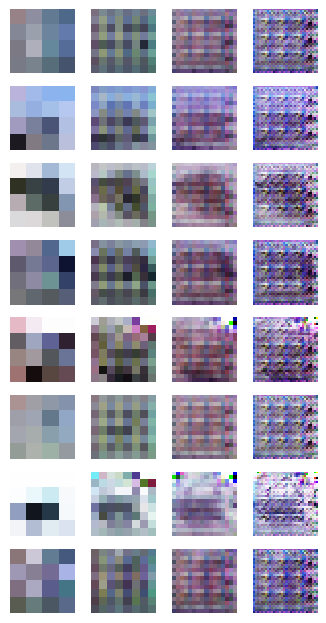

Epoch 153
                        Batch 0 Loss 0.3358
Epoch 153
                        Batch 100 Loss 0.8846
Epoch 153
                        Batch 200 Loss 0.6647
Epoch 153
                        Batch 300 Loss 0.4113
Epoch 153
                        Batch 400 Loss 1.7755
Epoch 153
                        Batch 500 Loss 0.6339
Epoch 153
                        Batch 600 Loss 0.8532
Epoch 153
                        Batch 700 Loss 1.9420
Epoch 153
                        Batch 800 Loss 0.7030
Epoch 153
                        Batch 900 Loss 0.4491
Epoch 153
                        Batch 1000 Loss 0.6512
Epoch 153
                        Batch 1100 Loss 0.3863
Epoch 153
                        Batch 1200 Loss 1.0414
Epoch 153
                        Batch 1300 Loss 0.5498
Epoch 153
                        Batch 1400 Loss 1.5524
Epoch 153
                        Batch 1500 Loss 0.4494
Epoch 153
                        Batch 1600 Loss 0.8198
Epoch 153
                        Batch 170

KeyboardInterrupt: 

In [20]:
# Training the model
(generator_losses, discriminator_losses) = train(dataset, 250)

In [ ]:
epochs = 250
gen = generator_losses[:epochs].mean(axis=1) / batch_size
disc = discriminator_losses[:epochs].mean(axis=1) / batch_size

fig_1 = plt.figure(figsize=(8, 4), dpi=100)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('DCGAN hibaértékei az első 50 epoch alatt')
ax.plot(np.linspace(1, epochs, epochs), gen, label='Generator')
ax.plot(np.linspace(1, epochs, epochs), disc, label='Discriminator')
ax.legend(loc=0)

ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

x_ticks = np.arange(0, epochs+1, 5)
x_ticks[0] = 1
ax.set_xticks(x_ticks)
plt.show()

In [30]:
generator.save("msgGeneratorCifar10.h5")
discriminator.save("msgDiscriminatorCifar10.h5")

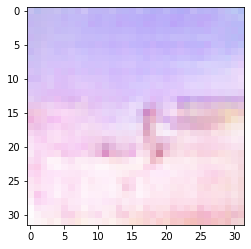

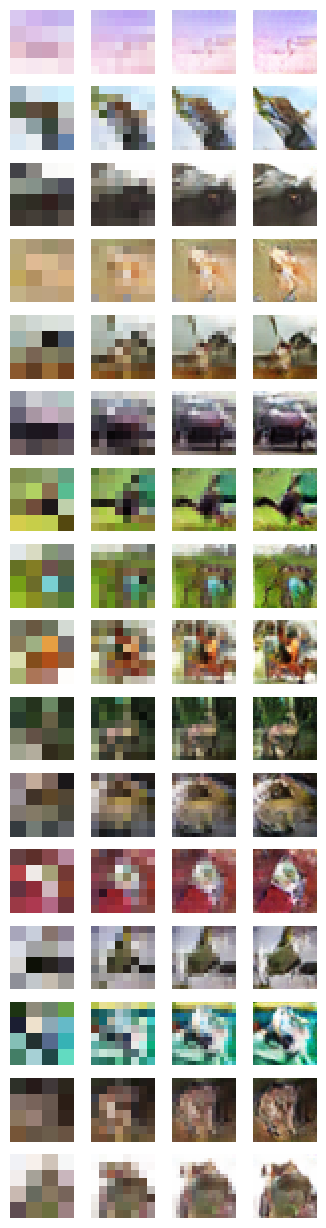

In [29]:
noises = tf.random.normal([16, latent_dim])
example_images = generator(noises, training=False)

plt.imshow((example_images[0][0].numpy()*127.5+127.5).astype("uint32"), interpolation='none')
plot_examples(example_images, 0)

In [27]:
#c.load_weights(checkpoint_dir + "/ckpt-10.index")
checkpoint.restore(checkpoint_dir + "/ckpt-10")